<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Setup" data-toc-modified-id="Setup-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Setup</a></span><ul class="toc-item"><li><span><a href="#Check-your-sample-table-(i.e.-metadata-file)" data-toc-modified-id="Check-your-sample-table-(i.e.-metadata-file)-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Check your sample table (i.e. metadata file)</a></span></li><li><span><a href="#Check-your-TRN" data-toc-modified-id="Check-your-TRN-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Check your TRN</a></span></li><li><span><a href="#Load-the-data" data-toc-modified-id="Load-the-data-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Load the data</a></span></li></ul></li><li><span><a href="#Regulatory-iModulons" data-toc-modified-id="Regulatory-iModulons-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Regulatory iModulons</a></span></li><li><span><a href="#Functional-iModulons" data-toc-modified-id="Functional-iModulons-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Functional iModulons</a></span><ul class="toc-item"><li><span><a href="#GO-Enrichments" data-toc-modified-id="GO-Enrichments-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>GO Enrichments</a></span></li><li><span><a href="#KEGG-Enrichments" data-toc-modified-id="KEGG-Enrichments-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>KEGG Enrichments</a></span><ul class="toc-item"><li><span><a href="#Load-KEGG-mapping" data-toc-modified-id="Load-KEGG-mapping-3.2.1"><span class="toc-item-num">3.2.1&nbsp;&nbsp;</span>Load KEGG mapping</a></span></li><li><span><a href="#Perform-enrichment" data-toc-modified-id="Perform-enrichment-3.2.2"><span class="toc-item-num">3.2.2&nbsp;&nbsp;</span>Perform enrichment</a></span></li><li><span><a href="#Convert-KEGG-IDs-to-human-readable-names" data-toc-modified-id="Convert-KEGG-IDs-to-human-readable-names-3.2.3"><span class="toc-item-num">3.2.3&nbsp;&nbsp;</span>Convert KEGG IDs to human-readable names</a></span></li><li><span><a href="#Save-files" data-toc-modified-id="Save-files-3.2.4"><span class="toc-item-num">3.2.4&nbsp;&nbsp;</span>Save files</a></span></li></ul></li></ul></li><li><span><a href="#Check-for-single-gene-iModulons" data-toc-modified-id="Check-for-single-gene-iModulons-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Check for single gene iModulons</a></span></li><li><span><a href="#Examine-global-activity-correlations" data-toc-modified-id="Examine-global-activity-correlations-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Examine global activity correlations</a></span></li><li><span><a href="#Use-metadata-to-automatically-characterize-iModulons" data-toc-modified-id="Use-metadata-to-automatically-characterize-iModulons-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Use metadata to automatically characterize iModulons</a></span></li><li><span><a href="#Compare-against-published-iModulons" data-toc-modified-id="Compare-against-published-iModulons-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Compare against published iModulons</a></span><ul class="toc-item"><li><span><a href="#Visualize-linked-iModulons" data-toc-modified-id="Visualize-linked-iModulons-7.1"><span class="toc-item-num">7.1&nbsp;&nbsp;</span>Visualize linked iModulons</a></span></li></ul></li><li><span><a href="#Save-iModulon-object" data-toc-modified-id="Save-iModulon-object-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Save iModulon object</a></span></li><li><span><a href="#Coming-soon" data-toc-modified-id="Coming-soon-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Coming soon</a></span></li></ul></div>

# Setup
This IPython notebook will walk through the steps of characterizing iModulons through semi-automated tools. You will need:
* M and A matrices
* Expression data (e.g. `log_tpm_norm.csv`)
* Gene table and KEGG/GO annotations (Generated in `gene_annotation.ipynb`)
* Sample table, with a column for `project` and `condition`
* TRN file

Optional:
* iModulon table (if you already have some characterized iModulons)

In [1]:
from pymodulon.core import IcaData
from pymodulon.plotting import *
from os import path
import pandas as pd
import re
from Bio.KEGG import REST
from tqdm.notebook import tqdm

In [2]:
# Enter the location of your data here
data_dir = '../data/'

## Check your sample table (i.e. metadata file)
Your metadata file will probably have a lot of columns, most of which you may not care about. Feel free to save a secondary copy of your metadata file with only columns that seem relevant to you. The two most important columns are:
1. `project`
2. `condition`

Make sure that these columns exist in your metadata file

In [3]:
df_metadata = pd.read_csv(path.join(data_dir,'metadata_qc.csv'),index_col=0)
df_metadata[['project','condition']].head()

project   condition
SRX3467357    FadR        wt_p
SRX3467358    FadR        wt_p
SRX3467359    FadR        ko_p
SRX3467360    FadR        ko_p
SRX3565164    GDGT  75_2.4_log

In [4]:
print(df_metadata.project.notnull().all())
print(df_metadata.condition.notnull().all())

True
True


## Check your TRN

Each row of the TRN file represents a regulatory interaction.  
**Your TRN file must have the following columns:**
1. `regulator` - Name of regulator (`/` or `+` characters will be converted to `;`)
1. `gene_id` - Locus tag of gene being regulated

The following columns are optional, but are helpful to have:
1. `regulator_id` - Locus tag of regulator
1. `gene_name` - Name of gene (can automatically update this using `name2num`)
1. `direction` - Direction of regulation ('+' for activation, '-' for repression, '?' or NaN for unknown)
1. `evidence` - Evidence of regulation (e.g. ChIP-exo, qRT-PCR, SELEX, Motif search)
1. `PMID` - Reference for regulation

You may add any other columns that could help you. TRNs may be saved as either CSV or TSV files. See below for an example:

In [5]:
df_trn = pd.read_csv(path.join(data_dir,'saci_trn_curated_01_01_2021.tsv'),sep='\t')
df_trn.head()

regulator  regulator_id gene_name       gene_id old_locus_tag  \
0      BarR  SACI_RS10330      barR  SACI_RS10330     Saci_2136   
1      BarR  SACI_RS10330      spuC  SACI_RS10335     Saci_2137   
2      BarR  SACI_RS10330    gltB_1  SACI_RS11230     Saci_2320   
3      BarR  SACI_RS10330    gltB_2  SACI_RS11235     Saci_2321   
4      LrpC  SACI_RS07575      lrpC  SACI_RS07575     Saci_1588   

  prokka_locus_tag      synonyms direction       evidence      PMID  \
0      Sacid_02134           NaN       NaN        qRT-PCR  24646198   
1      Sacid_02135           NaN         +        qRT-PCR  24646198   
2      Sacid_02323          gltB         +       ChIP-Seq  27502941   
3      Sacid_02324  gltB, purF_3         +       ChIP-Seq  27502941   
4      Sacid_01553        Sa-Lrp       NaN  qRT-PCR, EMSA  23255531   

                                    additional_notes  
0  BarR TF (Lrp/AsnC family transcriptional regul...  
1                                                NaN  
2                                                NaN  
3                                                NaN  
4  Sa-Lrp TF (Lrp/AsnC family transcriptional reg...

The `regulator` and `gene_id` must be filled in for each row

In [6]:
print(df_trn.regulator.notnull().all())
print(df_trn.gene_id.notnull().all())

True
True


## Load the data
You're now ready to load your IcaData object!

In [7]:
ica_data = IcaData(M = path.join(data_dir,'ica_runs/80/S.csv'),
                   A = path.join(data_dir,'ica_runs/80/A.csv'),
                   X = path.join(data_dir,'log_tpm_norm.csv'),
                   gene_table = path.join(data_dir,'gene_info_curated_Jan_07_2021.tsv'),
                   sample_table = path.join(data_dir,'metadata_qc.csv'),
                   trn = path.join(data_dir,'saci_trn_curated_01_01_2021.tsv'),
                   threshold_method = 'kmeans')

# Regulatory iModulons
Use `compute_trn_enrichment` to automatically check for Regulatory iModulons. The more complete your TRN, the more regulatory iModulons you'll find.

In [8]:
ica_data.compute_trn_enrichment()

imodulon   regulator        pvalue        qvalue  precision    recall  \
0        11        XylR  8.848495e-10  2.654548e-09   0.421053  0.173913   
1        12     YtrA-OE  2.737665e-13  8.212996e-13   0.562500  0.243243   
2        13        LysM  6.324328e-09  6.324328e-09   0.571429  0.400000   
3        26     YtrA-OE  9.564368e-06  9.564368e-06   0.187500  0.428571   
4        27  ArnR;ArnR1  8.720300e-21  1.744060e-20   0.727273  1.000000   
5        27   ArnA;ArnB  7.760893e-16  7.760893e-16   0.466667  0.875000   
6        29        FadR  1.349778e-37  1.349778e-37   0.791667  0.760000   

    f1score    TP  regulon_size  imodulon_size  n_regs  
0  0.246154   8.0          19.0           46.0     1.0  
1  0.339623   9.0          16.0           37.0     1.0  
2  0.470588   4.0           7.0           10.0     1.0  
3  0.260870   3.0          16.0            7.0     1.0  
4  0.842105   8.0          11.0            8.0     1.0  
5  0.608696   7.0          15.0            8.0     1.0  
6  0.775510  19.0          24.0           25.0     1.0

You can also search for AND/OR combinations of regulators using the `max_regs` argument. Here, we see that iModulon #27 may be regulated by the both ArnR;ArnR1 and ArnA;ArnB.

In [9]:
ica_data.compute_trn_enrichment(max_regs=2, save=True)

imodulon             regulator        pvalue        qvalue  precision  \
0         11        XylR/XylR;AraC  3.698761e-10  4.993328e-08   0.360000   
1         11                  XylR  8.848495e-10  5.972734e-08   0.421053   
2         11          YtrA-OE/XylR  7.721246e-08  3.474561e-06   0.258065   
3         11          YtrA-OE+XylR  1.412991e-07  4.768845e-06   1.000000   
4         12               YtrA-OE  2.737665e-13  3.695848e-11   0.562500   
5         12    YtrA-OE/heat-shock  9.924763e-11  6.699215e-09   0.333333   
6         12          FadR/YtrA-OE  1.938626e-10  8.723818e-09   0.250000   
7         13                  LysM  6.324328e-09  8.411356e-07   0.571429   
8         27            ArnR;ArnR1  8.720300e-21  1.168520e-18   0.727273   
9         27  ArnR;ArnR1+ArnA;ArnB  9.674248e-19  6.481746e-17   0.875000   
10        27  ArnR;ArnR1/ArnA;ArnB  2.312624e-18  1.032972e-16   0.444444   
11        27             ArnA;ArnB  7.760893e-16  2.599899e-14   0.466667   
12        29                  FadR  1.349778e-37  1.795205e-35   0.791667   

      recall   f1score    TP  regulon_size  imodulon_size  n_regs  
0   0.195652  0.253521   9.0          25.0           46.0     2.0  
1   0.173913  0.246154   8.0          19.0           46.0     1.0  
2   0.173913  0.207792   8.0          31.0           46.0     2.0  
3   0.086957  0.160000   4.0           4.0           46.0     2.0  
4   0.243243  0.339623   9.0          16.0           37.0     1.0  
5   0.243243  0.281250   9.0          27.0           37.0     2.0  
6   0.270270  0.259740  10.0          40.0           37.0     2.0  
7   0.400000  0.470588   4.0           7.0           10.0     1.0  
8   1.000000  0.842105   8.0          11.0            8.0     1.0  
9   0.875000  0.875000   7.0           8.0            8.0     2.0  
10  1.000000  0.615385   8.0          18.0            8.0     2.0  
11  0.875000  0.608696   7.0          15.0            8.0     1.0  
12  0.760000  0.775510  19.0          24.0           25.0     1.0

Regulator enrichments can be directly saved to the `imodulon_table` using the `save` argument. This saves the enrichment with the lowest q-value to the table. For iModulon #27, it will automatically save `ArnR;ArnR1` as the enrichment, but we want to save `ArnR;ArnR1+ArnA;ArnB`. We can update our enrichments accordingly, using `compute_regulon_enrichment`:

In [10]:
ica_data.compute_regulon_enrichment(27,'ArnR;ArnR1+ArnA;ArnB',save=True)

pvalue           9.674248e-19
precision        8.750000e-01
recall           8.750000e-01
f1score          8.750000e-01
TP               7.000000e+00
regulon_size     8.000000e+00
imodulon_size    8.000000e+00
n_regs           2.000000e+00
Name: ArnR;ArnR1+ArnA;ArnB, dtype: float64

In [11]:
ica_data.compute_regulon_enrichment(11,'XylR/XylR;AraC',save=True)

pvalue           3.698761e-10
precision        3.600000e-01
recall           1.956522e-01
f1score          2.535211e-01
TP               9.000000e+00
regulon_size     2.500000e+01
imodulon_size    4.600000e+01
n_regs           2.000000e+00
Name: XylR/XylR;AraC, dtype: float64

You can rename iModulons in this jupyter notebook, or you can save the iModulon table as a CSV and edit it in Excel.

In [12]:
reg_entries = ica_data.imodulon_table[ica_data.imodulon_table.regulator.notnull()]
reg_entries

regulator        pvalue        qvalue  precision    recall  \
11        XylR/XylR;AraC  3.698761e-10  4.993328e-08   0.360000  0.195652   
12               YtrA-OE  2.737665e-13  3.695848e-11   0.562500  0.243243   
13                  LysM  6.324328e-09  8.411356e-07   0.571429  0.400000   
27  ArnR;ArnR1+ArnA;ArnB  9.674248e-19  1.168520e-18   0.875000  0.875000   
29                  FadR  1.349778e-37  1.795205e-35   0.791667  0.760000   

     f1score    TP  regulon_size  imodulon_size  n_regs  
11  0.253521   9.0          25.0           46.0     2.0  
12  0.339623   9.0          16.0           37.0     1.0  
13  0.470588   4.0           7.0           10.0     1.0  
27  0.875000   7.0           8.0            8.0     2.0  
29  0.775510  19.0          24.0           25.0     1.0

In [13]:
ica_data.rename_imodulons(reg_entries.regulator.to_dict())
print(ica_data.imodulon_names[10:28])

[10, 'XylR/XylR;AraC', 'YtrA-OE', 'LysM', 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 'ArnR;ArnR1+ArnA;ArnB']


You can also manually rename iModulons with long names

In [14]:
ica_data.rename_imodulons({'ArnR;ArnR1+ArnA;ArnB':'ArnRAB',
                           'XylR/XylR;AraC': 'XylR/AraC'})

In [15]:
print(ica_data.imodulon_names[11], ica_data.imodulon_names[27])

XylR/AraC ArnRAB


# Functional iModulons

## GO Enrichments

The `GO_annotations.csv` file was created from `gene_annotation.ipynb`.

In [16]:
DF_GO = pd.read_csv(path.join(data_dir,'GO_annotations.csv'),index_col=0)
DF_GO.head()

gene_id                       gene_ontology
0  SACI_RS05325            glycerol kinase activity
1  SACI_RS05325          glycerol metabolic process
2  SACI_RS05525  maltose alpha-glucosidase activity
3  SACI_RS05590                     protein binding
4  SACI_RS05600           identical protein binding

In [17]:
DF_GO.gene_id

0     SACI_RS05325
1     SACI_RS05325
2     SACI_RS05525
3     SACI_RS05590
4     SACI_RS05600
5     SACI_RS05610
6     SACI_RS08005
7     SACI_RS08005
8     SACI_RS09830
9     SACI_RS09830
10    SACI_RS10085
11    SACI_RS10085
12    SACI_RS10975
13    SACI_RS10975
14    SACI_RS10975
15    SACI_RS10980
16    SACI_RS10980
17    SACI_RS10980
18    SACI_RS10985
19    SACI_RS10985
20    SACI_RS10985
21    SACI_RS02915
22    SACI_RS00265
23    SACI_RS00265
24    SACI_RS00265
25    SACI_RS00265
26    SACI_RS00925
27    SACI_RS00925
28    SACI_RS00925
29    SACI_RS01090
30    SACI_RS01090
31    SACI_RS02225
32    SACI_RS10090
33    SACI_RS10090
34    SACI_RS00815
35    SACI_RS00815
Name: gene_id, dtype: object

In [18]:
DF_GO_enrich = ica_data.compute_annotation_enrichment(DF_GO,'gene_ontology')

In [19]:
DF_GO_enrich.to_csv(path.join(data_dir,'GO_enrichments.csv'))

## KEGG Enrichments

### Load KEGG mapping
The `kegg_mapping.csv` file was created from `gene_annotation.ipynb`. This contains KEGG orthologies, pathways, modules, and reactions. Only pathways and modules are relevant to iModulon characterization.

In [20]:
DF_KEGG = pd.read_csv(path.join(data_dir,'kegg_mapping.csv'),index_col=0)
print(DF_KEGG.database.unique())
DF_KEGG.head()

['KEGG_pathway' 'KEGG_module' 'KEGG_reaction']


gene_id      database   kegg_id
1045  SACI_RS00040  KEGG_pathway  map00760
1046  SACI_RS00040  KEGG_pathway  map01100
1048  SACI_RS00060  KEGG_pathway  map00230
1050  SACI_RS00070  KEGG_pathway  map03410
1055  SACI_RS00085  KEGG_pathway  map00361

In [21]:
kegg_pathways = DF_KEGG[DF_KEGG.database == 'KEGG_pathway']
kegg_modules = DF_KEGG[DF_KEGG.database == 'KEGG_module']

### Perform enrichment
Uses the `compute_annotation_enrichment` function

In [22]:
DF_pathway_enrich = ica_data.compute_annotation_enrichment(kegg_pathways,'kegg_id')
DF_module_enrich = ica_data.compute_annotation_enrichment(kegg_modules,'kegg_id')

In [23]:
DF_pathway_enrich.head()

imodulon   kegg_id        pvalue        qvalue  precision    recall  \
0        4  map00740  8.500350e-05  1.674569e-02   0.333333  0.333333   
1        7  map00720  1.947367e-11  3.836313e-09   0.169811  0.529412   
2        7  map01120  1.296231e-08  1.026232e-06   0.067114  0.588235   
3        7  map01200  1.562789e-08  1.026232e-06   0.082569  0.529412   
4        7  map00261  7.608847e-04  2.997886e-02   0.333333  0.117647   

    f1score    TP  target_set_size  imodulon_size  
0  0.333333   2.0              6.0            6.0  
1  0.257143   9.0             53.0           17.0  
2  0.120482  10.0            149.0           17.0  
3  0.142857   9.0            109.0           17.0  
4  0.173913   2.0              6.0           17.0

In [24]:
DF_module_enrich.head()

imodulon kegg_id        pvalue        qvalue  precision    recall   f1score  \
0        4  M00125  5.693334e-06  9.678668e-04   1.000000  0.333333  0.500000   
1        7  M00375  3.286981e-14  5.587867e-12   0.321429  0.529412  0.400000   
2        7  M00374  1.771895e-06  1.506111e-04   0.161290  0.294118  0.208333   
3        7  M00033  3.070233e-04  1.237299e-02   0.500000  0.117647  0.190476   
4        7  M00525  5.094759e-04  1.237299e-02   0.400000  0.117647  0.181818   

    TP  target_set_size  imodulon_size  
0  2.0              2.0            6.0  
1  9.0             28.0           17.0  
2  5.0             31.0           17.0  
3  2.0              4.0           17.0  
4  2.0              5.0           17.0

### Convert KEGG IDs to human-readable names

In [25]:
for idx,key in tqdm(DF_pathway_enrich.kegg_id.items(),total=len(DF_pathway_enrich)):
    text = REST.kegg_find('pathway',key).read()
    try:
        name = re.search('\t(.*)\n',text).group(1)
        DF_pathway_enrich.loc[idx,'pathway_name'] = name
    except AttributeError:
        DF_pathway_enrich.loc[idx,'pathway_name'] = None
    
for idx,key in tqdm(DF_module_enrich.kegg_id.items(),total=len(DF_module_enrich)):
    text = REST.kegg_find('module',key).read()
    try:
        name = re.search('\t(.*)\n',text).group(1)
        DF_module_enrich.loc[idx,'module_name'] = name
    except AttributeError:
        DF_module_enrich.loc[idx,'module_name'] = None

In [26]:
DF_pathway_enrich.head()

imodulon   kegg_id        pvalue        qvalue  precision    recall  \
0        4  map00740  8.500350e-05  1.674569e-02   0.333333  0.333333   
1        7  map00720  1.947367e-11  3.836313e-09   0.169811  0.529412   
2        7  map01120  1.296231e-08  1.026232e-06   0.067114  0.588235   
3        7  map01200  1.562789e-08  1.026232e-06   0.082569  0.529412   
4        7  map00261  7.608847e-04  2.997886e-02   0.333333  0.117647   

    f1score    TP  target_set_size  imodulon_size  \
0  0.333333   2.0              6.0            6.0   
1  0.257143   9.0             53.0           17.0   
2  0.120482  10.0            149.0           17.0   
3  0.142857   9.0            109.0           17.0   
4  0.173913   2.0              6.0           17.0   

                                   pathway_name  
0                         Riboflavin metabolism  
1       Carbon fixation pathways in prokaryotes  
2  Microbial metabolism in diverse environments  
3                             Carbon metabolism  
4                       Monobactam biosynthesis

In [27]:
DF_module_enrich.head()

imodulon kegg_id        pvalue        qvalue  precision    recall   f1score  \
0        4  M00125  5.693334e-06  9.678668e-04   1.000000  0.333333  0.500000   
1        7  M00375  3.286981e-14  5.587867e-12   0.321429  0.529412  0.400000   
2        7  M00374  1.771895e-06  1.506111e-04   0.161290  0.294118  0.208333   
3        7  M00033  3.070233e-04  1.237299e-02   0.500000  0.117647  0.190476   
4        7  M00525  5.094759e-04  1.237299e-02   0.400000  0.117647  0.181818   

    TP  target_set_size  imodulon_size  \
0  2.0              2.0            6.0   
1  9.0             28.0           17.0   
2  5.0             31.0           17.0   
3  2.0              4.0           17.0   
4  2.0              5.0           17.0   

                                         module_name  
0  Riboflavin biosynthesis, plants and bacteria, ...  
1            Hydroxypropionate-hydroxybutylate cycle  
2                Dicarboxylate-hydroxybutyrate cycle  
3         Ectoine biosynthesis, aspartate => ectoine  
4  Lysine biosynthesis, acetyl-DAP pathway, aspar...

### Save files

In [28]:
DF_pathway_enrich.to_csv(path.join(data_dir,'kegg_pathway_enrichments.csv'))
DF_pathway_enrich.to_csv(path.join(data_dir,'kegg_module_enrichments.csv'))

In [29]:
# Custom function (will be useful for characterizing iModulons)


def get_kegg_enrichements(imodulon, kegg_type):
    if kegg_type == 'pathway':
        df = DF_pathway_enrich
    elif kegg_type == 'module':
        df = DF_module_enrich
    else:
        raise ValueError('kegg_type must be either "pathway" or "module"')
    
    cond = df['imodulon'] == imodulon
    return df[cond].dropna()

# Check for single gene iModulons

In [30]:
sg_imods = ica_data.find_single_gene_imodulons(save=True)

In [31]:
for i,mod in enumerate(sg_imods):
    ica_data.rename_imodulons({mod:'single_gene_'+str(i+1)})

In [32]:
for name in ica_data.imodulon_names:
    if not isinstance(name, int) and 'single_gene' in name:
        print(name)

single_gene_1
single_gene_2
single_gene_3
single_gene_4
single_gene_5
single_gene_6


# Examine global activity correlations

Mutual information can find more biologically relevant clusters than other correlation methods, so this is recommended. This identifies both linear correlations and non-linear correlations.

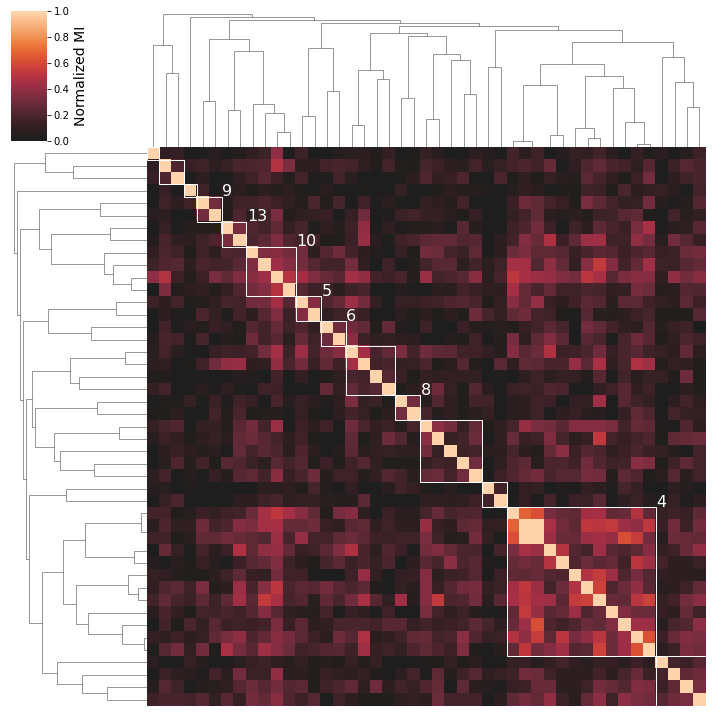

[AgglomerativeClustering(affinity='precomputed', compute_full_tree=True,
                         distance_threshold=0.9750000000000001,
                         linkage='complete', n_clusters=None)]

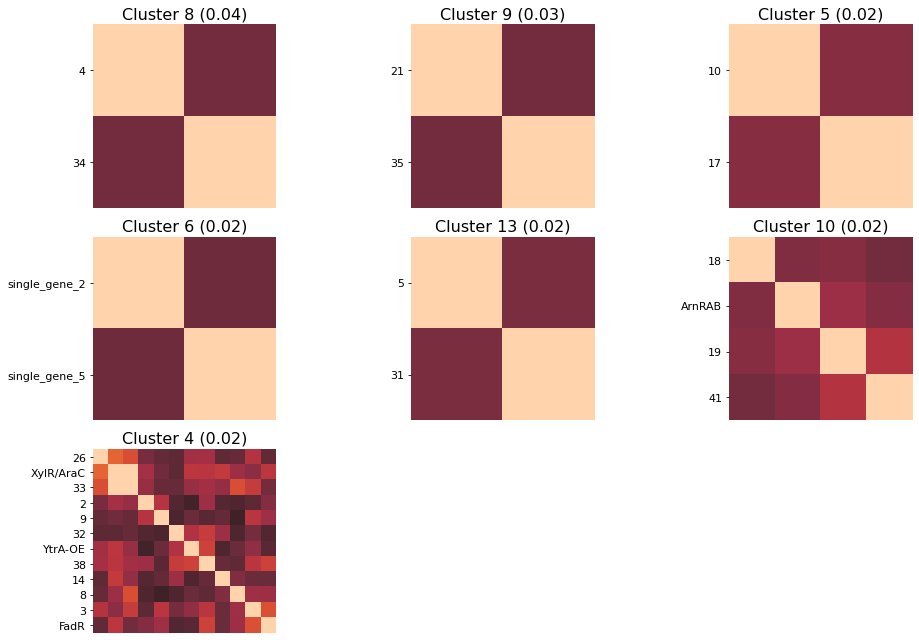

In [33]:
cluster_activities(ica_data,correlation_method='mutual_info',show_best_clusters=True)

You can investigate components with high correlations or mutual information scores to identify interactions between iModulons

<AxesSubplot:xlabel='4 iModulon Activity', ylabel='34 iModulon Activity'>

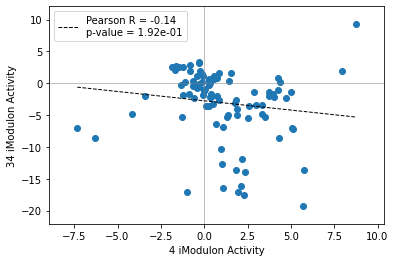

In [34]:
compare_activities(ica_data, 4, 34)

<AxesSubplot:xlabel='21 iModulon Activity', ylabel='35 iModulon Activity'>

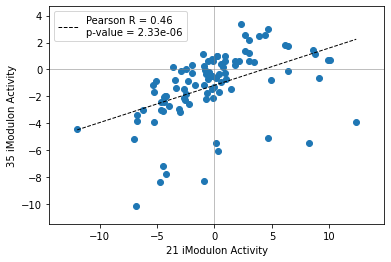

In [35]:
compare_activities(ica_data, 21, 35)

<AxesSubplot:xlabel='10 iModulon Activity', ylabel='17 iModulon Activity'>

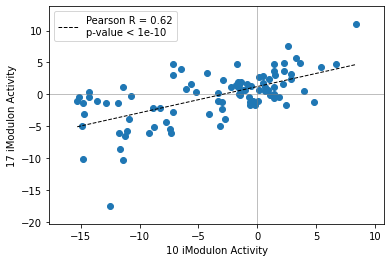

In [36]:
compare_activities(ica_data, 10, 17)

<AxesSubplot:xlabel='single_gene_2 iModulon Activity', ylabel='single_gene_5 iModulon Activity'>

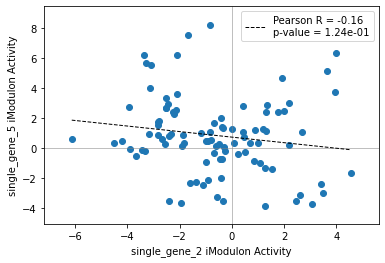

In [37]:
compare_activities(ica_data, 'single_gene_2', 'single_gene_5')

<AxesSubplot:xlabel='5 iModulon Activity', ylabel='31 iModulon Activity'>

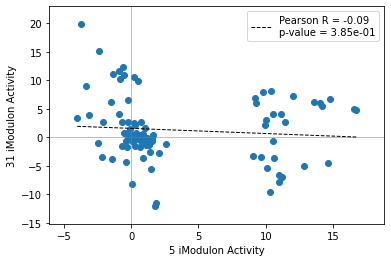

In [38]:
compare_activities(ica_data, 5, 31)

# Use metadata to automatically characterize iModulons

<AxesSubplot:xlabel='2'>

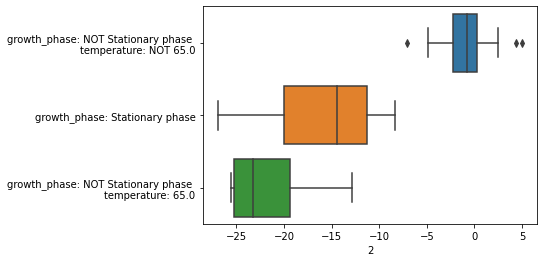

In [39]:
metadata_boxplot(ica_data,2)

<AxesSubplot:xlabel='2'>

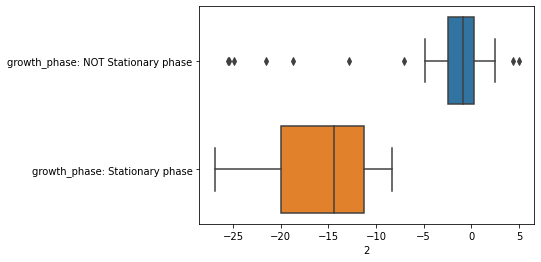

In [40]:
metadata_boxplot(ica_data,2,n_boxes=2)

# Compare against published iModulons
We can use the `compare_ica` function to compare iModulons across different organisms. To do so, you must provide the path to a Bidirection Best Hist CSV between your two organisms of interest.

A Github repository containing many BBH CSV's can be found at the following
link: https://github.com/SBRG/modulome_compare_data/tree/master/bbh_csv

You can also provide a path to your own BBH file, as long as it contains the
columns "**gene**" and "**target**"

See the `Tutorial.ipynb` notebook for more information

In [41]:
from pymodulon.compare import *
from pymodulon.io import *

In [42]:
ecoli_data = load_json_model('../example_data/example.json')

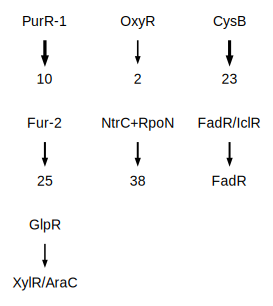

In [43]:
dots,links = compare_ica(ecoli_data.M, ica_data.M, cutoff=0.3,
                         ortho_file = '../example_data/example_bbh.csv')
dots

In the above plot, the top named iModulons are from *E. coli* and the bottom iModulons are from our target organism. Note that the two FadR iModulons are linked together. This `links` variable contains all pairs of iModulons that are linked together

In [44]:
links

[('GlpR', 'XylR/AraC', 0.3067430727683905),
 ('OxyR', 2, 0.32441595386469374),
 ('PurR-1', 10, 0.653352355479828),
 ('CysB', 23, 0.6176360657152684),
 ('NtrC+RpoN', 38, 0.3907067688896173),
 ('Fur-2', 25, 0.4045954149766546),
 ('FadR/IclR', 'FadR', 0.397506915185541)]

In [45]:
for ecoli_mod,target_mod,dist in links:
    ica_data.imodulon_table.loc[target_mod,'ecoli_ortholog'] = ecoli_mod
ica_data.imodulon_table

regulator        pvalue        qvalue  precision  \
0                               NaN           NaN           NaN        NaN   
1                               NaN           NaN           NaN        NaN   
2                               NaN           NaN           NaN        NaN   
3                               NaN           NaN           NaN        NaN   
4                               NaN           NaN           NaN        NaN   
5                               NaN           NaN           NaN        NaN   
6                               NaN           NaN           NaN        NaN   
7                               NaN           NaN           NaN        NaN   
8                               NaN           NaN           NaN        NaN   
9                               NaN           NaN           NaN        NaN   
10                              NaN           NaN           NaN        NaN   
XylR/AraC            XylR/XylR;AraC  3.698761e-10  4.993328e-08   0.360000   
YtrA-OE                     YtrA-OE  2.737665e-13  3.695848e-11   0.562500   
LysM                           LysM  6.324328e-09  8.411356e-07   0.571429   
14                              NaN           NaN           NaN        NaN   
single_gene_1                   NaN           NaN           NaN        NaN   
single_gene_2                   NaN           NaN           NaN        NaN   
17                              NaN           NaN           NaN        NaN   
18                              NaN           NaN           NaN        NaN   
19                              NaN           NaN           NaN        NaN   
20                              NaN           NaN           NaN        NaN   
21                              NaN           NaN           NaN        NaN   
22                              NaN           NaN           NaN        NaN   
23                              NaN           NaN           NaN        NaN   
single_gene_3                   NaN           NaN           NaN        NaN   
25                              NaN           NaN           NaN        NaN   
26                              NaN           NaN           NaN        NaN   
ArnRAB         ArnR;ArnR1+ArnA;ArnB  9.674248e-19  1.168520e-18   0.875000   
single_gene_4                   NaN           NaN           NaN        NaN   
FadR                           FadR  1.349778e-37  1.795205e-35   0.791667   
30                              NaN           NaN           NaN        NaN   
31                              NaN           NaN           NaN        NaN   
32                              NaN           NaN           NaN        NaN   
33                              NaN           NaN           NaN        NaN   
34                              NaN           NaN           NaN        NaN   
35                              NaN           NaN           NaN        NaN   
36                              NaN           NaN           NaN        NaN   
37                              NaN           NaN           NaN        NaN   
38                              NaN           NaN           NaN        NaN   
39                              NaN           NaN           NaN        NaN   
single_gene_5                   NaN           NaN           NaN        NaN   
41                              NaN           NaN           NaN        NaN   
42                              NaN           NaN           NaN        NaN   
single_gene_6                   NaN           NaN           NaN        NaN   
44                              NaN           NaN           NaN        NaN   

                 recall   f1score    TP  regulon_size  imodulon_size  n_regs  \
0                   NaN       NaN   NaN           NaN            NaN     NaN   
1                   NaN       NaN   NaN           NaN            NaN     NaN   
2                   NaN       NaN   NaN           NaN            NaN     NaN   
3                   NaN       NaN   NaN           NaN            NaN     NaN   
4                   NaN       NaN   N

## Visualize linked iModulons

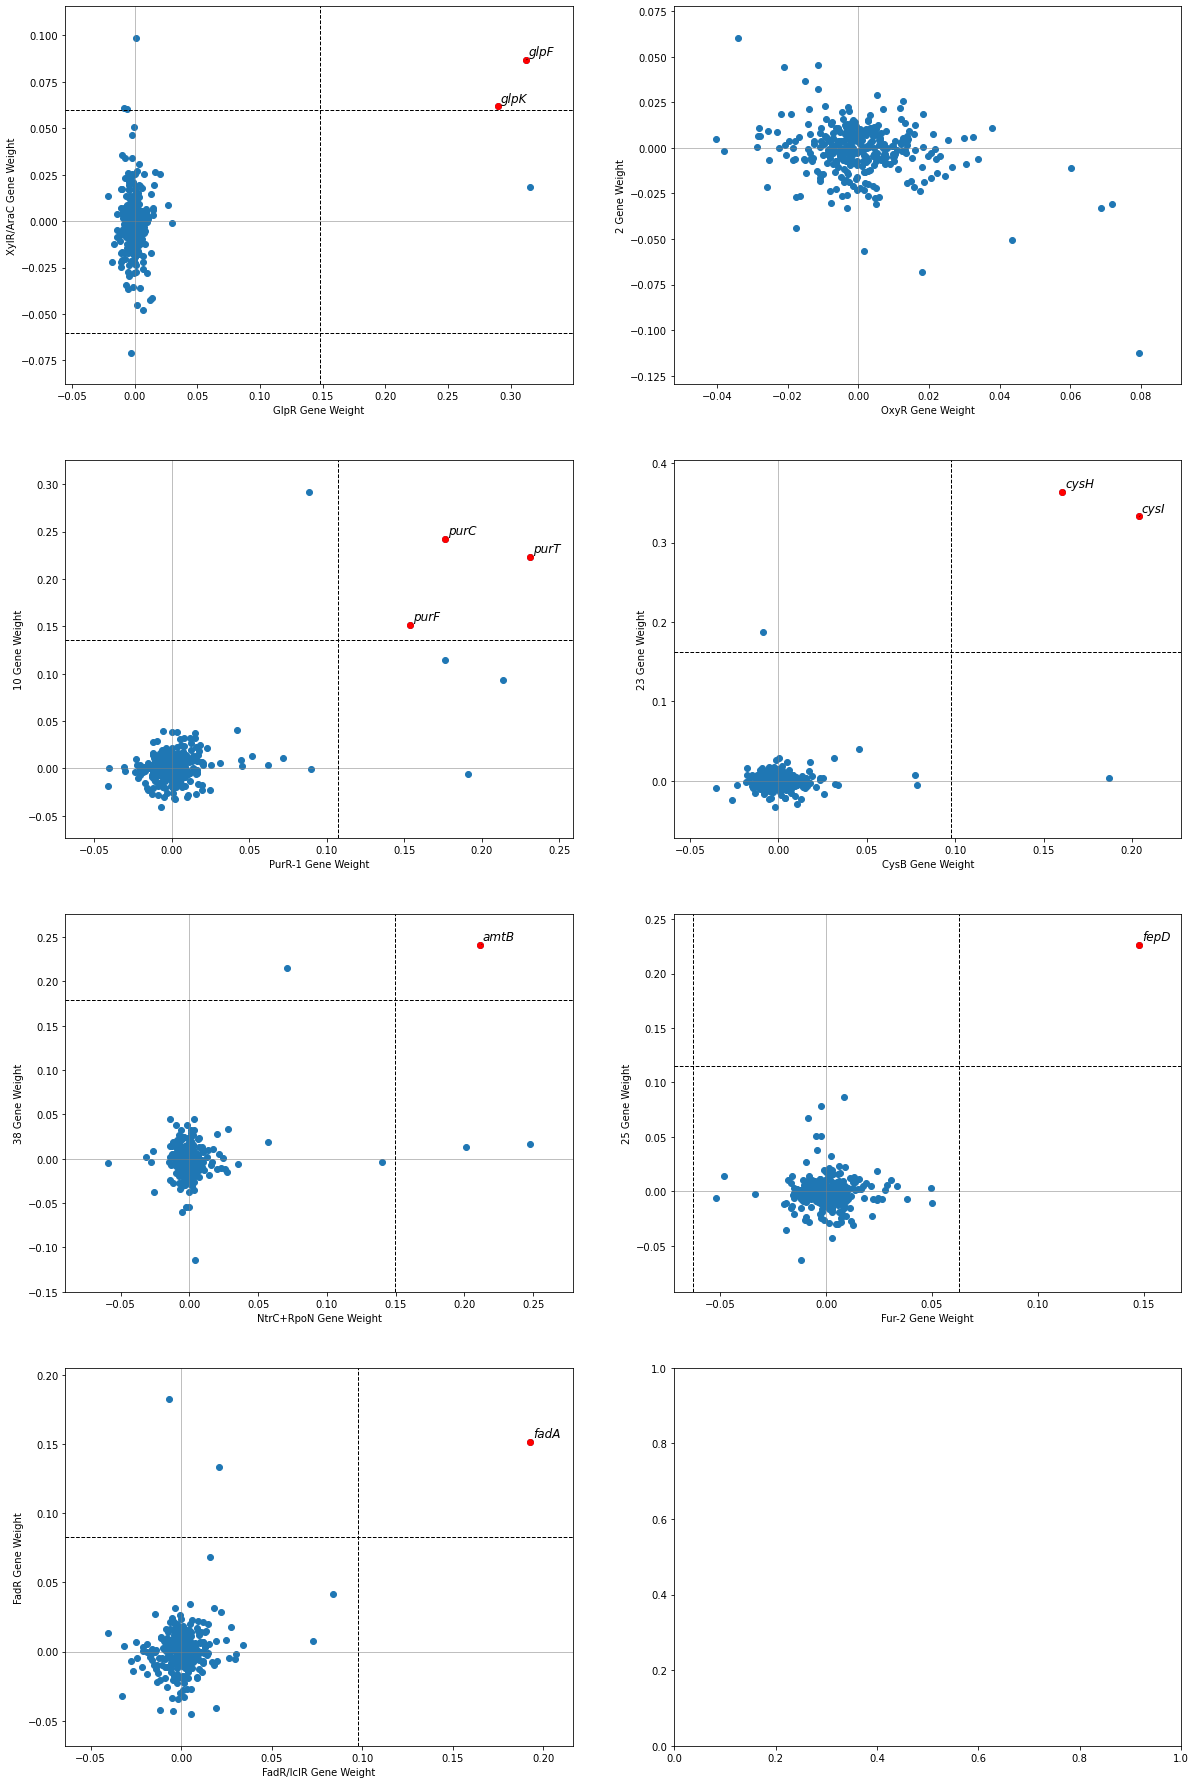

In [46]:
# Number of Rows:
num_rows = np.int(np.ceil(len(links) / 2))

# Plot figures
fig, axs = plt.subplots(nrows=num_rows, ncols=2, figsize=(20, 8*num_rows))

counter = 0
for ecoli_mod,saci_mod,_ in links:
    
    if counter % 2 == 0:
        r = np.int(counter / 2)
        c = 0
    else:
        r = np.int((counter - 1) / 2)
        c = 1
    
    compare_gene_weights(ica_data = ecoli_data,imodulon1=ecoli_mod,
                         ica_data2 = ica_data,imodulon2=saci_mod,
                         ortho_file ='../example_data/example_bbh.csv',
                         ax=axs[r, c])
    
    counter += 1

---

# Characterize iModulons

## Known iModulons

These iModulons are fully characterized and match what is known in literature. In particular, ArnRAB, FadR, and FadR-KO iModulons can be used as literature-validation iModulons.

### iModulon 27: ArnRAB

**The Archaellum Regulatory Network iModulon:**

Contains the Arn operon genes (Saci_1172 to Saci_1179). This operon, activated by ArnR/ArnR1 and repressed by ArnA/ArnB, is necessary for the generation of archaella, bacterial type-IV pili that function as flagella for this organism.

This iModulon differs from its regulons as it does not contain the transcription factors ArnR, ArnR1, ArnS, ArnA, ArnB and their phosphorylators ArnC, ArnD, Saci_pp2a, Saci_1208, and Saci_1209

As expected from literature, this iModulon's activity increases during nutrient limitation conditions and is generally higher in the stationary phase vs log phase as archaella are used by Saci to move around and find food in their environment.

<AxesSubplot:xlabel='Gene Start', ylabel='ArnRAB Gene Weight'>

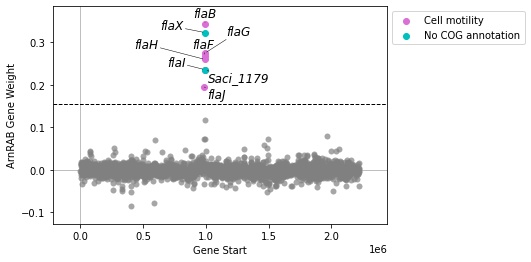

In [47]:
plot_gene_weights(ica_data, 'ArnRAB')

<AxesSubplot:ylabel='ArnRAB iModulon\nActivity'>

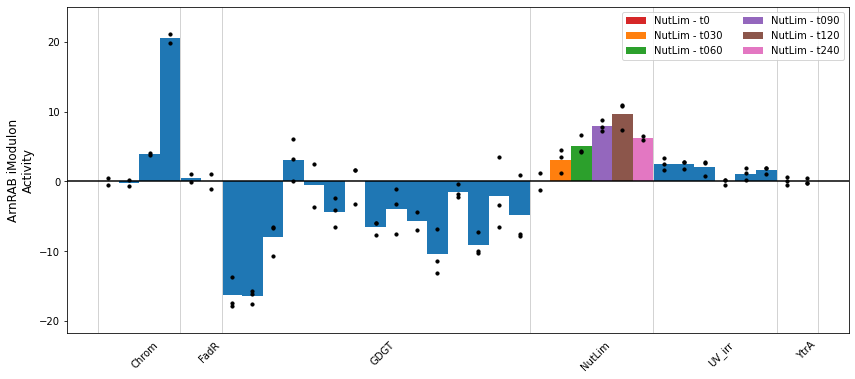

In [48]:
fig, ax = plt.subplots(figsize=(14, 6))

plot_activities(ica_data, 'ArnRAB', highlight='NutLim', ax=ax)

### iModulon 29: FadR  [E coli Ortholog: FadR/IclR]

**Fatty Acid Degradation Repressor iModulon**

Contains the FadR gene cluster, as well as a few other acyl-CoA ligases. Notably does not contain the fadR gene itself. FadR is a repressor that inhibits fatty acid breakdown genes from activating unless there is a high concentration of medium- to long-chain acyl-CoA in the cytosol.

This iModulon also does not contains 13 genes found in the regulon, many being hyrolases and short-chain-dehydrogenase oxidoreductases. This suggests that short-chain fatty acids may be regulated by another transcription factor. Additionally, the iModulon contains 6 genes that are not in the regulon, all of which are hypothetical proteins with little known about them.

The FadR iModulon has its highest activity in fadR deletion strains in both the `Chrom` and `FadR` projects, with the `NutLim` project being fairly high as well. This suggests that the iModulon is upregulated when the FadR gene cluster is actively expressed (i.e. high conc of med- and long-chain acyl-CoA or during nutrient limitation when fatty acids must be broken down as an alternative energy source).

<AxesSubplot:xlabel='Gene Start', ylabel='FadR Gene Weight'>

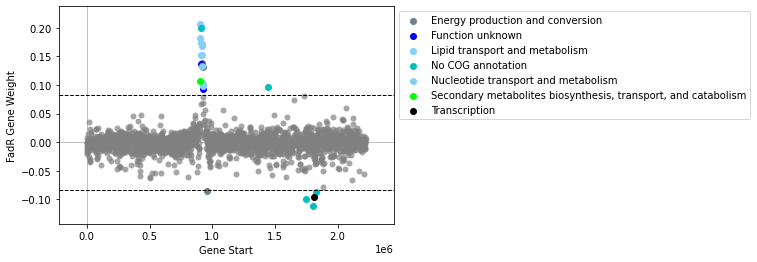

In [49]:
plot_gene_weights(ica_data, 'FadR')

<AxesSubplot:ylabel='FadR iModulon\nActivity'>

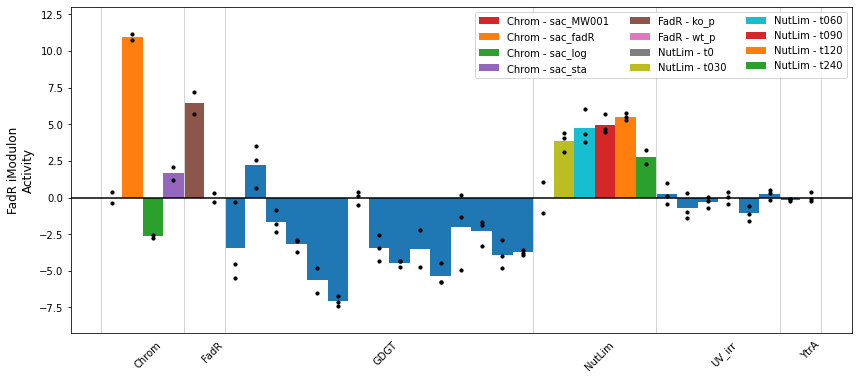

In [50]:
fig, ax = plt.subplots(figsize=(14, 6))

plot_activities(ica_data, 'FadR', highlight=['Chrom', 'FadR', 'NutLim'], ax=ax)

### iModulon 24: FadR-KO iModulon (single_gene_3)

**FadR TF iModulon**

Contains only 1 gene, __Saci_1107__, which codes for FadR

The activity of this iModulon is similar to the FadR iModulon, with the notable exception of the FadR-KO experiment having a substantially negative activity.

In [51]:
ica_data.rename_imodulons({'single_gene_3':'FadR-KO'})

<AxesSubplot:xlabel='Gene Start', ylabel='FadR-KO Gene Weight'>

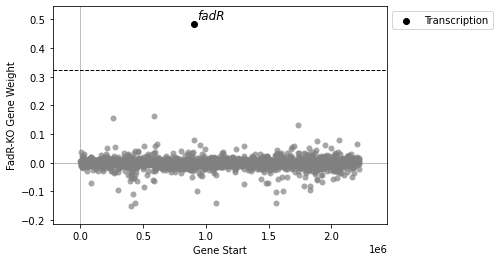

In [52]:
plot_gene_weights(ica_data, 'FadR-KO')

<AxesSubplot:ylabel='FadR-KO iModulon\nActivity'>

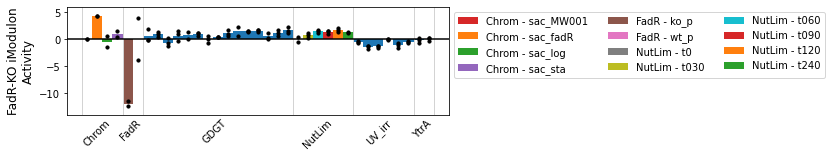

In [53]:
plot_activities(ica_data, 'FadR-KO', highlight=['Chrom', 'FadR', 'NutLim'])

## Regulon-matching iModulons

These iModulons match closely with a regulon from the manually curated TRN file (based on known literature) and were chosen via trn enrichment (See Regulatory-iModulons section)

### iModulon 11: XylR/AraC-matching iModulon [E. coli ortholog: GlpR]

### Composite iModulon 3 (Putative Ketone-body + Cytochrome + XylR/AraC + GlpR iModulon)

In [54]:
get_kegg_enrichements('XylR/AraC', 'pathway')

imodulon   kegg_id    pvalue    qvalue  precision    recall   f1score  \
16  XylR/AraC  map00072  0.000819  0.036456   0.300000  0.065217  0.107143   
17  XylR/AraC  map00310  0.000819  0.036456   0.300000  0.065217  0.107143   
18  XylR/AraC  map00380  0.001110  0.036456   0.272727  0.065217  0.105263   
19  XylR/AraC  map00620  0.001008  0.036456   0.125000  0.108696  0.116279   
20  XylR/AraC  map00640  0.000348  0.036456   0.156250  0.108696  0.128205   
21  XylR/AraC  map00720  0.000523  0.036456   0.113208  0.130435  0.121212   
22  XylR/AraC  map00362  0.001460  0.041081   0.250000  0.065217  0.103448   
23  XylR/AraC  map02020  0.002894  0.071268   0.200000  0.065217  0.098361   
24  XylR/AraC  map00900  0.003512  0.076881   0.187500  0.065217  0.096774   

     TP  target_set_size  imodulon_size  \
16  3.0             10.0           46.0   
17  3.0             10.0           46.0   
18  3.0             11.0           46.0   
19  5.0             40.0           46.0   
20  5.0             32.0           46.0   
21  6.0             53.0           46.0   
22  3.0             12.0           46.0   
23  3.0             15.0           46.0   
24  3.0             16.0           46.0   

                                  pathway_name  
16  Synthesis and degradation of ketone bodies  
17                          Lysine degradation  
18                       Tryptophan metabolism  
19                         Pyruvate metabolism  
20                       Propanoate metabolism  
21     Carbon fixation pathways in prokaryotes  
22                        Benzoate degradation  
23                        Two-component system  
24             Terpenoid backbone biosynthesis

In [55]:
get_kegg_enrichements('XylR/AraC', 'module')

imodulon kegg_id    pvalue    qvalue  precision    recall   f1score   TP  \
14  XylR/AraC  M00088  0.000819  0.046409   0.300000  0.065217  0.107143  3.0   
15  XylR/AraC  M00373  0.000819  0.046409   0.300000  0.065217  0.107143  3.0   
16  XylR/AraC  M00416  0.000393  0.046409   1.000000  0.043478  0.083333  2.0   
17  XylR/AraC  M00155  0.001163  0.049447   0.666667  0.043478  0.081633  2.0   
18  XylR/AraC  M00095  0.001871  0.057574   0.230769  0.065217  0.101695  3.0   
19  XylR/AraC  M00375  0.002032  0.057574   0.142857  0.086957  0.108108  4.0   
20  XylR/AraC  M00374  0.002988  0.072575   0.129032  0.086957  0.103896  4.0   

    target_set_size  imodulon_size  \
14             10.0           46.0   
15             10.0           46.0   
16              2.0           46.0   
17              3.0           46.0   
18             13.0           46.0   
19             28.0           46.0   
20             31.0           46.0   

                                          module_name  
14  Ketone body biosynthesis, acetyl-CoA => acetoa...  
15                               Ethylmalonyl pathway  
16              Cytochrome aa3-600 menaquinol oxidase  
17                  Cytochrome c oxidase, prokaryotes  
18     C5 isoprenoid biosynthesis, mevalonate pathway  
19            Hydroxypropionate-hydroxybutylate cycle  
20                Dicarboxylate-hydroxybutyrate cycle

<AxesSubplot:xlabel='Gene Start', ylabel='XylR/AraC Gene Weight'>

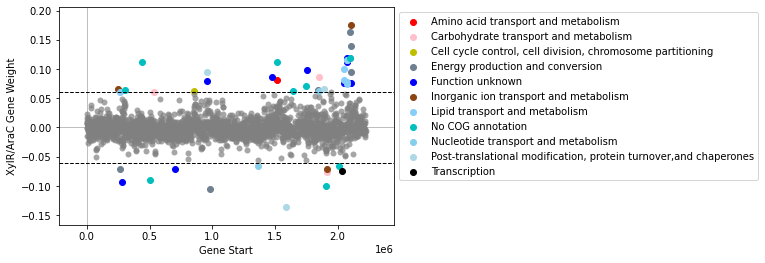

In [56]:
plot_gene_weights(ica_data, 'XylR/AraC')

In [57]:
ica_data.view_imodulon('XylR/AraC')

gene_weight     gene_name old_locus_tag prokka_locus_tag  \
SACI_RS01445     0.066414        moaA_1     Saci_0296      Sacid_00292   
SACI_RS01495     0.060348        acsA_1     Saci_0306      Sacid_00302   
SACI_RS01505    -0.071221     Saci_0308     Saci_0308      Sacid_00304   
SACI_RS01585    -0.093007     Saci_0324     Saci_0324      Sacid_00320   
SACI_RS01760     0.063850     Saci_0360     Saci_0360      Sacid_00355   
SACI_RS11800     0.111932  SACI_RS11800           NaN              NaN   
SACI_RS11555    -0.090678  SACI_RS11555           NaN              NaN   
SACI_RS03215     0.061065        abaF_1     Saci_0675      Sacid_00657   
SACI_RS11610    -0.070474     Saci_0873     Saci_0873      Sacid_00851   
SACI_RS05015     0.061516          parA     Saci_1050      Sacid_01024   
SACI_RS05465     0.094589     Saci_1147     Saci_1147      Sacid_01123   
SACI_RS05470     0.078684     Saci_1148     Saci_1148      Sacid_01124   
SACI_RS05570    -0.104995        trxB_2     Saci_1169      Sacid_01146   
SACI_RS07620    -0.065957          pyrE     Saci_1597      Sacid_01562   
SACI_RS08185     0.086621          thpS     Saci_1714      Sacid_01677   
SACI_RS08385     0.112419     Saci_1754     Saci_1754      Sacid_01719   
SACI_RS08415     0.081152     Saci_1760     Saci_1760      Sacid_01725   
SACI_RS08740    -0.135610          trxA     Saci_1823      Sacid_01792   
SACI_RS08970     0.061715     Saci_1866     Saci_1866      Sacid_01839   
SACI_RS09325     0.071392     Saci_1933     Saci_1933      Sacid_01917   
SACI_RS09385     0.098682          satP     Saci_1944      Sacid_01930   
SACI_RS09825     0.064261        glpA_2     Saci_2032      Sacid_02027   
SACI_RS09830     0.061694        glpK_3     Saci_2033      Sacid_02028   
SACI_RS09835     0.086722          glpF     Saci_2034      Sacid_02029   
SACI_RS10015     0.065600     Saci_2072     Saci_2072      Sacid_02067   
SACI_RS10110    -0.100012     Saci_2093     Saci_2093      Sacid_02089   
SACI_RS10115    -0.070970        mntH_2     Saci_2094      Sacid_02090   
SACI_RS10120    -0.076173        xylE_2     Saci_2095      Sacid_02091   
SACI_RS10515    -0.066079     Saci_2175     Saci_2175      Sacid_02173   
SACI_RS10600    -0.074045     Saci_2193     Saci_2193      Sacid_02192   
SACI_RS10675     0.100440        fadJ_4     Saci_2208      Sacid_02209   
SACI_RS10680     0.080557          fadI     Saci_2209      Sacid_02210   
SACI_RS10685     0.075305     Saci_2210     Saci_2210      Sacid_02211   
SACI_RS10780     0.111437     Saci_2230     Saci_2230      Sacid_02231   
SACI_RS10785     0.118350     Saci_2231     Saci_2231      Sacid_02232   
SACI_RS10790     0.115935     Saci_2232     Saci_2232      Sacid_02233   
SACI_RS10795     0.115060     Saci_2233     Saci_2233      Sacid_02234   
SACI_RS10800     0.073791        mmgC_3     Saci_2234      Sacid_02235   
SACI_RS10805     0.077007        acsA_5     Saci_2235      Sacid_02236   
SACI_RS10920     0.118762     Saci_2258     Saci_2258      Sacid_02259   
SACI_RS10925     0.118676          ctaC     Saci_2259      Sacid_02260   
SACI_RS10930     0.163053          fbcH     Saci_2260      Sacid_02261   
SACI_RS10935     0.174414          aioB     Saci_2261      Sacid_02262   
SACI_RS10940     0.139025        soxE_2     Saci_2262      Sacid_02263   
SACI_RS10945     0.095193          caaA     Saci_2263      Sacid_02264   
SACI_RS10950     0.076821     Saci_2264     Saci_2264      Sacid_02265   

             synonyms      start        end strand  \
SACI_RS01445      NaN   251845.0   252864.0      -   
SACI_RS01495      acs   260644.0   262641.0      -   
SACI_RS01505      NaN   263557.0   263805.0      +   
SACI_RS01585      NaN   277460.0   278311.0      -   
SACI_RS01760      NaN   303121.0   304209.0      +   
SACI_RS11800      NaN   442246.0   442317.0      -   
SACI_RS11555      NaN   499991.0   500131.0      +   
SACI_RS03215      NaN   535612.0   536928.0      -   
SACI_RS11610      NaN   700810.0   700977.0      

### iModulon 12: YtrA-OE iModulon

### Putative GTP/G-Protein-Coupled-Receptor / Metal Uptake iModulon 

<AxesSubplot:xlabel='Gene Start', ylabel='YtrA-OE Gene Weight'>

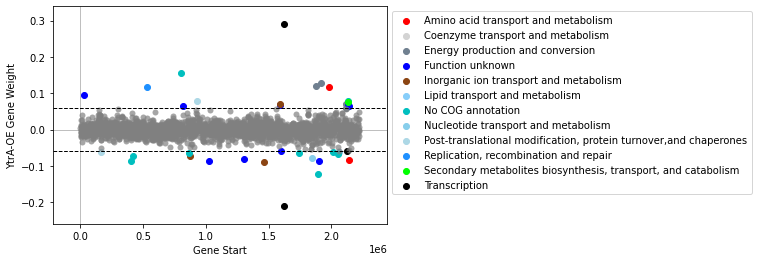

In [58]:
plot_gene_weights(ica_data, 'YtrA-OE')

In [206]:
ica_data.view_imodulon('YtrA-OE').sort_values(by='gene_weight')

gene_weight     gene_name old_locus_tag prokka_locus_tag  \
SACI_RS08875    -0.209938     Saci_1850     Saci_1850      Sacid_01819   
SACI_RS10045    -0.123343     Saci_2078     Saci_2078      Sacid_02074   
SACI_RS08155    -0.090543     Saci_1707     Saci_1707      Sacid_01671   
SACI_RS02340    -0.087781     Saci_0484     Saci_0484      Sacid_00477   
SACI_RS10055    -0.086565     Saci_2080     Saci_2080      Sacid_02076   
SACI_RS05730    -0.085849          msrP     Saci_1202      Sacid_01180   
SACI_RS11105    -0.084472          hpaD     Saci_2295      Sacid_02297   
SACI_RS07300    -0.081091  SACI_RS07300           NaN      Sacid_01497   
SACI_RS09830    -0.079030        glpK_3     Saci_2033      Sacid_02028   
SACI_RS02440    -0.073582     Saci_0506     Saci_0506      Sacid_00500   
SACI_RS05090    -0.072732        btuD_6     Saci_1066      Sacid_01042   
SACI_RS10705    -0.068572     Saci_2214     Saci_2214      Sacid_02215   
SACI_RS09315    -0.065431     Saci_1931     Saci_1931      Sacid_01913   
SACI_RS05085    -0.063764     Saci_1065     Saci_1065      Sacid_01041   
SACI_RS10515    -0.062562     Saci_2175     Saci_2175      Sacid_02173   
SACI_RS10730    -0.061748     Saci_2219     Saci_2219      Sacid_02221   
SACI_RS00955    -0.061389     Saci_0198     Saci_0198      Sacid_00192   
SACI_RS08785    -0.060433     Saci_1832     Saci_1832      Sacid_01801   
SACI_RS11050    -0.059474          patZ     Saci_2284      Sacid_02286   
SACI_RS10995     0.059654          glpC     Saci_2273      Sacid_02274   
SACI_RS04865     0.063848     Saci_1019     Saci_1019      Sacid_00992   
SACI_RS11115     0.064014     Saci_2297     Saci_2297      Sacid_02299   
SACI_RS08730     0.067329     Saci_1821     Saci_1821      Sacid_01790   
SACI_RS11080     0.068728          paaK     Saci_2290      Sacid_02292   
SACI_RS11085     0.069037     Saci_2291     Saci_2291      Sacid_02293   
SACI_RS10990     0.069651          rbr1     Saci_2272      Sacid_02273   
SACI_RS08735     0.069692     Saci_1822     Saci_1822      Sacid_01791   
SACI_RS11075     0.077046     Saci_2289     Saci_2289      Sacid_02291   
SACI_RS11090     0.077651     Saci_2292     Saci_2292      Sacid_02294   
SACI_RS05365     0.078384         bcp_1     Saci_1125      Sacid_01101   
SACI_RS00195     0.094740       IMPDH_1     Saci_0044      Sacid_00042   
SACI_RS10385     0.116374          asd2     Saci_2147      Sacid_02145   
SACI_RS03165     0.117220     Saci_0664     Saci_0664      Sacid_00646   
SACI_RS09945     0.120530         adh_2     Saci_2057      Sacid_02052   
SACI_RS11760     0.126987  SACI_RS11760           NaN      Sacid_02092   
SACI_RS04795     0.156636     Saci_1004     Saci_1004      Sacid_00978   
SACI_RS08880     0.289464          ytrA     Saci_1851      Sacid_01820   

             synonyms      start        end strand  \
SACI_RS08875      NaN  1620502.0  1621581.0      -   
SACI_RS10045      NaN  1897287.0  1897949.0      +   
SACI_RS08155      NaN  1465796.0  1466929.0      +   
SACI_RS02340      NaN   404875.0   405324.0      +   
SACI_RS10055      NaN  1898342.0  1898716.0      +   
SACI_RS05730      NaN  1023450.0  1024052.0      +   
SACI_RS11105     bphC  2139102.0  2140043.0      -   
SACI_RS07300      NaN  1305203.0  1306027.0      -   
SACI_RS09830     glpK  1847704.0  1849197.0      +   
SACI_RS02440      NaN   419872.0   420159.0      -   
SACI_RS05090      NaN   869942.0   870712.0      +   
SACI_RS10705      NaN  2054663.0  2056171.0      -   
SACI_RS09315      NaN  1742374.0  1742790.0      +   
SACI_RS05085      NaN   869143.0   869940.0      +   
SACI_RS10515      NaN  2010026.0  2010583.0      +   
SACI_RS10730      NaN  2063298.0  2063792.0      -   
SACI_RS00955      NaN   160314.0   162212.0      +   
SACI_RS08785      NaN  1597685.0  1598296.0      -   
SACI_RS11050      NaN  2128847.0  2129314.0      -   
SACI_RS10995      NaN  2115058.0  2116251.0      +   
SACI_RS04865      NaN   818942.0   819370.0      +   
SACI_RS11115 

### iModulon 13: LysM iModulon (Lysine biosynthesis, Putative Val/Ile biosynthesis)

In [60]:
get_kegg_enrichements('LysM', 'pathway')

imodulon   kegg_id        pvalue        qvalue  precision  recall  \
25     LysM  map01210  2.320941e-10  4.572255e-08   0.230769     0.6   
26     LysM  map01230  4.638471e-07  4.568894e-05   0.068966     0.6   
27     LysM  map00290  1.283633e-05  8.429188e-04   0.250000     0.3   
28     LysM  map00300  2.636557e-05  1.298504e-03   0.200000     0.3   
29     LysM  map01100  2.963728e-04  1.167709e-02   0.017903     0.7   
30     LysM  map00660  6.049418e-04  1.986226e-02   0.222222     0.2   
31     LysM  map00220  1.298557e-03  3.654511e-02   0.153846     0.2   
32     LysM  map00966  4.355401e-03  9.982140e-02   1.000000     0.1   
33     LysM  map01110  4.560368e-03  9.982140e-02   0.023121     0.4   

     f1score   TP  target_set_size  imodulon_size  \
25  0.333333  6.0             26.0           10.0   
26  0.123711  6.0             87.0           10.0   
27  0.272727  3.0             12.0           10.0   
28  0.240000  3.0             15.0           10.0   
29  0.034913  7.0            391.0           10.0   
30  0.210526  2.0              9.0           10.0   
31  0.173913  2.0             13.0           10.0   
32  0.181818  1.0              1.0           10.0   
33  0.043716  4.0            173.0           10.0   

                                   pathway_name  
25              2-Oxocarboxylic acid metabolism  
26                  Biosynthesis of amino acids  
27  Valine, leucine and isoleucine biosynthesis  
28                          Lysine biosynthesis  
29                           Metabolic pathways  
30          C5-Branched dibasic acid metabolism  
31                        Arginine biosynthesis  
32                   Glucosinolate biosynthesis  
33        Biosynthesis of secondary metabolites

In [61]:
get_kegg_enrichements('LysM', 'module')

imodulon kegg_id        pvalue    qvalue  precision  recall   f1score   TP  \
21     LysM  M00031  6.324328e-09  0.000001   0.571429     0.4  0.470588  4.0   
22     LysM  M00432  1.183116e-06  0.000067   0.500000     0.3  0.375000  3.0   
23     LysM  M00763  1.183116e-06  0.000067   0.500000     0.3  0.375000  3.0   
24     LysM  M00535  5.112088e-05  0.002173   0.666667     0.2  0.307692  2.0   

    target_set_size  imodulon_size  \
21              7.0           10.0   
22              6.0           10.0   
23              6.0           10.0   
24              3.0           10.0   

                                          module_name  
21  Lysine biosynthesis, mediated by LysW, 2-amino...  
22  Leucine biosynthesis, 2-oxoisovalerate => 2-ox...  
23  Ornithine biosynthesis, mediated by LysW, glut...  
24  Isoleucine biosynthesis, pyruvate => 2-oxobuta...

<AxesSubplot:xlabel='Gene Start', ylabel='LysM Gene Weight'>

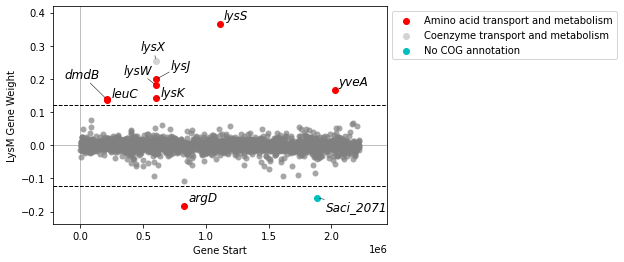

In [62]:
plot_gene_weights(ica_data, 'LysM')

## KEGG enrichment-matching iModulons

These iModulons map closely to KEGG enrichment pathways and/or modules

In [63]:
p = set(DF_pathway_enrich.dropna()['imodulon'])
m = set(DF_module_enrich.dropna()['imodulon'])

print('Pathways only: ', p-m)
print('Modules only: ', m-p)
print('Pathways & Modules: ', p.intersection(m))

Pathways only:  {25, 26, 39}
Modules only:  set()
Pathways & Modules:  {4, 'LysM', 7, 9, 10, 17, 19, 21, 23, 'XylR/AraC', 31}


### iModulon 25: Putative Cobalamin (Vit B12) iModulon [E coli Ortholog Fur-2]

In [64]:
get_kegg_enrichements(25, 'pathway')

imodulon   kegg_id    pvalue    qvalue  precision  recall   f1score   TP  \
43       25  map02010  0.000013  0.002529       0.25     0.3  0.272727  3.0   

    target_set_size  imodulon_size      pathway_name  
43             12.0           10.0  ABC transporters

<AxesSubplot:xlabel='Gene Start', ylabel='25 Gene Weight'>

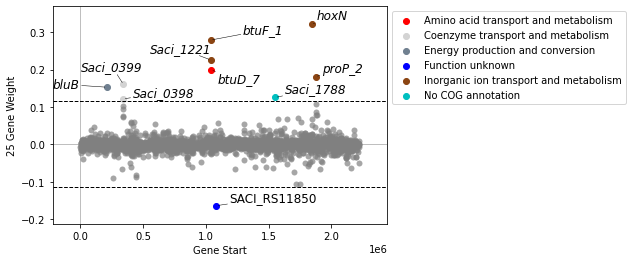

In [65]:
plot_gene_weights(ica_data, 25)

In [66]:
ica_data.view_imodulon(25)

gene_weight     gene_name old_locus_tag prokka_locus_tag  \
SACI_RS01220     0.152986          bluB     Saci_0250      Sacid_00247   
SACI_RS01950     0.121632     Saci_0398     Saci_0398      Sacid_00394   
SACI_RS01955     0.160739     Saci_0399     Saci_0399      Sacid_00395   
SACI_RS05815     0.279215        btuF_1     Saci_1220      Sacid_01197   
SACI_RS05820     0.225851     Saci_1221     Saci_1221      Sacid_01198   
SACI_RS05825     0.198915        btuD_7     Saci_1222      Sacid_01199   
SACI_RS11850    -0.164215  SACI_RS11850           NaN              NaN   
SACI_RS08550     0.125567     Saci_1788     Saci_1788      Sacid_01754   
SACI_RS09805     0.320933          hoxN     Saci_2028      Sacid_02022   
SACI_RS09950     0.181118        proP_2     Saci_2058      Sacid_02053   

             synonyms      start        end strand  \
SACI_RS01220      NaN   209952.0   210617.0      +   
SACI_RS01950      NaN   341130.0   341885.0      -   
SACI_RS01955      NaN   341882.0   342883.0      -   
SACI_RS05815      NaN  1038318.0  1039313.0      +   
SACI_RS05820      NaN  1039531.0  1040529.0      +   
SACI_RS05825      NaN  1040510.0  1041169.0      +   
SACI_RS11850      NaN  1083276.0  1083470.0      +   
SACI_RS08550      NaN  1553564.0  1555882.0      +   
SACI_RS09805      NaN  1842996.0  1844063.0      -   
SACI_RS09950      NaN  1875156.0  1876487.0      -   

                                                 gene_product  \
SACI_RS01220               5,6-dimethylbenzimidazole synthase   
SACI_RS01950             precorrin-3B C(17)-methyltransferase   
SACI_RS01955                        precorrin-8X methylmutase   
SACI_RS05815        ABC transporter substrate-binding protein   
SACI_RS05820                    iron ABC transporter permease   
SACI_RS05825              ABC transporter ATP-binding protein   
SACI_RS11850                             hypothetical protein   
SACI_RS08550                             hypothetical protein   
SACI_RS09805  HoxN/HupN/NixA family nickel/cobalt transporter   
SACI_RS09950                                  MFS transporter   

                                      gene_product_prokka  \
SACI_RS01220           5,6-dimethylbenzimidazole synthase   
SACI_RS01950          Cobalt-factor III methyltransferase   
SACI_RS01955                         hypothetical protein   
SACI_RS05815                  Vitamin B12-binding protein   
SACI_RS05820    putative ABC transporter permease protein   
SACI_RS05825  Vitamin B12 import ATP-binding protein BtuD   
SACI_RS11850                                          NaN   
SACI_RS08550                         hypothetical protein   
SACI_RS09805       High-affinity nickel transport protein   
SACI_RS09950                  Proline/betaine transporter   

                                                 COG     uniprot       refseq  \
SACI_RS01220        Energy production and conversion  A0A0U2X101  NC_007181.1   
SACI_RS01950       Coenzyme transport and metabolism  A0A0U3HBF9  NC_007181.1   
SACI_RS01955       Coenzyme transport and metabolism  A0A0U3H2U5  NC_007181.1   
SACI_RS05815  Inorganic ion transport and metabolism  A0A0U3H1G2  NC_007181.1   
SACI_RS05820  Inorganic ion transport and metabolism  A0A0U3GLY8  NC_007181.1   
SACI_RS05825     Amino acid transport and metabolism  A0A0U3HCP3  NC_007181.1   
SACI_RS11850                        Function unknown         NaN  NC_007181.1   
SACI_RS08550                       No COG annotation  A0A0U3H773  NC_007181.1   
SACI_RS09805  Inorganic ion transport and metabolism  A0A0U3H555  NC_007181.1   
SACI_RS09950  Inorganic ion transport and metabolism  A0A0U3GPF6  NC_007181.1   

             regulator  
SACI_RS01220       NaN  
SACI_RS01950       NaN  
SACI_RS01955       NaN  
SACI_RS05815       NaN  
SACI_RS05820       NaN  
SACI_RS05825       NaN  
SACI_RS11850       NaN  
SACI_RS08550       NaN  
SACI_RS09805       NaN  
SACI_RS09950       NaN

<AxesSubplot:ylabel='25 iModulon\nActivity'>

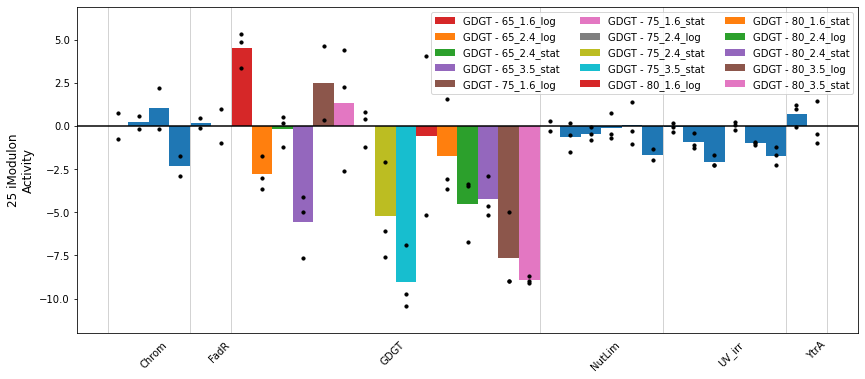

In [67]:
fig, ax = plt.subplots(figsize=(14, 6))

plot_activities(ica_data, 25, highlight='GDGT', ax=ax)

### iModulon 26: Putative Riboflavin-related iModulon 1

In [68]:
get_kegg_enrichements(26, 'pathway')

imodulon   kegg_id    pvalue    qvalue  precision    recall   f1score   TP  \
44       26  map01220  0.000166  0.032736   0.285714  0.285714  0.285714  2.0   

    target_set_size  imodulon_size                       pathway_name  
44              7.0            7.0  Degradation of aromatic compounds

<AxesSubplot:xlabel='Gene Start', ylabel='26 Gene Weight'>

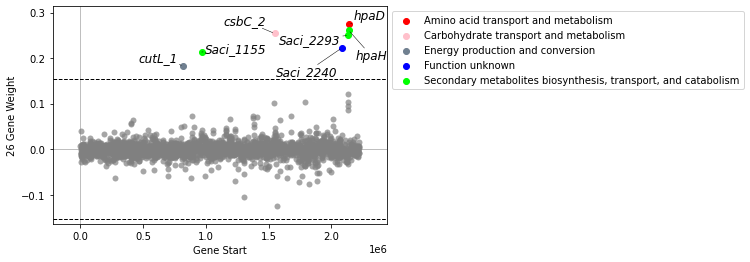

In [69]:
plot_gene_weights(ica_data, 26)

In [70]:
ica_data.view_imodulon(26)

gene_weight  gene_name old_locus_tag prokka_locus_tag synonyms  \
SACI_RS04870     0.182864     cutL_1     Saci_1020      Sacid_00993      NaN   
SACI_RS05500     0.213263  Saci_1155     Saci_1155      Sacid_01131      NaN   
SACI_RS08525     0.254069     csbC_2     Saci_1782      Sacid_01749      NaN   
SACI_RS10830     0.222119  Saci_2240     Saci_2240      Sacid_02241      NaN   
SACI_RS11095     0.249805  Saci_2293     Saci_2293      Sacid_02295      NaN   
SACI_RS11100     0.261034       hpaH     Saci_2294      Sacid_02296      NaN   
SACI_RS11105     0.273739       hpaD     Saci_2295      Sacid_02297     bphC   

                  start        end strand  \
SACI_RS04870   819407.0   821452.0      +   
SACI_RS05500   966891.0   967697.0      +   
SACI_RS08525  1547302.0  1548780.0      -   
SACI_RS10830  2082950.0  2083417.0      -   
SACI_RS11095  2136785.0  2137627.0      -   
SACI_RS11100  2137633.0  2139105.0      -   
SACI_RS11105  2139102.0  2140043.0      -   

                                                   gene_product  \
SACI_RS04870  xanthine dehydrogenase family protein molybdop...   
SACI_RS05500          acetoacetate decarboxylase family protein   
SACI_RS08525                                    MFS transporter   
SACI_RS10830                    flavin reductase family protein   
SACI_RS11095       fumarylacetoacetate hydrolase family protein   
SACI_RS11100  4-hydroxyphenylacetate 3-hydroxylase family pr...   
SACI_RS11105         3,4-dihydroxyphenylacetate 2,3-dioxygenase   

                                            gene_product_prokka  \
SACI_RS04870          Carbon monoxide dehydrogenase large chain   
SACI_RS05500                               hypothetical protein   
SACI_RS08525         putative metabolite transport protein CsbC   
SACI_RS10830                                   Flavin reductase   
SACI_RS11095                               hypothetical protein   
SACI_RS11100   Anthranilate 3-monooxygenase oxygenase component   
SACI_RS11105  Manganese-dependent 2,3-dihydroxybiphenyl 1,2-...   

                                                            COG     uniprot  \
SACI_RS04870                   Energy production and conversion  A0A0U3H1B1   
SACI_RS05500  Secondary metabolites biosynthesis, transport,...  A0A0U2W2Q3   
SACI_RS08525              Carbohydrate transport and metabolism  A0A0U2W123   
SACI_RS10830                                   Function unknown  A0A0U2Y2B5   
SACI_RS11095  Secondary metabolites biosynthesis, transport,...      Q4J6K3   
SACI_RS11100  Secondary metabolites biosynthesis, transport,...  A0A0U2NGH6   
SACI_RS11105                Amino acid transport and metabolism  A0A0U3HN78   

                   refseq regulator  
SACI_RS04870  NC_007181.1       NaN  
SACI_RS05500  NC_007181.1       NaN  
SACI_RS08525  NC_007181.1       NaN  
SACI_RS10830  NC_007181.1       NaN  
SACI_RS11095  NC_007181.1   YtrA-OE  
SACI_RS11100  NC_007181.1   YtrA-OE  
SACI_RS11105  NC_007181.1   YtrA-OE

<AxesSubplot:ylabel='26 iModulon\nActivity'>

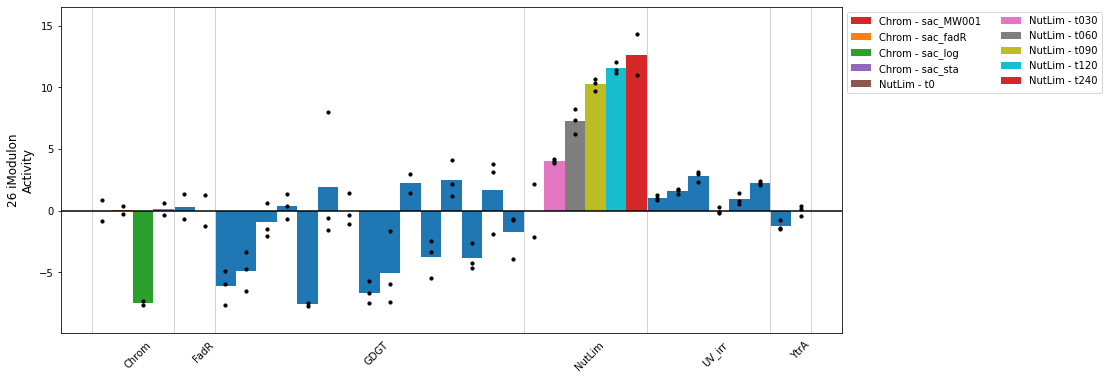

In [71]:
fig, ax = plt.subplots(figsize=(14, 6))

plot_activities(ica_data, 26, highlight=['Chrom', 'NutLim'], ax=ax)

### iModulon 39: Putative UV-related iModulon

In [72]:
get_kegg_enrichements(39, 'pathway')

imodulon   kegg_id    pvalue    qvalue  precision    recall   f1score   TP  \
65       39  map00906  0.000143  0.028264        1.0  0.071429  0.133333  2.0   

    target_set_size  imodulon_size             pathway_name  
65              2.0           28.0  Carotenoid biosynthesis

<AxesSubplot:xlabel='Gene Start', ylabel='39 Gene Weight'>

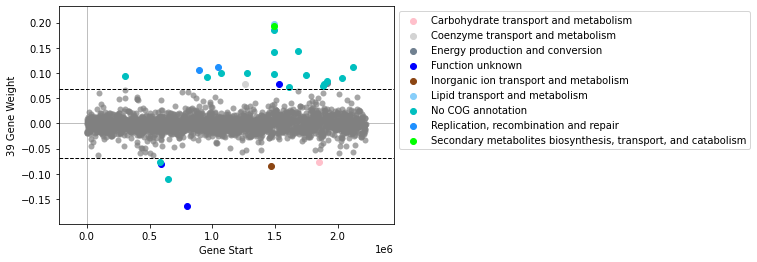

In [73]:
plot_gene_weights(ica_data, 39)

In [74]:
ica_data.view_imodulon(39)

gene_weight     gene_name old_locus_tag prokka_locus_tag  \
SACI_RS01760     0.094320     Saci_0360     Saci_0360      Sacid_00355   
SACI_RS03460    -0.077127  SACI_RS03460           NaN      Sacid_00705   
SACI_RS11580    -0.079621  SACI_RS11580           NaN              NaN   
SACI_RS11590    -0.109446  SACI_RS11590           NaN              NaN   
SACI_RS11630    -0.163157  SACI_RS11630           NaN              NaN   
SACI_RS05225     0.105964          uvsE     Saci_1096      Sacid_01072   
SACI_RS11845     0.092509  SACI_RS11845           NaN              NaN   
SACI_RS05850     0.111645          phrA     Saci_1227      Sacid_01204   
SACI_RS06010     0.100907  SACI_RS06010           NaN      Sacid_01236   
SACI_RS07065     0.078118          folE     Saci_1481      Sacid_01448   
SACI_RS07140     0.100223          upsA     Saci_1496      Sacid_01463   
SACI_RS08155    -0.084948     Saci_1707     Saci_1707      Sacid_01671   
SACI_RS08275     0.193054         carA2     Saci_1732      Sacid_01696   
SACI_RS08280     0.186133     Saci_1733     Saci_1733      Sacid_01697   
SACI_RS08285     0.196145          crtB     Saci_1734      Sacid_01698   
SACI_RS08290     0.142070     Saci_1735     Saci_1735      Sacid_01699   
SACI_RS08295     0.098816     Saci_1736     Saci_1736      Sacid_01700   
SACI_RS08455     0.077273        COQ5_4     Saci_1768      Sacid_01734   
SACI_RS08850     0.072436     Saci_1845     Saci_1845      Sacid_01814   
SACI_RS09075     0.144157  SACI_RS09075           NaN      Sacid_01859   
SACI_RS09325     0.095041     Saci_1933     Saci_1933      Sacid_01917   
SACI_RS09835    -0.076955          glpF     Saci_2034      Sacid_02029   
SACI_RS09985     0.073222     Saci_2065     Saci_2065      Sacid_02060   
SACI_RS10010     0.078542     Saci_2070     Saci_2070      Sacid_02065   
SACI_RS11760     0.080401  SACI_RS11760           NaN      Sacid_02092   
SACI_RS10145     0.083675     Saci_2099     Saci_2099      Sacid_02096   
SACI_RS10605     0.090631     Saci_2194     Saci_2194      Sacid_02193   
SACI_RS11030     0.111114     Saci_2280     Saci_2280      Sacid_02282   

             synonyms      start        end strand  \
SACI_RS01760      NaN   303121.0   304209.0      +   
SACI_RS03460      NaN   584094.0   584273.0      +   
SACI_RS11580      NaN   594292.0   594510.0      +   
SACI_RS11590      NaN   648575.0   648803.0      +   
SACI_RS11630      NaN   799347.0   799547.0      -   
SACI_RS05225      NaN   894785.0   895654.0      +   
SACI_RS11845      NaN   955170.0   955289.0      +   
SACI_RS05850      NaN  1043234.0  1044526.0      +   
SACI_RS06010      NaN  1071231.0  1071434.0      +   
SACI_RS07065      NaN  1259620.0  1260249.0      +   
SACI_RS07140      NaN  1275200.0  1275631.0      +   
SACI_RS08155      NaN  1465796.0  1466929.0      +   
SACI_RS08275      NaN  1490703.0  1492091.0      -   
SACI_RS08280      NaN  1492088.0  1492552.0      -   
SACI_RS08285      NaN  1492674.0  1493501.0      +   
SACI_RS08290      NaN  1493516.0  1494178.0      +   
SACI_RS08295      NaN  1494163.0  1495041.0      +   
SACI_RS08455      NaN  1528633.0  1529169.0      +   
SACI_RS08850      NaN  1612674.0  1613114.0      +   
SACI_RS09075      NaN  1680334.0  1680588.0      -   
SACI_RS09325      NaN  1743815.0  1744156.0      -   
SACI_RS09835      NaN  1849204.0  1850085.0      +   
SACI_RS09985      NaN  1884454.0  1885188.0      -   
SACI_RS10010      NaN  1887403.0  1888473.0      +   
SACI_RS11760      NaN  1914003.0  1914761.0      -   
SACI_RS10145      NaN  1917809.0  1918819.0      -   
SACI_RS10605      NaN  2033304.0  2034104.0      +   
SACI_RS11030      NaN  2124445.0  2124966.0      +   

                                            gene_product  \
SACI_RS01760                        hypothetical protein   
SACI_RS03460                        hypothetical protein   
SACI_RS11580                                   integrase   
SACI_RS11590                        hypothetical protein   


<AxesSubplot:ylabel='39 iModulon\nActivity'>

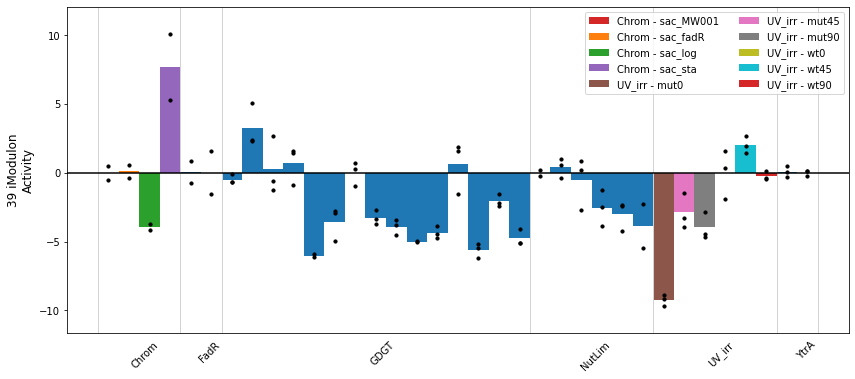

In [75]:
fig, ax = plt.subplots(figsize=(14, 6))

plot_activities(ica_data, 39, highlight=['Chrom', 'UV_irr'], ax=ax)

### iModulon 4: Putative Riboflavin-related iModulon 2 (Possibly UV-related)

In [76]:
get_kegg_enrichements(4, 'pathway')

imodulon   kegg_id    pvalue    qvalue  precision    recall   f1score   TP  \
0        4  map00740  0.000085  0.016746   0.333333  0.333333  0.333333  2.0   

   target_set_size  imodulon_size           pathway_name  
0              6.0            6.0  Riboflavin metabolism

In [77]:
get_kegg_enrichements(4, 'module')

imodulon kegg_id    pvalue    qvalue  precision    recall  f1score   TP  \
0        4  M00125  0.000006  0.000968        1.0  0.333333      0.5  2.0   

   target_set_size  imodulon_size  \
0              2.0            6.0   

                                         module_name  
0  Riboflavin biosynthesis, plants and bacteria, ...

<AxesSubplot:xlabel='Gene Start', ylabel='4 Gene Weight'>

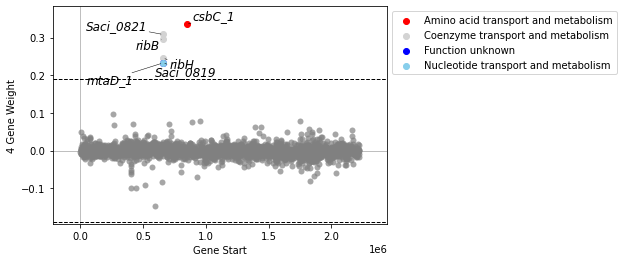

In [78]:
plot_gene_weights(ica_data, 4)

In [79]:
ica_data.view_imodulon(4)

gene_weight  gene_name old_locus_tag prokka_locus_tag synonyms  \
SACI_RS03915     0.232396     mtaD_1     Saci_0818      Sacid_00797      NaN   
SACI_RS03920     0.233548  Saci_0819     Saci_0819      Sacid_00798      NaN   
SACI_RS03925     0.245319       ribH     Saci_0820      Sacid_00799      NaN   
SACI_RS03930     0.308090  Saci_0821     Saci_0821      Sacid_00800      NaN   
SACI_RS03935     0.296197       ribB     Saci_0822      Sacid_00801      NaN   
SACI_RS04990     0.334581     csbC_1     Saci_1045      Sacid_01018      NaN   

                 start       end strand  \
SACI_RS03915  656317.0  657420.0      -   
SACI_RS03920  657402.0  658061.0      -   
SACI_RS03925  658058.0  658534.0      -   
SACI_RS03930  658506.0  658976.0      -   
SACI_RS03935  658973.0  659635.0      -   
SACI_RS04990  845538.0  846869.0      +   

                                               gene_product  \
SACI_RS03915                  amidohydrolase family protein   
SACI_RS03920                         GTP cyclohydrolase IIa   
SACI_RS03925        6,7-dimethyl-8-ribityllumazine synthase   
SACI_RS03930                            riboflavin synthase   
SACI_RS03935  3,4-dihydroxy-2-butanone-4-phosphate synthase   
SACI_RS04990                                MFS transporter   

                                            gene_product_prokka  \
SACI_RS03915  5-methylthioadenosine/S-adenosylhomocysteine d...   
SACI_RS03920                               hypothetical protein   
SACI_RS03925            6,7-dimethyl-8-ribityllumazine synthase   
SACI_RS03930                               hypothetical protein   
SACI_RS03935      3,4-dihydroxy-2-butanone 4-phosphate synthase   
SACI_RS04990         putative metabolite transport protein CsbC   

                                              COG        uniprot       refseq  \
SACI_RS03915  Nucleotide transport and metabolism     A0A0U2N979  NC_007181.1   
SACI_RS03920                     Function unknown     A0A0U2Y7W8  NC_007181.1   
SACI_RS03925    Coenzyme transport and metabolism  UPI00005523C3  NC_007181.1   
SACI_RS03930    Coenzyme transport and metabolism     A0A0U3FF10  NC_007181.1   
SACI_RS03935    Coenzyme transport and metabolism     A0A0U3F6Y4  NC_007181.1   
SACI_RS04990  Amino acid transport and metabolism     A0A0U3FYG8  NC_007181.1   

             regulator  
SACI_RS03915       NaN  
SACI_RS03920       NaN  
SACI_RS03925       NaN  
SACI_RS03930       NaN  
SACI_RS03935       NaN  
SACI_RS04990       NaN

<AxesSubplot:ylabel='4 iModulon\nActivity'>

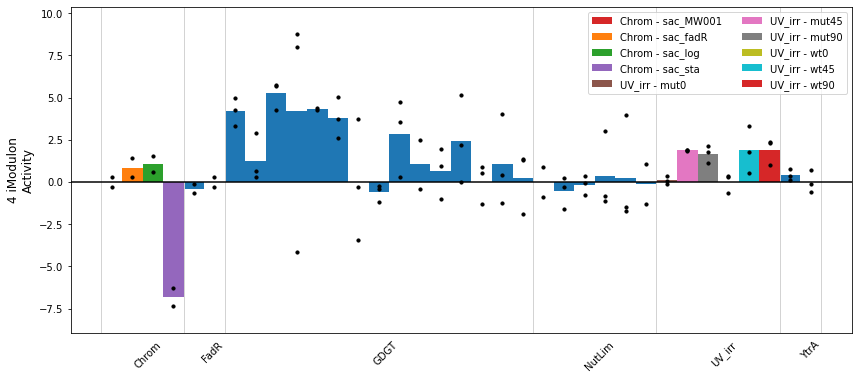

In [80]:
fig, ax = plt.subplots(figsize=(14, 6))

plot_activities(ica_data, 4, highlight=['Chrom', 'UV_irr'], ax=ax)

### iModulon 7: Putative Biotin (Vit B12) / Amino Acid biosynthesis iModulon

In [81]:
get_kegg_enrichements(7, 'pathway')

imodulon   kegg_id        pvalue        qvalue  precision    recall  \
1        7  map00720  1.947367e-11  3.836313e-09   0.169811  0.529412   
2        7  map01120  1.296231e-08  1.026232e-06   0.067114  0.588235   
3        7  map01200  1.562789e-08  1.026232e-06   0.082569  0.529412   
4        7  map00261  7.608847e-04  2.997886e-02   0.333333  0.117647   
5        7  map00280  6.203662e-04  2.997886e-02   0.125000  0.176471   
6        7  map00640  1.465411e-03  4.811434e-02   0.093750  0.176471   

    f1score    TP  target_set_size  imodulon_size  \
1  0.257143   9.0             53.0           17.0   
2  0.120482  10.0            149.0           17.0   
3  0.142857   9.0            109.0           17.0   
4  0.173913   2.0              6.0           17.0   
5  0.146341   3.0             24.0           17.0   
6  0.122449   3.0             32.0           17.0   

                                   pathway_name  
1       Carbon fixation pathways in prokaryotes  
2  Microbial metabolism in diverse environments  
3                             Carbon metabolism  
4                       Monobactam biosynthesis  
5    Valine, leucine and isoleucine degradation  
6                         Propanoate metabolism

In [82]:
get_kegg_enrichements(7, 'module')

imodulon kegg_id        pvalue        qvalue  precision    recall  \
1         7  M00375  3.286981e-14  5.587867e-12   0.321429  0.529412   
2         7  M00374  1.771895e-06  1.506111e-04   0.161290  0.294118   
3         7  M00033  3.070233e-04  1.237299e-02   0.500000  0.117647   
4         7  M00525  5.094759e-04  1.237299e-02   0.400000  0.117647   
5         7  M00526  5.094759e-04  1.237299e-02   0.400000  0.117647   
6         7  M00527  5.094759e-04  1.237299e-02   0.400000  0.117647   
7         7  M00741  5.094759e-04  1.237299e-02   0.400000  0.117647   
8         7  M00016  1.060599e-03  2.003354e-02   0.285714  0.117647   
9         7  M00017  1.060599e-03  2.003354e-02   0.285714  0.117647   
10        7  M00018  1.407975e-03  2.393557e-02   0.250000  0.117647   

     f1score   TP  target_set_size  imodulon_size  \
1   0.400000  9.0             28.0           17.0   
2   0.208333  5.0             31.0           17.0   
3   0.190476  2.0              4.0           17.0   
4   0.181818  2.0              5.0           17.0   
5   0.181818  2.0              5.0           17.0   
6   0.181818  2.0              5.0           17.0   
7   0.181818  2.0              5.0           17.0   
8   0.166667  2.0              7.0           17.0   
9   0.166667  2.0              7.0           17.0   
10  0.160000  2.0              8.0           17.0   

                                          module_name  
1             Hydroxypropionate-hydroxybutylate cycle  
2                 Dicarboxylate-hydroxybutyrate cycle  
3          Ectoine biosynthesis, aspartate => ectoine  
4   Lysine biosynthesis, acetyl-DAP pathway, aspar...  
5   Lysine biosynthesis, DAP dehydrogenase pathway...  
6   Lysine biosynthesis, DAP aminotransferase path...  
7   Propanoyl-CoA metabolism, propanoyl-CoA => suc...  
8   Lysine biosynthesis, succinyl-DAP pathway, asp...  
9   Methionine biosynthesis, apartate => homoserin...  
10  Threonine biosynthesis, aspartate => homoserin...

<AxesSubplot:xlabel='Gene Start', ylabel='7 Gene Weight'>

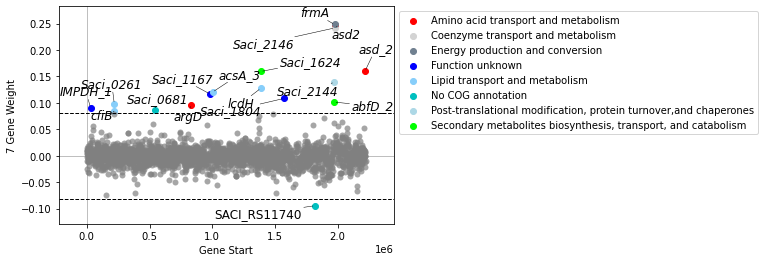

In [83]:
plot_gene_weights(ica_data, 7)

In [84]:
ica_data.view_imodulon(7)

gene_weight     gene_name old_locus_tag prokka_locus_tag  \
SACI_RS00195     0.090103       IMPDH_1     Saci_0044      Sacid_00042   
SACI_RS01265     0.084405          cfiB     Saci_0260      Sacid_00256   
SACI_RS01270     0.098617     Saci_0261     Saci_0261      Sacid_00257   
SACI_RS03240     0.086953     Saci_0681     Saci_0681      Sacid_00662   
SACI_RS04910     0.096804          argD     Saci_1028      Sacid_01002   
SACI_RS05560     0.116667     Saci_1167     Saci_1167      Sacid_01144   
SACI_RS05645     0.120481        acsA_3     Saci_1184      Sacid_01162   
SACI_RS07750     0.127476          lcdH     Saci_1623      Sacid_01588   
SACI_RS07755     0.159463     Saci_1624     Saci_1624      Sacid_01589   
SACI_RS08640     0.108396     Saci_1804     Saci_1804      Sacid_01773   
SACI_RS11740    -0.094508  SACI_RS11740           NaN              NaN   
SACI_RS10365     0.101525        abfD_2     Saci_2143      Sacid_02141   
SACI_RS10370     0.138859     Saci_2144     Saci_2144      Sacid_02142   
SACI_RS10375     0.248342          frmA     Saci_2145      Sacid_02143   
SACI_RS10380     0.241802     Saci_2146     Saci_2146      Sacid_02144   
SACI_RS10385     0.247748          asd2     Saci_2147      Sacid_02145   
SACI_RS11460     0.159894         asd_2     Saci_2370      Sacid_02368   

             synonyms      start        end strand  \
SACI_RS00195      NaN    29614.0    30108.0      +   
SACI_RS01265      NaN   217169.0   218701.0      +   
SACI_RS01270      NaN   218701.0   219204.0      +   
SACI_RS03240      NaN   541758.0   542003.0      +   
SACI_RS04910      NaN   827654.0   828943.0      +   
SACI_RS05560      NaN   983366.0   983848.0      -   
SACI_RS05645      acs  1003003.0  1004967.0      -   
SACI_RS07750      NaN  1386119.0  1387081.0      +   
SACI_RS07755      NaN  1387132.0  1387698.0      -   
SACI_RS08640      NaN  1571433.0  1571771.0      -   
SACI_RS11740      NaN  1818109.0  1818300.0      -   
SACI_RS10365      NaN  1971870.0  1973387.0      +   
SACI_RS10370      NaN  1973605.0  1974603.0      -   
SACI_RS10375      NaN  1974724.0  1975815.0      +   
SACI_RS10380      NaN  1976028.0  1977455.0      +   
SACI_RS10385      asd  1977811.0  1978869.0      +   
SACI_RS11460      asd  2217234.0  2218298.0      -   

                                                   gene_product  \
SACI_RS00195                      CBS domain-containing protein   
SACI_RS01265                                 biotin carboxylase   
SACI_RS01270                      biotin/lipoyl-binding protein   
SACI_RS03240                               hypothetical protein   
SACI_RS04910   acetyl ornithine aminotransferase family protein   
SACI_RS05560                      CBS domain-containing protein   
SACI_RS05645                                acetate--CoA ligase   
SACI_RS07750     3-hydroxyacyl-CoA dehydrogenase family protein   
SACI_RS07755                    cupin domain-containing protein   
SACI_RS08640                             DUF2173 family protein   
SACI_RS11740                               hypothetical protein   
SACI_RS10365  4-hydroxyphenylacetate 3-hydroxylase family pr...   
SACI_RS10370                NAD(P)/FAD-dependent oxidoreductase   
SACI_RS10375  alcohol dehydrogenase catalytic domain-contain...   
SACI_RS10380                          phenylacetate--CoA ligase   
SACI_RS10385               aspartate-semialdehyde dehydrogenase   
SACI_RS11460               aspartate-semialdehyde dehydrogenase   

                                            gene_product_prokka  \
SACI_RS00195             Inosine-5'-monophosphate dehydrogenase   
SACI_RS01265           2-oxoglutarate carboxylase small subunit   
SACI_RS01270                               hypothetical protein   
SACI_RS03240                               hypothetical protein   
SACI_RS04910                   Acetylornithine aminotransferase   
SACI_RS05560                               hypothetical protein   
SACI_RS05645                    

<AxesSubplot:ylabel='7 iModulon\nActivity'>

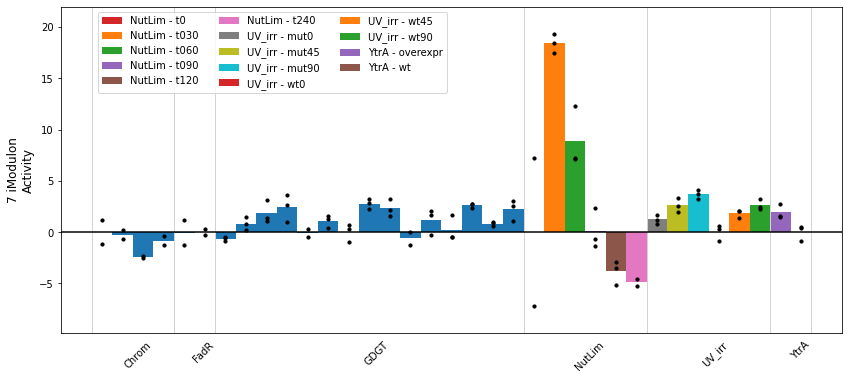

In [85]:
fig, ax = plt.subplots(figsize=(14, 6))

plot_activities(ica_data, 7, highlight=['NutLim', 'UV_irr', 'YtrA'], ax=ax,
                legend_kwargs={'bbox_to_anchor': (0.5, 1)})

### iModulon 9: HMG-CoA / BCAA iModulon

In [86]:
get_kegg_enrichements(9, 'pathway')

imodulon   kegg_id    pvalue    qvalue  precision  recall   f1score   TP  \
7         9  map00900  0.000003  0.000543   0.187500     0.6  0.285714  3.0   
8         9  map00072  0.000170  0.016707   0.200000     0.4  0.266667  2.0   
9         9  map00280  0.001028  0.067480   0.083333     0.4  0.137931  2.0   
10        9  map00650  0.001834  0.085801   0.062500     0.4  0.108108  2.0   
11        9  map04976  0.002178  0.085801   1.000000     0.2  0.333333  1.0   

    target_set_size  imodulon_size                                pathway_name  
7              16.0            5.0             Terpenoid backbone biosynthesis  
8              10.0            5.0  Synthesis and degradation of ketone bodies  
9              24.0            5.0  Valine, leucine and isoleucine degradation  
10             32.0            5.0                        Butanoate metabolism  
11              1.0            5.0                              Bile secretion

In [87]:
get_kegg_enrichements(9, 'module')

imodulon kegg_id    pvalue    qvalue  precision  recall   f1score   TP  \
11        9  M00095  0.000001  0.000240   0.230769     0.6  0.333333  3.0   
12        9  M00088  0.000170  0.014417   0.200000     0.4  0.266667  2.0   

    target_set_size  imodulon_size  \
11             13.0            5.0   
12             10.0            5.0   

                                          module_name  
11     C5 isoprenoid biosynthesis, mevalonate pathway  
12  Ketone body biosynthesis, acetyl-CoA => acetoa...

<AxesSubplot:xlabel='Gene Start', ylabel='9 Gene Weight'>

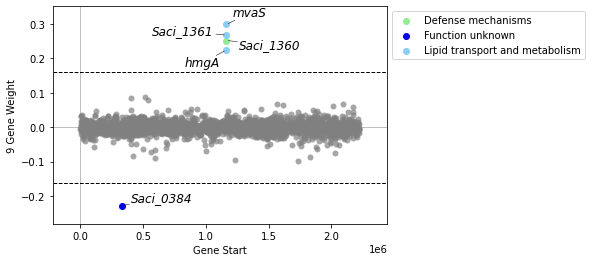

In [88]:
plot_gene_weights(ica_data, 9)

In [89]:
ica_data.view_imodulon(9)

gene_weight  gene_name old_locus_tag prokka_locus_tag synonyms  \
SACI_RS01880    -0.228067  Saci_0384     Saci_0384      Sacid_00380      NaN   
SACI_RS06500     0.224299       hmgA     Saci_1359      Sacid_01333      NaN   
SACI_RS06505     0.252092  Saci_1360     Saci_1360      Sacid_01334      NaN   
SACI_RS06510     0.267876  Saci_1361     Saci_1361      Sacid_01335      NaN   
SACI_RS06515     0.298705       mvaS     Saci_1362      Sacid_01336      NaN   

                  start        end strand  \
SACI_RS01880   331631.0   331996.0      +   
SACI_RS06500  1161400.0  1162635.0      -   
SACI_RS06505  1162619.0  1163032.0      -   
SACI_RS06510  1163038.0  1164132.0      -   
SACI_RS06515  1164132.0  1165178.0      -   

                                             gene_product  \
SACI_RS01880            DUF2203 domain-containing protein   
SACI_RS06500  hydroxymethylglutaryl-CoA reductase (NADPH)   
SACI_RS06505  Zn-ribbon domain-containing OB-fold protein   
SACI_RS06510                      thiolase family protein   
SACI_RS06515           hydroxymethylglutaryl-CoA synthase   

                             gene_product_prokka  \
SACI_RS01880                hypothetical protein   
SACI_RS06500                hypothetical protein   
SACI_RS06505                hypothetical protein   
SACI_RS06510                hypothetical protein   
SACI_RS06515  Hydroxymethylglutaryl-CoA synthase   

                                         COG     uniprot       refseq  \
SACI_RS01880                Function unknown  A0A0U3HEK3  NC_007181.1   
SACI_RS06500  Lipid transport and metabolism  A0A0U3FV32  NC_007181.1   
SACI_RS06505              Defense mechanisms  A0A0U3H6A0  NC_007181.1   
SACI_RS06510  Lipid transport and metabolism  A0A0U2Y6H3  NC_007181.1   
SACI_RS06515  Lipid transport and metabolism  A0A0U3H6B3  NC_007181.1   

             regulator  
SACI_RS01880       NaN  
SACI_RS06500       NaN  
SACI_RS06505       NaN  
SACI_RS06510       NaN  
SACI_RS06515       NaN

<AxesSubplot:ylabel='9 iModulon\nActivity'>

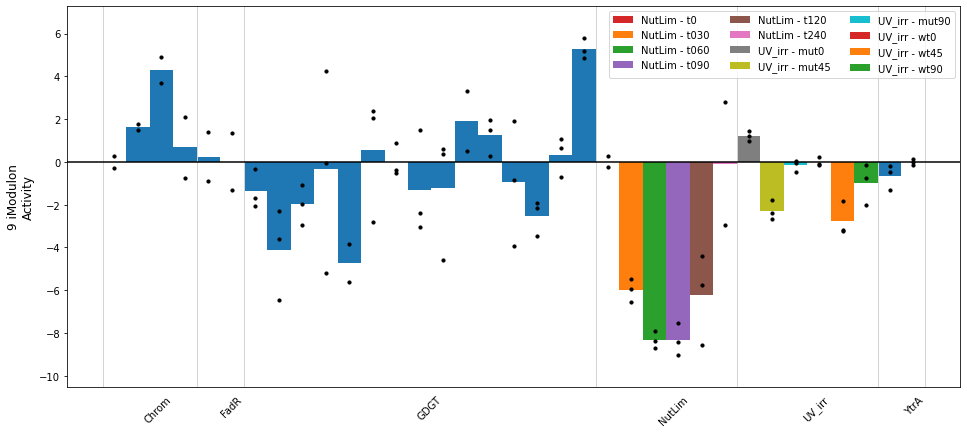

In [90]:
fig, ax = plt.subplots(figsize=(16, 7))

plot_activities(ica_data, 9, highlight=['NutLim', 'UV_irr'], ax=ax)

### iModulon 10: Purine biosynthesis iModulon [E coli ortholog: PurR-1]

In [91]:
get_kegg_enrichements(10, 'pathway')

imodulon   kegg_id        pvalue    qvalue  precision    recall   f1score  \
13       10  map00230  4.706404e-08  0.000009   0.111111  0.714286  0.192308   
15       10  map01110  4.260217e-05  0.002798   0.028902  0.714286  0.055556   

     TP  target_set_size  imodulon_size                           pathway_name  
13  5.0             45.0            7.0                      Purine metabolism  
15  5.0            173.0            7.0  Biosynthesis of secondary metabolites

In [92]:
get_kegg_enrichements(10, 'module')

imodulon kegg_id        pvalue        qvalue  precision    recall  f1score  \
13       10  M00048  5.075523e-11  8.628390e-09   0.384615  0.714286      0.5   

     TP  target_set_size  imodulon_size  \
13  5.0             13.0            7.0   

                                          module_name  
13  Inosine monophosphate biosynthesis, PRPP + glu...

<AxesSubplot:xlabel='Gene Start', ylabel='10 Gene Weight'>

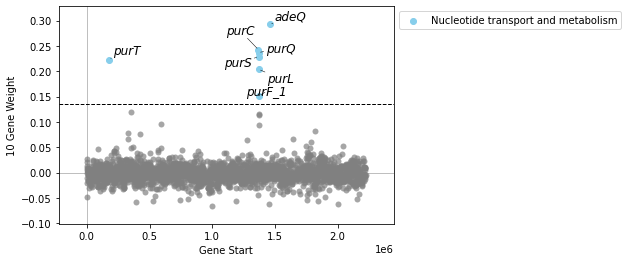

In [93]:
plot_gene_weights(ica_data, 10)

In [94]:
# Manually changing threshold yields more relevant enriched genes for this iModulon
ica_data.change_threshold(10, 0.08)

<AxesSubplot:xlabel='Gene Start', ylabel='10 Gene Weight'>

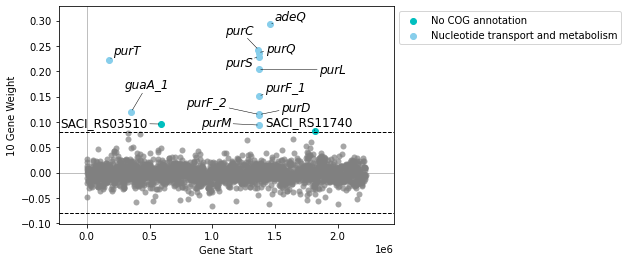

In [95]:
plot_gene_weights(ica_data, 10)

In [96]:
ica_data.view_imodulon(10)

gene_weight     gene_name old_locus_tag prokka_locus_tag  \
SACI_RS01035     0.222913          purT     Saci_0214      Sacid_00208   
SACI_RS02020     0.119964        guaA_1     Saci_0414      Sacid_00409   
SACI_RS03510     0.095766  SACI_RS03510           NaN      Sacid_00716   
SACI_RS07670     0.242352          purC     Saci_1607      Sacid_01572   
SACI_RS07675     0.228183          purS     Saci_1608      Sacid_01573   
SACI_RS07680     0.236846          purQ           NaN      Sacid_01574   
SACI_RS07685     0.203736          purL     Saci_1610      Sacid_01575   
SACI_RS07690     0.151333        purF_1     Saci_1611      Sacid_01576   
SACI_RS07695     0.114578        purF_2     Saci_1612      Sacid_01577   
SACI_RS07700     0.114411          purD     Saci_1613      Sacid_01578   
SACI_RS07705     0.093677          purM     Saci_1614      Sacid_01579   
SACI_RS08125     0.292217          adeQ     Saci_1701      Sacid_01665   
SACI_RS11740     0.082615  SACI_RS11740           NaN              NaN   

             synonyms      start        end strand  \
SACI_RS01035      NaN   176428.0   177624.0      -   
SACI_RS02020      NaN   354525.0   355646.0      +   
SACI_RS03510      NaN   590261.0   590485.0      +   
SACI_RS07670      NaN  1368285.0  1368992.0      +   
SACI_RS07675      NaN  1368989.0  1369267.0      +   
SACI_RS07680      NaN  1369248.0  1369928.0      +   
SACI_RS07685      NaN  1369918.0  1372050.0      +   
SACI_RS07690     purF  1372043.0  1373377.0      +   
SACI_RS07695      NaN  1373383.0  1374597.0      +   
SACI_RS07700      NaN  1374603.0  1376039.0      +   
SACI_RS07705      NaN  1376033.0  1376998.0      +   
SACI_RS08125      NaN  1459196.0  1460647.0      -   
SACI_RS11740      NaN  1818109.0  1818300.0      -   

                                                   gene_product  \
SACI_RS01035  formate-dependent phosphoribosylglycinamide fo...   
SACI_RS02020                    7-cyano-7-deazaguanine synthase   
SACI_RS03510                               hypothetical protein   
SACI_RS07670  phosphoribosylaminoimidazolesuccinocarboxamide...   
SACI_RS07675  phosphoribosylformylglycinamidine synthase sub...   
SACI_RS07680       phosphoribosylformylglycinamidine synthase I   
SACI_RS07685  phosphoribosylformylglycinamidine synthase sub...   
SACI_RS07690                     amidophosphoribosyltransferase   
SACI_RS07695                     amidophosphoribosyltransferase   
SACI_RS07700                phosphoribosylamine--glycine ligase   
SACI_RS07705     phosphoribosylformylglycinamidine cyclo-ligase   
SACI_RS08125  Xanthine/uracil/vitamin C permease of the AzgA...   
SACI_RS11740                               hypothetical protein   

                                            gene_product_prokka  \
SACI_RS01035  Formate-dependent phosphoribosylglycinamide fo...   
SACI_RS02020               GMP synthase [glutamine-hydrolyzing]   
SACI_RS03510                               hypothetical protein   
SACI_RS07670  Phosphoribosylaminoimidazole-succinocarboxamid...   
SACI_RS07675  Phosphoribosylformylglycinamidine synthase sub...   
SACI_RS07680  Phosphoribosylformylglycinamidine synthase sub...   
SACI_RS07685  Phosphoribosylformylglycinamidine synthase sub...   
SACI_RS07690                     Amidophosphoribosyltransferase   
SACI_RS07695                     Amidophosphoribosyltransferase   
SACI_RS07700                Phosphoribosylamine--glycine ligase   
SACI_RS07705     Phosphoribosylformylglycinamidine cyclo-ligase   
SACI_RS08125                              Adenine permease AdeQ   
SACI_RS11740                                                NaN   

                                              COG        uniprot       refseq  \
SACI_RS01035  Nucleotide transport and metabolism     A0A0U3FGE0  NC_007181.1   
SACI_RS02020  Nucleotide transport and metabolism     A0A0U3FP39  NC_007181.1   
SACI_RS03510                    No COG annotation     A0A0U2N9C5  NC_007181.1   
SACI_RS07670  Nucl

<AxesSubplot:ylabel='10 iModulon\nActivity'>

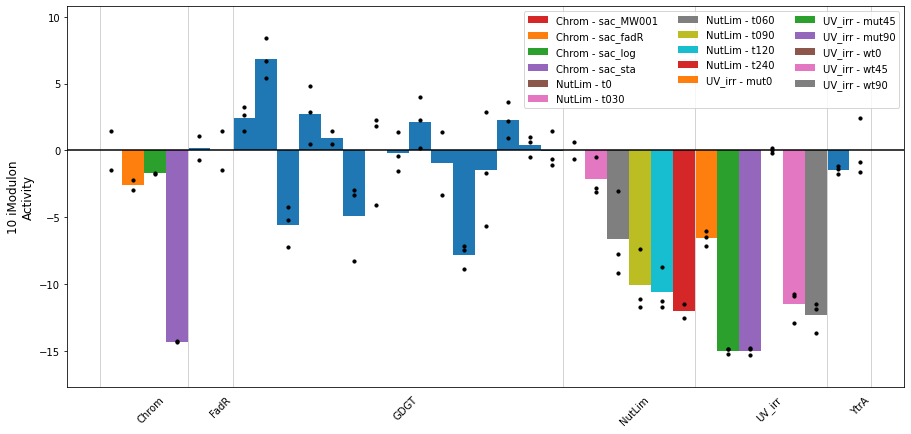

In [97]:
fig, ax = plt.subplots(figsize=(15, 7))

plot_activities(ica_data, 10, highlight=['Chrom', 'NutLim', 'UV_irr'], ax=ax)

### iModulon 17: Composite iModulon 1 (Putative Translation + Cell Division + Shikimate iModulon)

In [98]:
get_kegg_enrichements(17, 'pathway')

imodulon   kegg_id        pvalue    qvalue  precision    recall   f1score  \
34       17  map03010  5.303780e-09  0.000001   0.278689  0.139344  0.185792   

      TP  target_set_size  imodulon_size pathway_name  
34  17.0             61.0          122.0     Ribosome

In [99]:
get_kegg_enrichements(17, 'module')

imodulon kegg_id    pvalue    qvalue  precision    recall   f1score   TP  \
27       17  M00022  0.000235  0.013298   0.571429  0.032787  0.062016  4.0   

    target_set_size  imodulon_size  \
27              7.0          122.0   

                                          module_name  
27  Shikimate pathway, phosphoenolpyruvate + eryth...

<AxesSubplot:xlabel='Gene Start', ylabel='17 Gene Weight'>

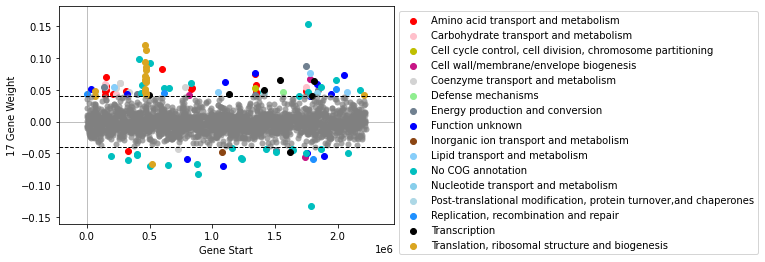

In [100]:
plot_gene_weights(ica_data, 17)

In [101]:
## Most likely a composite iModulon consisting of some of the following:
## Translation/Ribosome iModulon
## Cell division iModulon
## Shikimate/ Aromatic AA iModulon


# Uncomment below to see genes enriched in this iModulon

#ica_data.view_imodulon(17)[0:50]
#ica_data.view_imodulon(17)[50:100]
#ica_data.view_imodulon(17)[100:]

<AxesSubplot:ylabel='17 iModulon\nActivity'>

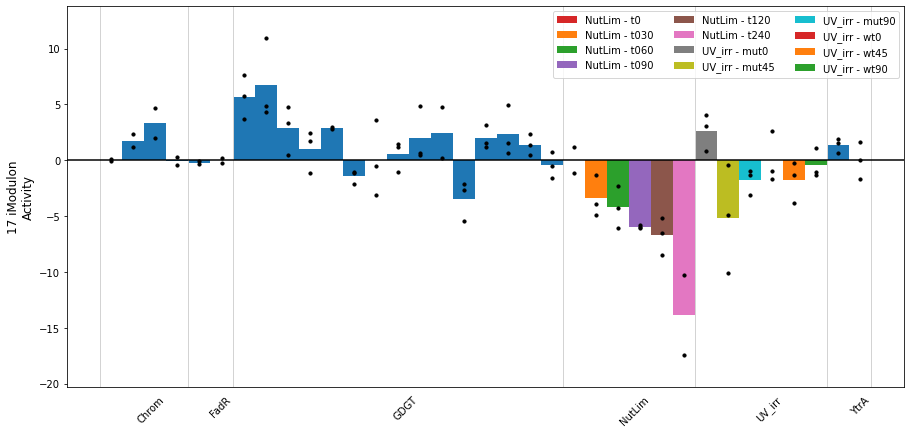

In [102]:
fig, ax = plt.subplots(figsize=(15, 7))

plot_activities(ica_data, 17, highlight=['NutLim', 'UV_irr'], ax=ax)

### iModulon 19: Putative Arginine biosynthesis iModulon

In [103]:
get_kegg_enrichements(19, 'pathway')

imodulon   kegg_id        pvalue    qvalue  precision  recall   f1score  \
35       19  map00250  5.182310e-09  0.000001   0.190476     1.0  0.320000   
36       19  map00220  1.764982e-04  0.017385   0.153846     0.5  0.235294   
37       19  map01100  8.303681e-04  0.054528   0.010230     1.0  0.020253   
38       19  map00240  1.180873e-03  0.058158   0.060606     0.5  0.108108   

     TP  target_set_size  imodulon_size  \
35  4.0             21.0            4.0   
36  2.0             13.0            4.0   
37  4.0            391.0            4.0   
38  2.0             33.0            4.0   

                                   pathway_name  
35  Alanine, aspartate and glutamate metabolism  
36                        Arginine biosynthesis  
37                           Metabolic pathways  
38                        Pyrimidine metabolism

In [104]:
get_kegg_enrichements(19, 'module')

imodulon kegg_id    pvalue    qvalue  precision  recall   f1score   TP  \
28       19  M00029  0.000007  0.000387   0.666667     0.5  0.571429  2.0   
29       19  M00844  0.000007  0.000387   0.666667     0.5  0.571429  2.0   
30       19  M00845  0.000002  0.000387   1.000000     0.5  0.666667  2.0   
31       19  M00051  0.000064  0.002701   0.250000     0.5  0.333333  2.0   

    target_set_size  imodulon_size  \
28              3.0            4.0   
29              3.0            4.0   
30              2.0            4.0   
31              8.0            4.0   

                                          module_name  
28                                         Urea cycle  
29       Arginine biosynthesis, ornithine => arginine  
30  Arginine biosynthesis, glutamate => acetylcitr...  
31  Uridine monophosphate biosynthesis, glutamine ...

<AxesSubplot:xlabel='Gene Start', ylabel='19 Gene Weight'>

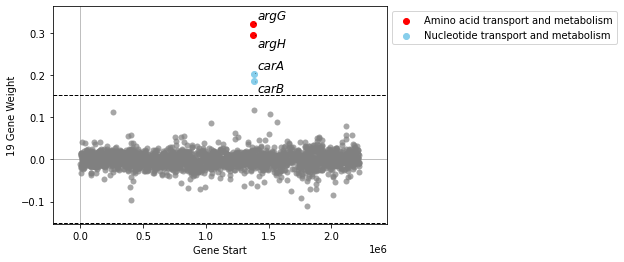

In [105]:
plot_gene_weights(ica_data, 19)

In [106]:
# Threshold may need to be manually curated down to 0.1 or 0.11 to allow lysX_3 into this iModulon

cond = abs(ica_data.M[19]) >= 0.1

ica_data.gene_table.loc[cond]

gene_name old_locus_tag prokka_locus_tag synonyms      start  \
SACI_RS01470  Saci_0301     Saci_0301      Sacid_00297      NaN   256423.0   
SACI_RS07720       argG     Saci_1617      Sacid_01582      NaN  1377839.0   
SACI_RS07725       argH     Saci_1618      Sacid_01583      NaN  1379015.0   
SACI_RS07730       carA     Saci_1619      Sacid_01584      NaN  1380339.0   
SACI_RS07735       carB     Saci_1620      Sacid_01585      NaN  1381447.0   
SACI_RS07740     lysX_3     Saci_1621      Sacid_01586     lysX  1384602.0   
SACI_RS08380  Saci_1753     Saci_1753      Sacid_01717      NaN  1511477.0   
SACI_RS09635  Saci_1992     Saci_1992      Sacid_01984      NaN  1809967.0   

                    end strand  \
SACI_RS01470   257034.0      -   
SACI_RS07720  1379014.0      +   
SACI_RS07725  1380358.0      +   
SACI_RS07730  1381454.0      +   
SACI_RS07735  1384605.0      +   
SACI_RS07740  1385450.0      +   
SACI_RS08380  1511761.0      +   
SACI_RS09635  1810347.0      -   

                                                   gene_product  \
SACI_RS01470                   DUF981 domain-containing protein   
SACI_RS07720                         argininosuccinate synthase   
SACI_RS07725                            argininosuccinate lyase   
SACI_RS07730  glutamine-hydrolyzing carbamoyl-phosphate synt...   
SACI_RS07735  carbamoyl-phosphate synthase (glutamine-hydrol...   
SACI_RS07740                   lysine biosynthesis protein LysX   
SACI_RS08380                               hypothetical protein   
SACI_RS09635  winged helix-turn-helix transcriptional regulator   

                                   gene_product_prokka  \
SACI_RS01470                      hypothetical protein   
SACI_RS07720                Argininosuccinate synthase   
SACI_RS07725                   Argininosuccinate lyase   
SACI_RS07730  Carbamoyl-phosphate synthase small chain   
SACI_RS07735  Carbamoyl-phosphate synthase large chain   
SACI_RS07740      Alpha-aminoadipate--LysW ligase LysX   
SACI_RS08380                      hypothetical protein   
SACI_RS09635                      hypothetical protein   

                                              COG     uniprot       refseq  \
SACI_RS01470                     Function unknown  A0A0U3GQJ3  NC_007181.1   
SACI_RS07720  Amino acid transport and metabolism  A0A0U2WVT6  NC_007181.1   
SACI_RS07725  Amino acid transport and metabolism  A0A0U2Y3V1  NC_007181.1   
SACI_RS07730  Nucleotide transport and metabolism  A0A0U3FKU8  NC_007181.1   
SACI_RS07735  Nucleotide transport and metabolism  A0A0U3FCR2  NC_007181.1   
SACI_RS07740    Coenzyme transport and metabolism  A0A0U3GQD8  NC_007181.1   
SACI_RS08380                    No COG annotation  A0A0U3FSN3  NC_007181.1   
SACI_RS09635                        Transcription  A0A0U3H4P9  NC_007181.1   

             regulator  
SACI_RS01470       NaN  
SACI_RS07720       NaN  
SACI_RS07725       NaN  
SACI_RS07730       NaN  
SACI_RS07735       NaN  
SACI_RS07740       NaN  
SACI_RS08380       NaN  
SACI_RS09635       NaN

<AxesSubplot:ylabel='19 iModulon\nActivity'>

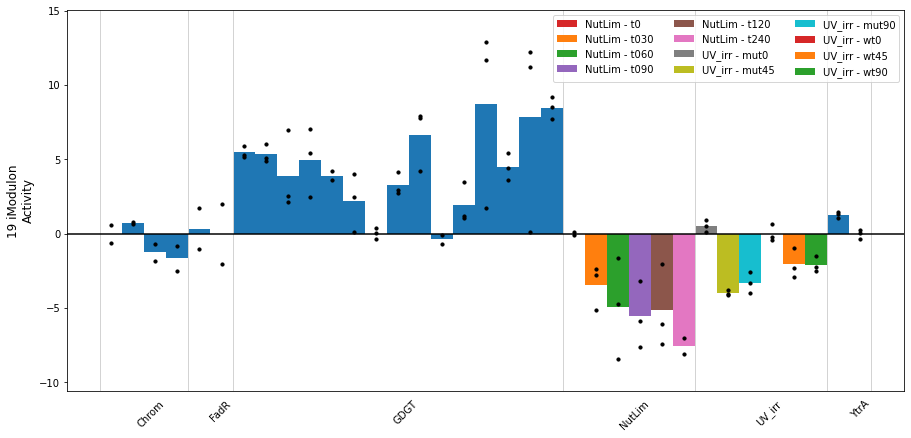

In [107]:
fig, ax = plt.subplots(figsize=(15, 7))

plot_activities(ica_data, 19, highlight=['NutLim', 'UV_irr'], ax=ax)

### iModulon 21: Composite iModulon 2 (Putative Translation + Cell Division + Porphyrin iModulon)

In [108]:
get_kegg_enrichements(21, 'pathway')

imodulon   kegg_id        pvalue        qvalue  precision    recall  \
39       21  map03010  1.734450e-09  3.416866e-07   0.311475  0.130137   
40       21  map00970  2.307675e-04  2.273060e-02   0.285714  0.054795   

     f1score    TP  target_set_size  imodulon_size  \
39  0.183575  19.0             61.0          146.0   
40  0.091954   8.0             28.0          146.0   

                   pathway_name  
39                     Ribosome  
40  Aminoacyl-tRNA biosynthesis

In [109]:
get_kegg_enrichements(21, 'module')

imodulon kegg_id    pvalue    qvalue  precision    recall   f1score   TP  \
34       21  M00121  0.000047  0.002641   0.625000  0.034247  0.064935  5.0   
37       21  M00159  0.000473  0.013394   0.571429  0.027397  0.052288  4.0   
38       21  M00051  0.000899  0.021830   0.500000  0.027397  0.051948  4.0   

    target_set_size  imodulon_size  \
34              8.0          146.0   
37              7.0          146.0   
38              8.0          146.0   

                                          module_name  
34  Heme biosynthesis, plants and bacteria, glutam...  
37                       V/A-type ATPase, prokaryotes  
38  Uridine monophosphate biosynthesis, glutamine ...

<AxesSubplot:xlabel='Gene Start', ylabel='21 Gene Weight'>

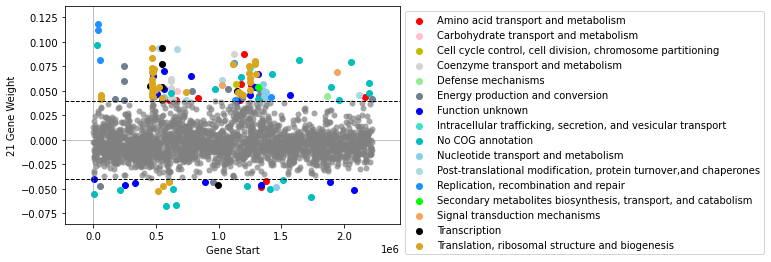

In [110]:
plot_gene_weights(ica_data, 21)

In [111]:
## Most likely a composite iModulon consisting of some of the following:
## Translation/Ribosome iModulon
## Cell division iModulon
## Porphyrin iModulon


# Uncomment below to see genes enriched in this iModulon

#ica_data.view_imodulon(21)[0:50]
#ica_data.view_imodulon(21)[50:100]
#ica_data.view_imodulon(21)[100:]

<AxesSubplot:ylabel='19 iModulon\nActivity'>

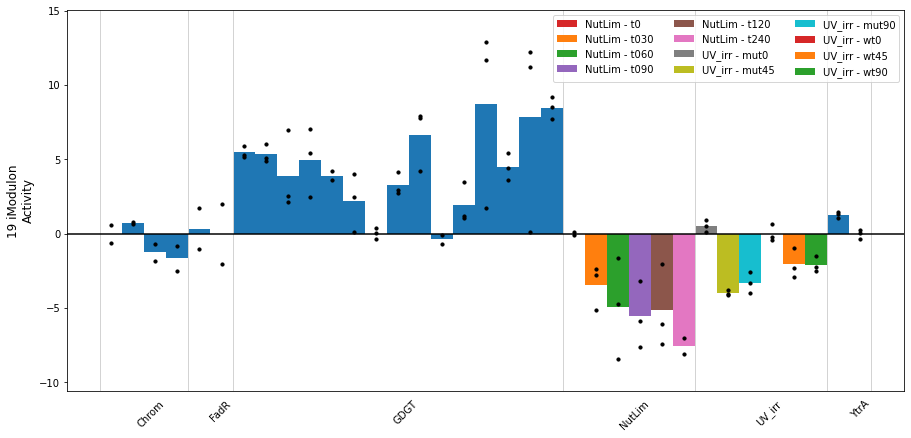

In [112]:
fig, ax = plt.subplots(figsize=(15, 7))

plot_activities(ica_data, 19, highlight=['NutLim', 'UV_irr'], ax=ax)

### iModulon 23: Putative Sulfur Assimilation iModulon [E coli Ortholog: CysB]

In [113]:
get_kegg_enrichements(23, 'pathway')

imodulon   kegg_id        pvalue    qvalue  precision  recall   f1score  \
41       23  map00920  7.583891e-09  0.000001   0.444444   0.500  0.470588   
42       23  map01120  5.148720e-05  0.005071   0.033557   0.625  0.063694   

     TP  target_set_size  imodulon_size  \
41  4.0              9.0            8.0   
42  5.0            149.0            8.0   

                                    pathway_name  
41                             Sulfur metabolism  
42  Microbial metabolism in diverse environments

In [114]:
get_kegg_enrichements(23, 'module')

imodulon kegg_id        pvalue    qvalue  precision  recall   f1score   TP  \
39       23  M00176  2.779658e-08  0.000005        1.0   0.375  0.545455  3.0   

    target_set_size  imodulon_size  \
39              3.0            8.0   

                                       module_name  
39  Assimilatory sulfate reduction, sulfate => H2S

<AxesSubplot:xlabel='Gene Start', ylabel='23 Gene Weight'>

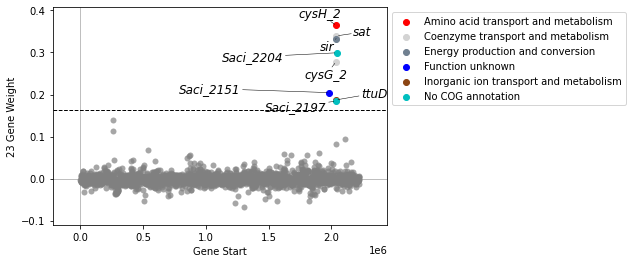

In [115]:
plot_gene_weights(ica_data, 23)

In [116]:
# Threshold may need to be manually curated down to 0.1 to allow mtoX into this iModulon

cond = np.abs(ica_data.M[23]) > 0.1

ica_data.gene_table.loc[cond]

gene_name old_locus_tag prokka_locus_tag synonyms      start  \
SACI_RS01485  Saci_0304     Saci_0304      Sacid_00300      NaN   258506.0   
SACI_RS01490       mtoX     Saci_0305      Sacid_00301      NaN   259029.0   
SACI_RS10405  Saci_2151     Saci_2151      Sacid_02149      NaN  1983935.0   
SACI_RS10620  Saci_2197     Saci_2197      Sacid_02197      NaN  2036205.0   
SACI_RS10625       ttuD     Saci_2198      Sacid_02198      NaN  2036450.0   
SACI_RS10635     cysG_2     Saci_2200      Sacid_02200      NaN  2037777.0   
SACI_RS10640        sir     Saci_2201      Sacid_02201      NaN  2038462.0   
SACI_RS10645     cysH_2     Saci_2202      Sacid_02202      NaN  2040367.0   
SACI_RS10650        sat     Saci_2203      Sacid_02203      NaN  2041202.0   
SACI_RS10655  Saci_2204     Saci_2204      Sacid_02204      NaN  2042434.0   

                    end strand                               gene_product  \
SACI_RS01485   259060.0      -                       hypothetical protein   
SACI_RS01490   260429.0      -            selenium-binding family protein   
SACI_RS10405  1984822.0      +  sulfite exporter TauE/SafE family protein   
SACI_RS10620  2036453.0      -                       hypothetical protein   
SACI_RS10625  2037328.0      -                          sulfurtransferase   
SACI_RS10635  2038472.0      -   uroporphyrinogen-III C-methyltransferase   
SACI_RS10640  2040240.0      -                  nitrite/sulfite reductase   
SACI_RS10645  2041086.0      -          phosphoadenylyl-sulfate reductase   
SACI_RS10650  2042437.0      +                sulfate adenylyltransferase   
SACI_RS10655  2042739.0      +                       hypothetical protein   

                                            gene_product_prokka  \
SACI_RS01485                               hypothetical protein   
SACI_RS01490                               Methanethiol oxidase   
SACI_RS10405                               hypothetical protein   
SACI_RS10620                               hypothetical protein   
SACI_RS10625                        Sulfur carrier protein TtuD   
SACI_RS10635                                  Siroheme synthase   
SACI_RS10640                     Sulfite reductase [ferredoxin]   
SACI_RS10645  Thioredoxin-dependent 5'-adenylylsulfate reduc...   
SACI_RS10650                        Sulfate adenylyltransferase   
SACI_RS10655                               hypothetical protein   

                                                 COG     uniprot       refseq  \
SACI_RS01485                       No COG annotation  A0A0U2Y921  NC_007181.1   
SACI_RS01490                        Function unknown  A0A0U3HAR4  NC_007181.1   
SACI_RS10405                        Function unknown  A0A0U3GUX1  NC_007181.1   
SACI_RS10620                       No COG annotation  A0A0U2VXH2  NC_007181.1   
SACI_RS10625  Inorganic ion transport and metabolism  A0A0U2YA58  NC_007181.1   
SACI_RS10635       Coenzyme transport and metabolism  A0A0U2NCI9  NC_007181.1   
SACI_RS10640        Energy production and conversion  A0A0U2Y2E5  NC_007181.1   
SACI_RS10645     Amino acid transport and metabolism  A0A0U2X312  NC_007181.1   
SACI_RS10650       Coenzyme transport and metabolism  A0A0U3FXL2  NC_007181.1   
SACI_RS10655                       No COG annotation  A0A0U2NGN4  NC_007181.1   

             regulator  
SACI_RS01485       NaN  
SACI_RS01490       NaN  
SACI_RS10405       NaN  
SACI_RS10620       NaN  
SACI_RS10625       NaN  
SACI_RS10635       NaN  
SACI_RS10640       NaN  
SACI_RS10645       NaN  
SACI_RS10650       NaN  
SACI_RS10655       NaN

### iModulon 31: Putative Carbon/Nitrogen Fixation iModulon

In [117]:
get_kegg_enrichements(31, 'pathway').head()

imodulon   kegg_id        pvalue        qvalue  precision    recall  \
45       31  map00633  2.649602e-09  5.219716e-07   1.000000  0.222222   
46       31  map00620  7.801612e-09  7.684587e-07   0.175000  0.388889   
47       31  map00650  7.399756e-08  4.859173e-06   0.187500  0.333333   
48       31  map00290  1.261122e-06  6.211026e-05   0.333333  0.222222   
49       31  map00010  3.362287e-06  1.103951e-04   0.151515  0.277778   

     f1score   TP  target_set_size  imodulon_size  \
45  0.363636  4.0              4.0           18.0   
46  0.241379  7.0             40.0           18.0   
47  0.240000  6.0             32.0           18.0   
48  0.266667  4.0             12.0           18.0   
49  0.196078  5.0             33.0           18.0   

                                   pathway_name  
45                     Nitrotoluene degradation  
46                          Pyruvate metabolism  
47                         Butanoate metabolism  
48  Valine, leucine and isoleucine biosynthesis  
49                 Glycolysis / Gluconeogenesis

In [118]:
get_kegg_enrichements(31, 'module')

imodulon kegg_id        pvalue    qvalue  precision    recall   f1score  \
41       31  M00307  3.935652e-08  0.000007   0.666667  0.222222  0.333333   
42       31  M00620  1.261122e-06  0.000107   0.333333  0.222222  0.266667   
43       31  M00173  1.186849e-05  0.000673   0.200000  0.222222  0.210526   
44       31  M00374  7.302165e-05  0.003103   0.129032  0.222222  0.163265   
45       31  M00019  5.726591e-04  0.019470   0.400000  0.111111  0.173913   
46       31  M00432  8.549976e-04  0.020764   0.333333  0.111111  0.166667   
47       31  M00570  8.549976e-04  0.020764   0.333333  0.111111  0.166667   

     TP  target_set_size  imodulon_size  \
41  4.0              6.0           18.0   
42  4.0             12.0           18.0   
43  4.0             20.0           18.0   
44  4.0             31.0           18.0   
45  2.0              5.0           18.0   
46  2.0              6.0           18.0   
47  2.0              6.0           18.0   

                                          module_name  
41         Pyruvate oxidation, pyruvate => acetyl-CoA  
42  Incomplete reductive citrate cycle, acetyl-CoA...  
43     Reductive citrate cycle (Arnon-Buchanan cycle)  
44                Dicarboxylate-hydroxybutyrate cycle  
45  Valine/isoleucine biosynthesis, pyruvate => va...  
46  Leucine biosynthesis, 2-oxoisovalerate => 2-ox...  
47  Isoleucine biosynthesis, threonine => 2-oxobut...

<AxesSubplot:xlabel='Gene Start', ylabel='31 Gene Weight'>

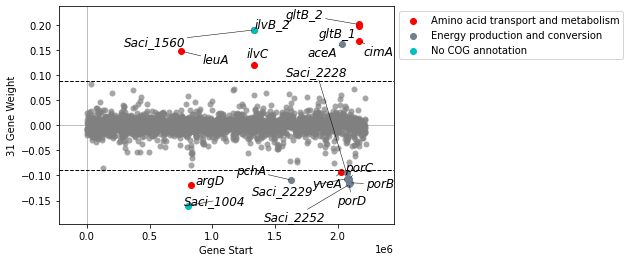

In [119]:
plot_gene_weights(ica_data, 31)

In [120]:
ica_data.view_imodulon(31)

gene_weight  gene_name old_locus_tag prokka_locus_tag  \
SACI_RS04490     0.147968       leuA     Saci_0940      Sacid_00916   
SACI_RS04795    -0.160334  Saci_1004     Saci_1004      Sacid_00978   
SACI_RS04910    -0.118874       argD     Saci_1028      Sacid_01002   
SACI_RS07430     0.120230       ilvC     Saci_1559      Sacid_01524   
SACI_RS07435     0.190334  Saci_1560     Saci_1560      Sacid_01525   
SACI_RS07440     0.191019     ilvB_2     Saci_1561      Sacid_01526   
SACI_RS08920    -0.109200       pchA     Saci_1857      Sacid_01827   
SACI_RS10580    -0.093555       yveA     Saci_2189      Sacid_02188   
SACI_RS10590     0.161409       aceA     Saci_2191      Sacid_02190   
SACI_RS10770    -0.094995  Saci_2228     Saci_2228      Sacid_02229   
SACI_RS10775    -0.106723  Saci_2229     Saci_2229      Sacid_02230   
SACI_RS10880    -0.106948       porC     Saci_2250      Sacid_02251   
SACI_RS10885    -0.115505       porD     Saci_2251      Sacid_02252   
SACI_RS10890    -0.117840  Saci_2252     Saci_2252      Sacid_02253   
SACI_RS10895    -0.114625       porB     Saci_2253      Sacid_02254   
SACI_RS11230     0.199034     gltB_1     Saci_2320      Sacid_02323   
SACI_RS11235     0.201198     gltB_2     Saci_2321      Sacid_02324   
SACI_RS11255     0.168554       cimA     Saci_2325      Sacid_02328   

                  synonyms      start        end strand  \
SACI_RS04490           NaN   753048.0   754208.0      +   
SACI_RS04795           NaN   805226.0   805438.0      +   
SACI_RS04910           NaN   827654.0   828943.0      +   
SACI_RS07430           NaN  1331979.0  1332977.0      -   
SACI_RS07435           NaN  1332958.0  1333353.0      -   
SACI_RS07440           NaN  1333331.0  1335049.0      -   
SACI_RS08920           NaN  1631234.0  1632679.0      -   
SACI_RS10580           NaN  2025549.0  2027396.0      -   
SACI_RS10590           NaN  2030804.0  2032117.0      +   
SACI_RS10770           NaN  2070581.0  2071147.0      -   
SACI_RS10775           NaN  2071135.0  2072970.0      -   
SACI_RS10880           NaN  2092967.0  2093530.0      +   
SACI_RS10885           NaN  2093514.0  2093780.0      +   
SACI_RS10890           NaN  2093777.0  2094970.0      +   
SACI_RS10895           NaN  2094939.0  2095829.0      +   
SACI_RS11230          gltB  2166873.0  2169011.0      +   
SACI_RS11235  gltB, purF_3  2169008.0  2170987.0      +   
SACI_RS11255           NaN  2173252.0  2174823.0      +   

                                                   gene_product  \
SACI_RS04490                         2-isopropylmalate synthase   
SACI_RS04795                               hypothetical protein   
SACI_RS04910   acetyl ornithine aminotransferase family protein   
SACI_RS07430                        ketol-acid reductoisomerase   
SACI_RS07435                      ACT domain-containing protein   
SACI_RS07440                acetolactate synthase large subunit   
SACI_RS08920              aldehyde dehydrogenase family protein   
SACI_RS10580                                APC family permease   
SACI_RS10590                                   isocitrate lyase   
SACI_RS10770         indolepyruvate oxidoreductase subunit beta   
SACI_RS10775  indolepyruvate ferredoxin oxidoreductase subun...   
SACI_RS10880   2-oxoacid:acceptor oxidoreductase family protein   
SACI_RS10885                             4Fe-4S binding protein   
SACI_RS10890                 pyruvate ferredoxin oxidoreductase   
SACI_RS10895                     pyruvate synthase subunit beta   
SACI_RS11230                                 glutamate synthase   
SACI_RS11235                                 glutamate synthase   
SACI_RS11255                               citramalate synthase   

                                        gene_product_prokka  \
SACI_RS04490                     2-isopropylmalate synthase   
SACI_RS04795                           hypothetical protein   
SACI_RS04910               Acetylornithine aminotransferase   
SACI_RS07430    

<AxesSubplot:ylabel='19 iModulon\nActivity'>

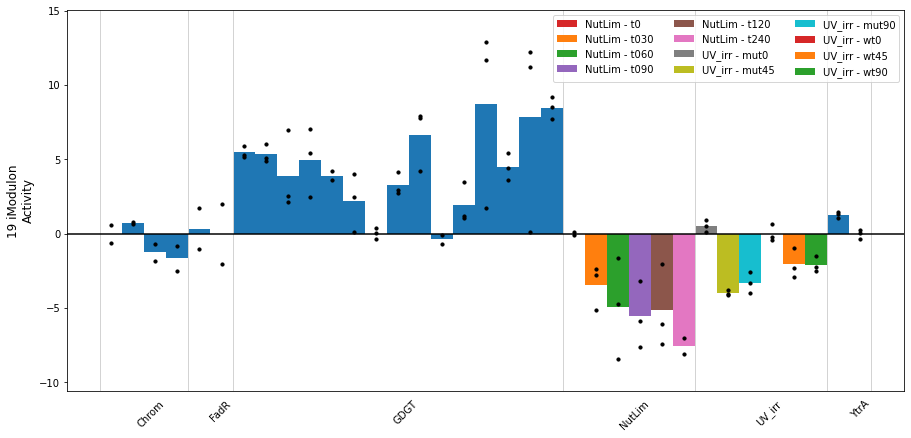

In [121]:
fig, ax = plt.subplots(figsize=(15, 7))

plot_activities(ica_data, 19, highlight=['NutLim', 'UV_irr'], ax=ax)

## Remaining iModulons

In [122]:
inv_imods = ['XylR/AraC', 'YtrA-OE', 'LysM', 'FadR-KO', 'ArnRAB', 'FadR',
               25, 26, 39, 4, 7, 9, 10, 17, 19, 21, 23, 31]

print(set(ica_data.imodulon_names) - set(inv_imods))

{0, 1, 2, 3, 'single_gene_6', 5, 6, 8, 14, 18, 20, 22, 30, 'single_gene_5', 32, 33, 34, 35, 36, 37, 38, 41, 42, 44, 'single_gene_1', 'single_gene_2', 'single_gene_4'}


### iModulon 2: Cytochrome-related iModulon [E coli Ortholog: OxyR]

<AxesSubplot:xlabel='Gene Start', ylabel='2 Gene Weight'>

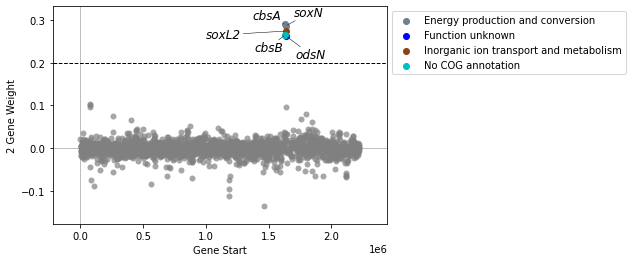

In [123]:
plot_gene_weights(ica_data, 2)

In [124]:
ica_data.view_imodulon(2)

gene_weight gene_name old_locus_tag prokka_locus_tag synonyms  \
SACI_RS08925     0.289731      cbsA     Saci_1858      Sacid_01828      NaN   
SACI_RS08930     0.266023      cbsB     Saci_1859      Sacid_01829      NaN   
SACI_RS08935     0.274232     soxL2     Saci_1860      Sacid_01830      NaN   
SACI_RS08940     0.286235      soxN     Saci_1861      Sacid_01831   petB_1   
SACI_RS08945     0.262889      odsN     Saci_1862      Sacid_01832      NaN   

                  start        end strand  \
SACI_RS08925  1633061.0  1634449.0      +   
SACI_RS08930  1634446.0  1635378.0      +   
SACI_RS08935  1635417.0  1636394.0      +   
SACI_RS08940  1636440.0  1638038.0      +   
SACI_RS08945  1638022.0  1638354.0      +   

                                                 gene_product  \
SACI_RS08925                    cytochrome b558/566 subunit A   
SACI_RS08930                    cytochrome b558/566 subunit B   
SACI_RS08935                 Rieske iron-sulfur protein SoxL2   
SACI_RS08940  cytochrome bc complex cytochrome b subunit SoxN   
SACI_RS08945            antibiotic biosynthesis monooxygenase   

               gene_product_prokka                                     COG  \
SACI_RS08925  hypothetical protein        Energy production and conversion   
SACI_RS08930  hypothetical protein                       No COG annotation   
SACI_RS08935  hypothetical protein  Inorganic ion transport and metabolism   
SACI_RS08940         Cytochrome b6        Energy production and conversion   
SACI_RS08945  hypothetical protein                        Function unknown   

                    uniprot       refseq regulator  
SACI_RS08925     A0A0U3GMR5  NC_007181.1       NaN  
SACI_RS08930     A0A0U3FC13  NC_007181.1       NaN  
SACI_RS08935     A0A0U3GPQ9  NC_007181.1       NaN  
SACI_RS08940     A0A0U3GR09  NC_007181.1       NaN  
SACI_RS08945  UPI0002B26481  NC_007181.1       NaN

<AxesSubplot:ylabel='2 iModulon\nActivity'>

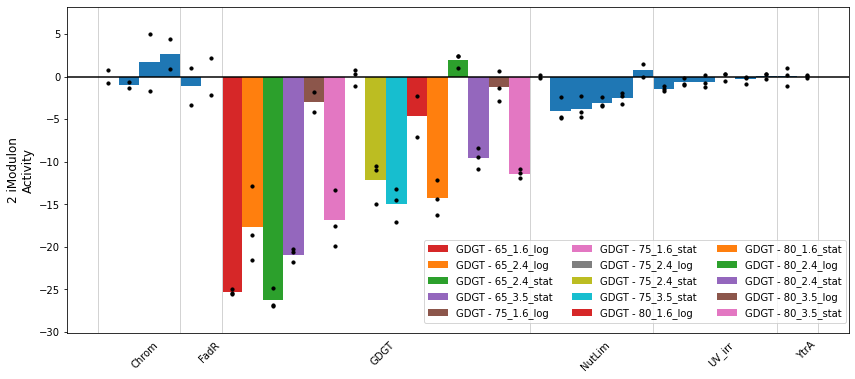

In [125]:
fig, ax = plt.subplots(figsize=(14, 6))

plot_activities(ica_data, 2, highlight=['GDGT'], ax=ax,
                legend_kwargs={'bbox_to_anchor': (0.45, 0.3)})

### iModulon 18: UV-tfb3 iModulon

<AxesSubplot:xlabel='Gene Start', ylabel='18 Gene Weight'>

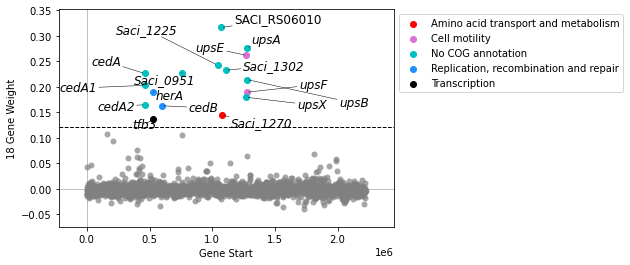

In [126]:
plot_gene_weights(ica_data, 18)

In [127]:
ica_data.view_imodulon(18)

gene_weight     gene_name old_locus_tag prokka_locus_tag  \
SACI_RS11810     0.164617         cedA2     Saci_0567      Sacid_00553   
SACI_RS02695     0.226076          cedA     Saci_0568      Sacid_00554   
SACI_RS02700     0.202697         cedA1     Saci_0569      Sacid_00555   
SACI_RS03170     0.135878          tfb3     Saci_0665      Sacid_00647   
SACI_RS03180     0.190563          herA     Saci_0667      Sacid_00649   
SACI_RS03575     0.162646          cedB     Saci_0748      Sacid_00730   
SACI_RS04540     0.227926     Saci_0951     Saci_0951      Sacid_00927   
SACI_RS05840     0.242446     Saci_1225     Saci_1225      Sacid_01202   
SACI_RS06010     0.316290  SACI_RS06010           NaN      Sacid_01236   
SACI_RS06065     0.143969     Saci_1270     Saci_1270      Sacid_01247   
SACI_RS06225     0.232534     Saci_1302     Saci_1302      Sacid_01278   
SACI_RS07125     0.179359          upsX     Saci_1493      Sacid_01460   
SACI_RS07130     0.261556          upsE     Saci_1494      Sacid_01461   
SACI_RS07135     0.189187          upsF     Saci_1495      Sacid_01462   
SACI_RS07140     0.275792          upsA     Saci_1496      Sacid_01463   
SACI_RS11670     0.214154          upsB           NaN      Sacid_01464   

             synonyms      start        end strand  \
SACI_RS11810      NaN   460159.0   460317.0      -   
SACI_RS02695      NaN   460333.0   461115.0      -   
SACI_RS02700      NaN   461116.0   461352.0      -   
SACI_RS03170      NaN   526865.0   527452.0      +   
SACI_RS03180      NaN   529180.0   530820.0      -   
SACI_RS03575      NaN   597891.0   599684.0      +   
SACI_RS04540      NaN   760719.0   761144.0      -   
SACI_RS05840      NaN  1042172.0  1042501.0      +   
SACI_RS06010      NaN  1071231.0  1071434.0      +   
SACI_RS06065      NaN  1080419.0  1081312.0      +   
SACI_RS06225      NaN  1109624.0  1110925.0      -   
SACI_RS07125      NaN  1270248.0  1272275.0      +   
SACI_RS07130      NaN  1272319.0  1273728.0      +   
SACI_RS07135      NaN  1273709.0  1275175.0      +   
SACI_RS07140      NaN  1275200.0  1275631.0      +   
SACI_RS11670      NaN  1275637.0  1276026.0      +   

                                                   gene_product  \
SACI_RS11810                           DNA import protein CedA2   
SACI_RS02695                            DNA import protein CedA   
SACI_RS02700                           DNA import protein CedA1   
SACI_RS03170          TFIIB-type zinc ribbon-containing protein   
SACI_RS03180  HerA helicase, ATP-binding protein (VirB4/HerA...   
SACI_RS03575                                ATP-binding protein   
SACI_RS04540                               hypothetical protein   
SACI_RS05840                               hypothetical protein   
SACI_RS06010                               hypothetical protein   
SACI_RS06065                                MFS family permease   
SACI_RS06225                               hypothetical protein   
SACI_RS07125                               hypothetical protein   
SACI_RS07130         type II/IV secretion system ATPase subunit   
SACI_RS07135                               hypothetical protein   
SACI_RS07140                               hypothetical protein   
SACI_RS11670                               hypothetical protein   

               gene_product_prokka                                    COG  \
SACI_RS11810  hypothetical protein                      No COG annotation   
SACI_RS02695  hypothetical protein                      No COG annotation   
SACI_RS02700  hypothetical protein                      No COG annotation   
SACI_RS03170  hypothetical protein                          Transcription   
SACI_RS03180  hypothetical protein  Replication, recombination and repair   
SACI_RS03575  hypothetical protein  Replication, recombination and repair   
SACI_RS04540  hypothetical protein                      No COG annotation   
SACI_RS05840  hypothetical protein                      No COG annotation   
SAC

<AxesSubplot:ylabel='18 iModulon\nActivity'>

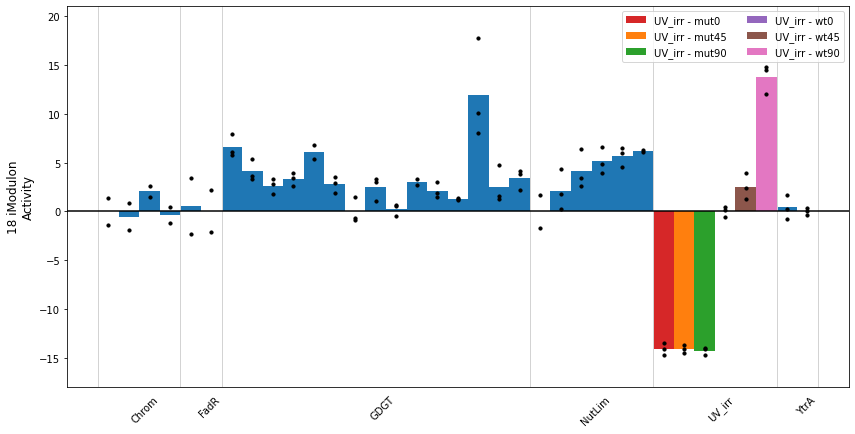

In [128]:
fig, ax = plt.subplots(figsize=(14, 7))

plot_activities(ica_data, 18, highlight='UV_irr', ax=ax)

### iModulon 34: Putative Replication-related iModulon

<AxesSubplot:xlabel='Gene Start', ylabel='34 Gene Weight'>

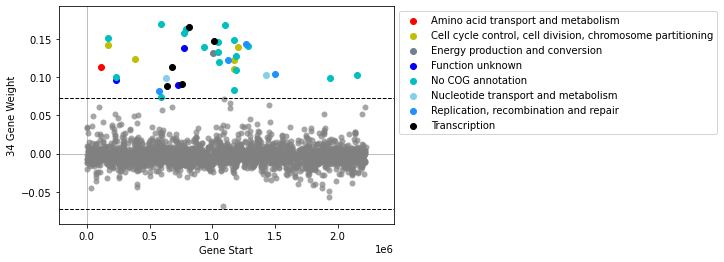

In [129]:
plot_gene_weights(ica_data, 34)

In [130]:
ica_data.view_imodulon(34)

gene_weight     gene_name old_locus_tag prokka_locus_tag  \
SACI_RS00685     0.112974     Saci_0144     Saci_0144      Sacid_00139   
SACI_RS00980     0.151865          segB     Saci_0203      Sacid_00197   
SACI_RS00985     0.142533          segA     Saci_0204      Sacid_00198   
SACI_RS01345     0.099603     Saci_0276     Saci_0276      Sacid_00272   
SACI_RS01350     0.095981     Saci_0277     Saci_0277      Sacid_00273   
SACI_RS02185     0.123250     Saci_0451     Saci_0451      Sacid_00445   
SACI_RS03440     0.081789        cdc6_1     Saci_0722      Sacid_00700   
SACI_RS03550     0.168987     Saci_0743     Saci_0743      Sacid_00725   
SACI_RS03555     0.074320     Saci_0744     Saci_0744      Sacid_00726   
SACI_RS03775     0.098866         dcd_1     Saci_0789      Sacid_00769   
SACI_RS03830     0.088568     Saci_0800     Saci_0800      Sacid_00780   
SACI_RS04040     0.113204          nikR     Saci_0843      Sacid_00823   
SACI_RS04305     0.090171     Saci_0901     Saci_0901      Sacid_00877   
SACI_RS04500     0.090981     Saci_0942     Saci_0942      Sacid_00918   
SACI_RS04630     0.158116     Saci_0969     Saci_0969      Sacid_00945   
SACI_RS04635     0.138693     Saci_0970     Saci_0970      Sacid_00946   
SACI_RS04720     0.163547     Saci_0988     Saci_0988      Sacid_00963   
SACI_RS04830     0.165430     Saci_1012     Saci_1012      Sacid_00985   
SACI_RS05390     0.140005     Saci_1130     Saci_1130      Sacid_01106   
SACI_RS05670     0.131602     Saci_1189     Saci_1189      Sacid_01167   
SACI_RS05690     0.147429          arnC     Saci_1193      Sacid_01171   
SACI_RS05855     0.132550     Saci_1228     Saci_1228      Sacid_01205   
SACI_RS05860     0.146172     Saci_1229     Saci_1229      Sacid_01206   
SACI_RS05900     0.119760     Saci_1237     Saci_1237      Sacid_01214   
SACI_RS06190     0.168182     Saci_1295     Saci_1295      Sacid_01271   
SACI_RS06310     0.121998         rgy_3           NaN      Sacid_01295   
SACI_RS06565     0.111134        ftsH_6     Saci_1372      Sacid_01345   
SACI_RS06570     0.122794     Saci_1373     Saci_1373      Sacid_01346   
SACI_RS06575     0.082685          cdvA     Saci_1374      Sacid_01347   
SACI_RS06580     0.149072     Saci_1376     Saci_1376      Sacid_01348   
SACI_RS06680     0.127684     Saci_1397     Saci_1397      Sacid_01367   
SACI_RS06685     0.108871     Saci_1398     Saci_1398      Sacid_01368   
SACI_RS06775     0.139910     Saci_1416     Saci_1416      Sacid_01386   
SACI_RS07110     0.143622          xerD     Saci_1490      Sacid_01457   
SACI_RS07175     0.140531     Saci_1504     Saci_1504      Sacid_01472   
SACI_RS07980     0.102782         dcd_2     Saci_1672      Sacid_01635   
SACI_RS08320     0.103937           hjc     Saci_1741      Sacid_01705   
SACI_RS10225     0.098489     Saci_2115     Saci_2115      Sacid_02112   
SACI_RS11770     0.102985  SACI_RS11770           NaN              NaN   

               synonyms      start        end strand  \
SACI_RS00685        NaN   113681.0   114820.0      +   
SACI_RS00980        NaN   165123.0   165578.0      -   
SACI_RS00985  parA, soj   165575.0   166237.0      -   
SACI_RS01345        NaN   233183.0   233515.0      +   
SACI_RS01350        NaN   233532.0   234461.0      +   
SACI_RS02185        NaN   383513.0   384157.0      -   
SACI_RS03440        NaN   578164.0   579357.0      -   
SACI_RS03550        NaN   594856.0   595146.0      +   
SACI_RS03555        NaN   595153.0   596007.0      +   
SACI_RS03775        NaN   632052.0   632570.0      +   
SACI_RS03830        NaN   641612.0   641908.0      +   
SACI_RS04040        NaN   678974.0   679126.0      +   
SACI_RS04305        NaN   723139.0   723690.0      -   
SACI_RS04500        NaN   754815.0   754991.0      -   
SACI_RS04630        NaN   774587.0   775123.0      +   
SACI_RS04635        NaN   775102.0   775416.0      +   
SACI_RS04720        NaN   791134.0   791364.0      +   
SACI_RS04830        NaN   811574.0   811897.0

<AxesSubplot:ylabel='34 iModulon\nActivity'>

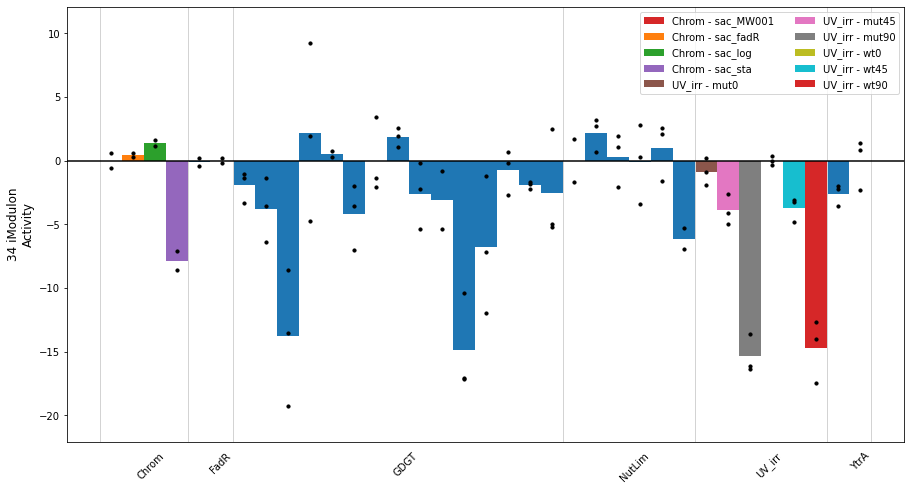

In [131]:
fig, ax = plt.subplots(figsize=(15, 8))

plot_activities(ica_data, 34, highlight=['Chrom','UV_irr'], ax=ax)

### iModulon 35: Composite iModulon 4 (Putative Pyrimidine metabolism + Translation/RNA iModulon)

<AxesSubplot:xlabel='Gene Start', ylabel='35 Gene Weight'>

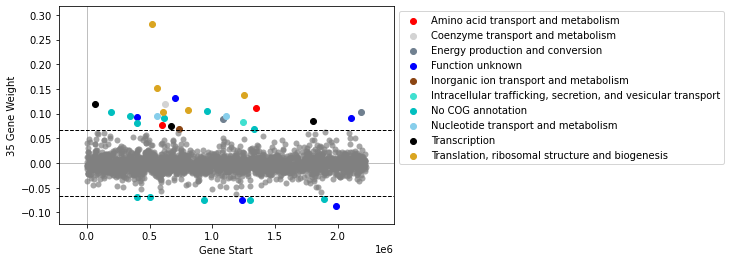

In [132]:
plot_gene_weights(ica_data, 35)

In [133]:
ica_data.view_imodulon(35)

gene_weight     gene_name old_locus_tag prokka_locus_tag  \
SACI_RS00405     0.120082     Saci_0087     Saci_0087      Sacid_00083   
SACI_RS01115     0.103019  SACI_RS01115           NaN      Sacid_00226   
SACI_RS01980     0.096013     Saci_0405     Saci_0405      Sacid_00400   
SACI_RS02300     0.093689     Saci_0476     Saci_0476      Sacid_00468   
SACI_RS02305     0.080317     Saci_0477     Saci_0477      Sacid_00469   
SACI_RS02310    -0.069775     Saci_0478     Saci_0478      Sacid_00470   
SACI_RS11555    -0.068909  SACI_RS11555           NaN              NaN   
SACI_RS03110     0.280566     Saci_0653     Saci_0653      Sacid_00635   
SACI_RS03315     0.151008     Saci_0697     Saci_0697              NaN   
SACI_RS03325     0.095259           upp     Saci_0699      Sacid_00678   
SACI_RS03590     0.076804          lysZ     Saci_0751      Sacid_00733   
SACI_RS03630     0.102868     Saci_0759     Saci_0759      Sacid_00741   
SACI_RS03705     0.090769     Saci_0774     Saci_0774      Sacid_00753   
SACI_RS03740     0.119686     Saci_0781     Saci_0781      Sacid_00760   
SACI_RS04000     0.075217     Saci_0835     Saci_0835      Sacid_00814   
SACI_RS11610     0.132598     Saci_0873     Saci_0873      Sacid_00851   
SACI_RS11615     0.069784     Saci_0915     Saci_0915      Sacid_00891   
SACI_RS04820     0.106832     Saci_1010     Saci_1010      Sacid_00983   
SACI_RS05390    -0.075739     Saci_1130     Saci_1130      Sacid_01106   
SACI_RS11845     0.105876  SACI_RS11845           NaN              NaN   
SACI_RS06105     0.088208     Saci_1278     Saci_1278      Sacid_01255   
SACI_RS06245     0.095543          pyrH     Saci_1306      Sacid_01282   
SACI_RS11660    -0.074521     Saci_1450     Saci_1450              NaN   
SACI_RS06975     0.082026          secE     Saci_1461      Sacid_01428   
SACI_RS07005     0.137219     Saci_1467     Saci_1467      Sacid_01434   
SACI_RS11860    -0.074477     Saci_1527     Saci_1527      Sacid_01494   
SACI_RS07435     0.069221     Saci_1560     Saci_1560      Sacid_01525   
SACI_RS07535     0.110837          hisE     Saci_1580      Sacid_01545   
SACI_RS09595     0.086050     Saci_1984     Saci_1984      Sacid_01974   
SACI_RS11900    -0.073633     Saci_2071     Saci_2071      Sacid_02066   
SACI_RS10405    -0.086501     Saci_2151     Saci_2151      Sacid_02149   
SACI_RS10950     0.090482     Saci_2264     Saci_2264      Sacid_02265   
SACI_RS11320     0.103074          ndhE     Saci_2340      Sacid_02340   

             synonyms      start        end strand  \
SACI_RS00405      NaN    66004.0    66204.0      +   
SACI_RS01115      NaN   191187.0   191366.0      -   
SACI_RS01980      NaN   347149.0   347688.0      -   
SACI_RS02300      NaN   400929.0   401072.0      -   
SACI_RS02305      NaN   401100.0   401420.0      -   
SACI_RS02310      NaN   401417.0   401848.0      -   
SACI_RS11555      NaN   499991.0   500131.0      +   
SACI_RS03110      NaN   517716.0   518114.0      -   
SACI_RS03315      NaN   556705.0   556893.0      -   
SACI_RS03325      NaN   557216.0   557866.0      +   
SACI_RS03590      NaN   601207.0   601992.0      +   
SACI_RS03630      NaN   606840.0   607118.0      +   
SACI_RS03705      NaN   617722.0   617946.0      +   
SACI_RS03740      NaN   624041.0   624703.0      +   
SACI_RS04000      NaN   668837.0   669043.0      +   
SACI_RS11610      NaN   700810.0   700977.0      -   
SACI_RS11615      NaN   734164.0   734307.0      +   
SACI_RS04820      NaN   810474.0   810962.0      +   
SACI_RS05390      NaN   937878.0   938138.0      +   
SACI_RS11845      NaN   955170.0   955289.0      +   
SACI_RS06105      NaN  1087280.0  1087741.0      -   
SACI_RS06245      NaN  1112829.0  1113512.0      -   
SACI_RS11660      NaN  1240242.0  1240400.0      +   
SACI_RS06975      NaN  1247457.0  1247654.0      -   
SACI_RS07005      NaN  1250546.0  1250707.0      -   
SACI_RS11860      NaN  1303973.0  1304149.0      +   
SACI_RS07435      NaN  1332958.0  13333

<AxesSubplot:ylabel='35 iModulon\nActivity'>

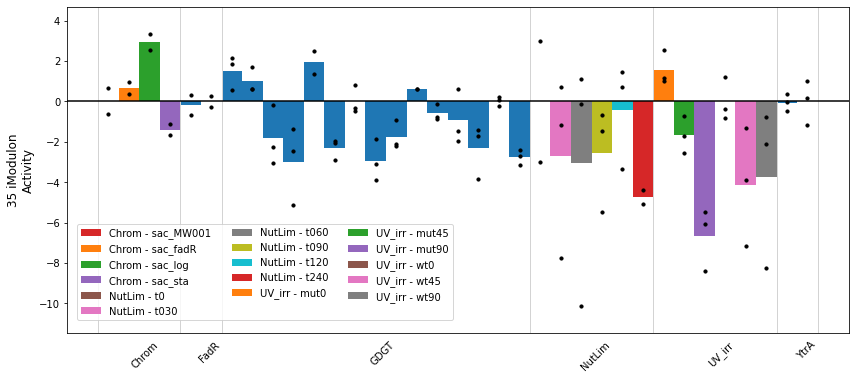

In [134]:
fig, ax = plt.subplots(figsize=(14, 6))

plot_activities(ica_data, 35, highlight=['Chrom', 'NutLim', 'UV_irr'], ax=ax,
                legend_kwargs={'bbox_to_anchor':(0.5, 0.35)})

### iModulon 5: Uncharacterized iModulon

Consists of:

- Niacin/NAD(H) transporter
- D-xylose:proton symporter
- 2 hypothetical proteins
- Related to iModulon 31 (put. C/N fixation)

Putative transport iModulon?

<AxesSubplot:xlabel='Gene Start', ylabel='5 Gene Weight'>

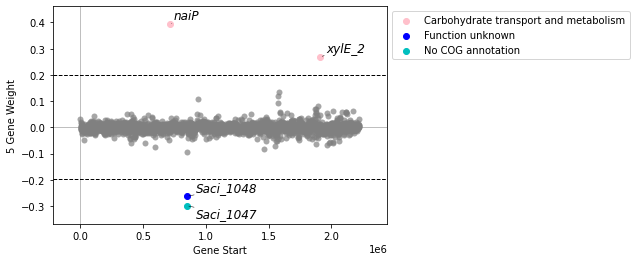

In [135]:
plot_gene_weights(ica_data, 5)

In [136]:
ica_data.view_imodulon(5)

gene_weight  gene_name old_locus_tag prokka_locus_tag synonyms  \
SACI_RS04230     0.392167       naiP     Saci_0886      Sacid_00863      NaN   
SACI_RS05000    -0.298456  Saci_1047     Saci_1047      Sacid_01021      NaN   
SACI_RS05005    -0.262939  Saci_1048     Saci_1048      Sacid_01022      NaN   
SACI_RS10120     0.268527     xylE_2     Saci_2095      Sacid_02091      NaN   

                  start        end strand                      gene_product  \
SACI_RS04230   712521.0   714002.0      -                   MFS transporter   
SACI_RS05000   848080.0   848499.0      -              hypothetical protein   
SACI_RS05005   848599.0   848853.0      +  DUF504 domain-containing protein   
SACI_RS10120  1912263.0  1913636.0      -                   MFS transporter   

                                        gene_product_prokka  \
SACI_RS04230  Putative niacin/nicotinamide transporter NaiP   
SACI_RS05000                           hypothetical protein   
SACI_RS05005                           hypothetical protein   
SACI_RS10120                      D-xylose-proton symporter   

                                                COG     uniprot       refseq  \
SACI_RS04230  Carbohydrate transport and metabolism  A0A0U3HAF2  NC_007181.1   
SACI_RS05000                      No COG annotation  A0A0U3H1U4  NC_007181.1   
SACI_RS05005                       Function unknown  A0A0U3H296  NC_007181.1   
SACI_RS10120  Carbohydrate transport and metabolism  A0A0U3GM32  NC_007181.1   

             regulator  
SACI_RS04230       NaN  
SACI_RS05000       NaN  
SACI_RS05005       NaN  
SACI_RS10120       NaN

### iModulon 41: Putative Thiamine (Vit B1) iModulon (Potentially Riboflavin-related / Heavy-Metal related)

<AxesSubplot:xlabel='Gene Start', ylabel='41 Gene Weight'>

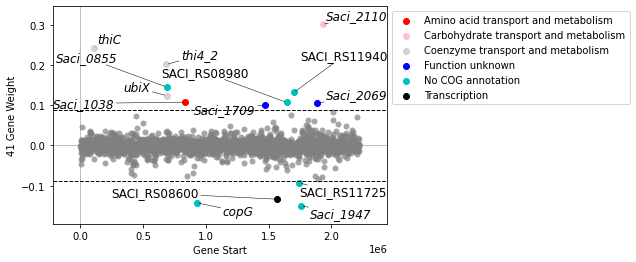

In [137]:
plot_gene_weights(ica_data, 41)

In [138]:
ica_data.view_imodulon(41)

gene_weight     gene_name old_locus_tag prokka_locus_tag  \
SACI_RS00650     0.242554          thiC     Saci_0137      Sacid_00132   
SACI_RS04090     0.201410        thi4_2     Saci_0854      Sacid_00833   
SACI_RS11600     0.145373     Saci_0855     Saci_0855              NaN   
SACI_RS04095     0.123935          ubiX     Saci_0856      Sacid_00834   
SACI_RS04960     0.107777     Saci_1038     Saci_1038      Sacid_01012   
SACI_RS05360    -0.142695          copG     Saci_1124      Sacid_01100   
SACI_RS11700     0.100666     Saci_1709     Saci_1709              NaN   
SACI_RS08600    -0.133553  SACI_RS08600           NaN      Sacid_01765   
SACI_RS08980     0.106838  SACI_RS08980           NaN              NaN   
SACI_RS11940     0.131866  SACI_RS11940           NaN              NaN   
SACI_RS11725    -0.093736  SACI_RS11725           NaN              NaN   
SACI_RS09400    -0.149704     Saci_1947     Saci_1947      Sacid_01934   
SACI_RS10005     0.104651     Saci_2069     Saci_2069      Sacid_02064   
SACI_RS10200     0.300793     Saci_2110     Saci_2110      Sacid_02107   

             synonyms      start        end strand  \
SACI_RS00650     bzaF   107432.0   108718.0      +   
SACI_RS04090      NaN   685342.0   686139.0      -   
SACI_RS11600      NaN   686222.0   686431.0      +   
SACI_RS04095      NaN   686362.0   687024.0      +   
SACI_RS04960      NaN   836997.0   839600.0      -   
SACI_RS05360      NaN   928650.0   928964.0      +   
SACI_RS11700      NaN  1468477.0  1468635.0      -   
SACI_RS08600      NaN  1563885.0  1564205.0      +   
SACI_RS08980      NaN  1644920.0  1645132.0      -   
SACI_RS11940      NaN  1701777.0  1702049.0      +   
SACI_RS11725      NaN  1744706.0  1744900.0      +   
SACI_RS09400      NaN  1759516.0  1759740.0      +   
SACI_RS10005      NaN  1887074.0  1887406.0      +   
SACI_RS10200      NaN  1931025.0  1932332.0      -   

                                           gene_product  \
SACI_RS00650      phosphomethylpyrimidine synthase ThiC   
SACI_RS04090              thiazole biosynthesis protein   
SACI_RS11600            TRASH domain-containing protein   
SACI_RS04095       UbiX family flavin prenyltransferase   
SACI_RS04960  ABC transporter substrate-binding protein   
SACI_RS05360             CopG transcriptional regulator   
SACI_RS11700            TRASH domain-containing protein   
SACI_RS08600                       hypothetical protein   
SACI_RS08980                       hypothetical protein   
SACI_RS11940                       hypothetical protein   
SACI_RS11725                       hypothetical protein   
SACI_RS09400                       hypothetical protein   
SACI_RS10005       metal-sulfur cluster assembly factor   
SACI_RS10200                            MFS transporter   

                          gene_product_prokka  \
SACI_RS00650  5-hydroxybenzimidazole synthase   
SACI_RS04090       Thiamine thiazole synthase   
SACI_RS11600                              NaN   
SACI_RS04095    Flavin prenyltransferase UbiX   
SACI_RS04960             hypothetical protein   
SACI_RS05360             hypothetical protein   
SACI_RS11700                              NaN   
SACI_RS08600             hypothetical protein   
SACI_RS08980                              NaN   
SACI_RS11940                              NaN   
SACI_RS11725                              NaN   
SACI_RS09400             hypothetical protein   
SACI_RS10005             hypothetical protein   
SACI_RS10200             hypothetical protein   

                                                COG        uniprot  \
SACI_RS00650      Coenzyme transport and metabolism     A0A0U2Y1Q4   
SACI_RS04090      Coenzyme transport and metabolism     A0A0U2XZZ7   
SACI_RS11600                      No COG annotation  UPI00005523E6   
SACI_RS04095      Coenzyme transport and metabolism     A0A0U2WZN2   
SACI_RS04960    Amino acid transport and metabolism     A0A0U2NE45   
SACI_RS05360                      No COG annotatio

### iModulon 33: Uncharacterized iModulon

<AxesSubplot:xlabel='Gene Start', ylabel='33 Gene Weight'>

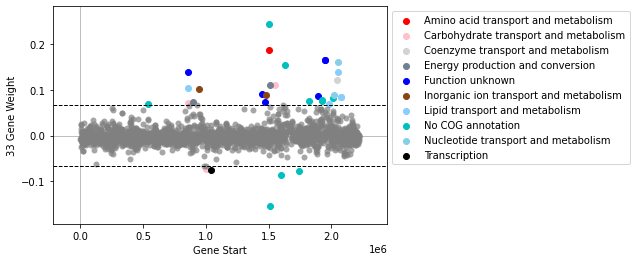

In [139]:
plot_gene_weights(ica_data, 33)

In [140]:
ica_data.view_imodulon(33)

gene_weight     gene_name old_locus_tag prokka_locus_tag  \
SACI_RS03235     0.069043     Saci_0680     Saci_0680      Sacid_00661   
SACI_RS05025     0.139720     Saci_1052     Saci_1052      Sacid_01026   
SACI_RS05035     0.102884     Saci_1054     Saci_1054      Sacid_01028   
SACI_RS05050     0.070690        glpK_1     Saci_1058      Sacid_01033   
SACI_RS05235     0.072807          gbsA     Saci_1099      Sacid_01075   
SACI_RS05415     0.102230        ydjE_1     Saci_1136      Sacid_01111   
SACI_RS05635    -0.073493           stp     Saci_1182      Sacid_01159   
SACI_RS05830    -0.075014         abfR2     Saci_1223      Sacid_01200   
SACI_RS08080     0.091552     Saci_1692     Saci_1692      Sacid_01656   
SACI_RS08185     0.072719          thpS     Saci_1714      Sacid_01677   
SACI_RS08230     0.089380     Saci_1723     Saci_1723      Sacid_01687   
SACI_RS08335     0.242544     Saci_1744     Saci_1744      Sacid_01708   
SACI_RS08340     0.186219        mctP_2     Saci_1745      Sacid_01709   
SACI_RS08350     0.109719        soxE_1     Saci_1747      Sacid_01711   
SACI_RS08380    -0.153176     Saci_1753     Saci_1753      Sacid_01717   
SACI_RS08525     0.110587        csbC_2     Saci_1782      Sacid_01749   
SACI_RS11705    -0.085715  SACI_RS11705           NaN              NaN   
SACI_RS08910     0.154756     Saci_1855     Saci_1855      Sacid_01824   
SACI_RS09325    -0.077488     Saci_1933     Saci_1933      Sacid_01917   
SACI_RS09715     0.076416     Saci_2009     Saci_2009      Sacid_02002   
SACI_RS10035     0.085775        ydjE_3     Saci_2076      Sacid_02071   
SACI_RS10165     0.077400     Saci_2103     Saci_2103      Sacid_02100   
SACI_RS10170     0.074563     Saci_2104     Saci_2104      Sacid_02101   
SACI_RS10270     0.164785     Saci_2124     Saci_2124      Sacid_02122   
SACI_RS10275     0.164357     Saci_2125     Saci_2125      Sacid_02123   
SACI_RS10390     0.068899          fadD     Saci_2148      Sacid_02146   
SACI_RS10515     0.081737     Saci_2175     Saci_2175      Sacid_02173   
SACI_RS10575     0.088921     Saci_2188     Saci_2188      Sacid_02187   
SACI_RS10665     0.120598        lipM_4     Saci_2206      Sacid_02207   
SACI_RS10690     0.138900     Saci_2211     Saci_2211      Sacid_02212   
SACI_RS10695     0.161626     Saci_2212     Saci_2212      Sacid_02213   
SACI_RS10800     0.083094        mmgC_3     Saci_2234      Sacid_02235   
SACI_RS10805     0.083842        acsA_5     Saci_2235      Sacid_02236   

             synonyms      start        end strand  \
SACI_RS03235      NaN   540470.0   541363.0      -   
SACI_RS05025      NaN   853736.0   854056.0      +   
SACI_RS05035      NaN   855397.0   857076.0      +   
SACI_RS05050      NaN   860143.0   861657.0      -   
SACI_RS05235      NaN   897628.0   899109.0      +   
SACI_RS05415      NaN   944847.0   946262.0      +   
SACI_RS05635      NaN   998087.0   999520.0      -   
SACI_RS05830      NaN  1041456.0  1041827.0      +   
SACI_RS08080      NaN  1450416.0  1450697.0      +   
SACI_RS08185      NaN  1473212.0  1474234.0      -   
SACI_RS08230      NaN  1480533.0  1481465.0      +   
SACI_RS08335      NaN  1504455.0  1504646.0      +   
SACI_RS08340      NaN  1504651.0  1506231.0      +   
SACI_RS08350      NaN  1507564.0  1508253.0      +   
SACI_RS08380      NaN  1511477.0  1511761.0      +   
SACI_RS08525      NaN  1547302.0  1548780.0      -   
SACI_RS11705      NaN  1597500.0  1597703.0      +   
SACI_RS08910      NaN  1628134.0  1629138.0      +   
SACI_RS09325      NaN  1743815.0  1744156.0      -   
SACI_RS09715      NaN  1822930.0  1823295.0      +   
SACI_RS10035      NaN  1893103.0  1894461.0      +   
SACI_RS10165      NaN  1925059.0  1925688.0      +   
SACI_RS10170      NaN  1925693.0  1926532.0      +   
SACI_RS10270      NaN  1950091.0  1951167.0      +   
SACI_RS10275      NaN  1951225.0  1951599.0      +   
SACI_RS10390      NaN  1979031.0  1980698.0      +   
SACI_RS10515      NaN  2010026.0  20105

<AxesSubplot:ylabel='33 iModulon\nActivity'>

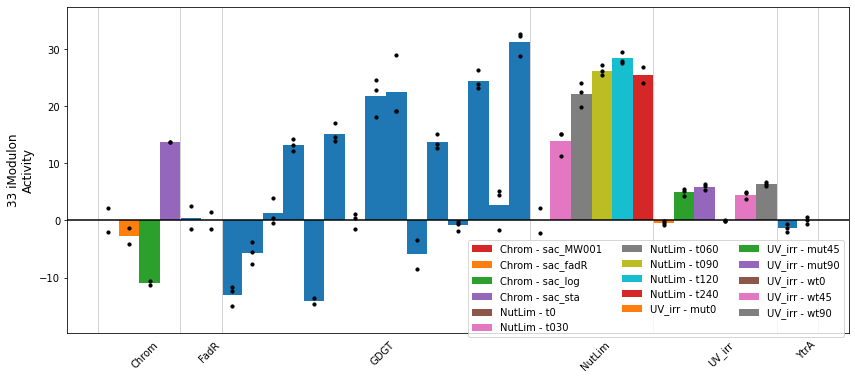

In [141]:
fig, ax = plt.subplots(figsize=(14, 6))

plot_activities(ica_data, 33, highlight=['Chrom', 'NutLim', 'UV_irr'], ax=ax,
                legend_kwargs={'bbox_to_anchor':(1, 0.3)})

### iModulon 32: Uncharacterized iModulon

<AxesSubplot:xlabel='Gene Start', ylabel='32 Gene Weight'>

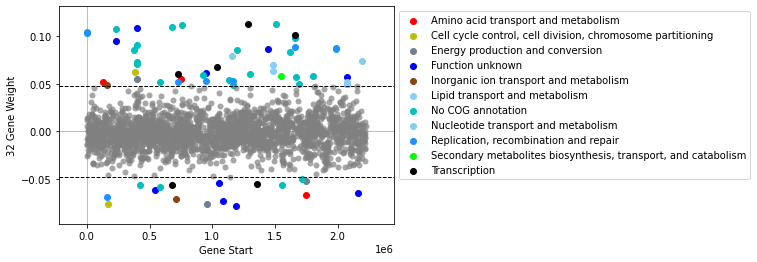

In [142]:
plot_gene_weights(ica_data, 32)

In [143]:
# Uncomment below to see genes enriched in this iModulon

#ica_data.view_imodulon(32)[0:40]
#ica_data.view_imodulon(32)[40:]

<AxesSubplot:ylabel='32 iModulon\nActivity'>

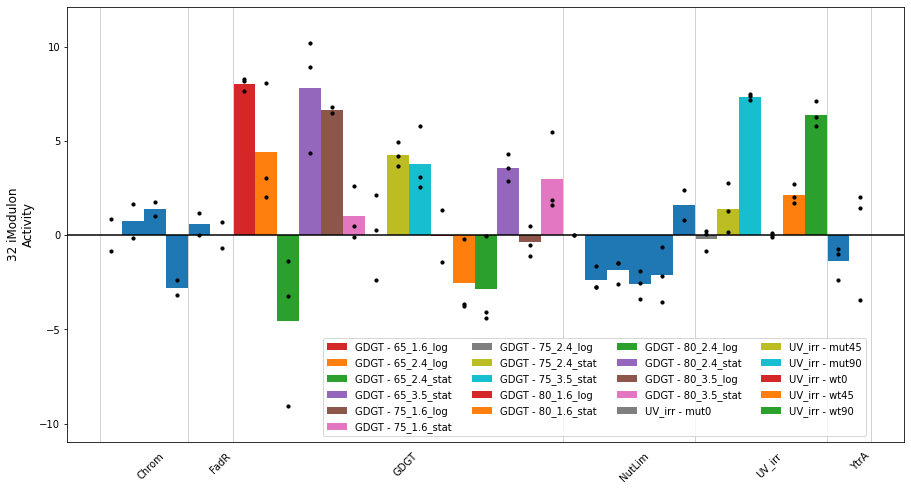

In [144]:
fig, ax = plt.subplots(figsize=(15, 8))

plot_activities(ica_data, 32, highlight=['GDGT', 'UV_irr'], ax=ax,
                legend_kwargs={'bbox_to_anchor':(0.3, 0.25)})

### iModulon 38: Putative Ammonium Uptake iModulon [E coli Ortholog: NtrC+RpoN]
### Probable Nitrogen Metabolism Involvement

<AxesSubplot:xlabel='Gene Start', ylabel='38 Gene Weight'>

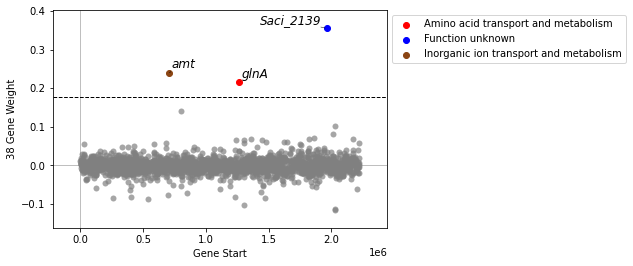

In [145]:
plot_gene_weights(ica_data, 38)

In [146]:
ica_data.view_imodulon(38)

gene_weight  gene_name old_locus_tag prokka_locus_tag synonyms  \
SACI_RS04215     0.240628        amt     Saci_0883      Sacid_00860      NaN   
SACI_RS07075     0.215236       glnA     Saci_1483      Sacid_01450   glnA_1   
SACI_RS10345     0.354988  Saci_2139     Saci_2139      Sacid_02137      NaN   

                  start        end strand  \
SACI_RS04215   708849.0   710294.0      +   
SACI_RS07075  1261179.0  1262600.0      -   
SACI_RS10345  1966994.0  1967353.0      -   

                                        gene_product   gene_product_prokka  \
SACI_RS04215  Ammonia permease, ammonium transporter       Ammonia channel   
SACI_RS07075        type I glutamate--ammonia ligase  Glutamine synthetase   
SACI_RS10345                    hypothetical protein  hypothetical protein   

                                                 COG        uniprot  \
SACI_RS04215  Inorganic ion transport and metabolism  UPI0002B27354   
SACI_RS07075     Amino acid transport and metabolism     A0A0U2WW46   
SACI_RS10345                        Function unknown     A0A0U3FQV9   

                   refseq regulator  
SACI_RS04215  NC_007181.1      XylR  
SACI_RS07075  NC_007181.1      LrpC  
SACI_RS10345  NC_007181.1      XylR

<AxesSubplot:ylabel='38 iModulon\nActivity'>

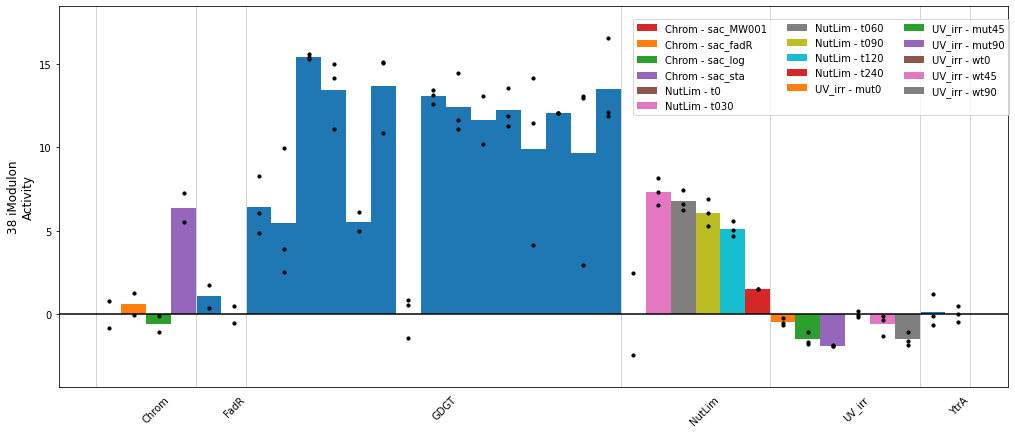

In [147]:
fig, ax = plt.subplots(figsize=(17, 7))

plot_activities(ica_data, 38, highlight=['Chrom', 'NutLim', 'UV_irr'], ax=ax,
                legend_kwargs={'bbox_to_anchor':(0.6, 0.7)})

### iModulon 14: Putative Phenylacetate Degradation iModulon

<AxesSubplot:xlabel='Gene Start', ylabel='14 Gene Weight'>

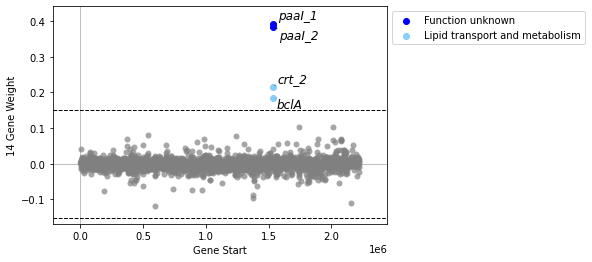

In [148]:
plot_gene_weights(ica_data, 14)

In [149]:
ica_data.view_imodulon(14)

gene_weight gene_name old_locus_tag prokka_locus_tag  \
SACI_RS08465     0.390392    paaI_1     Saci_1770      Sacid_01736   
SACI_RS08470     0.382446    paaI_2     Saci_1771      Sacid_01737   
SACI_RS08475     0.215781     crt_2     Saci_1772      Sacid_01738   
SACI_RS08485     0.184597      bclA     Saci_1774      Sacid_01740   

                synonyms      start        end strand  \
SACI_RS08465        paaI  1531395.0  1532090.0      -   
SACI_RS08470  paaI, boxB  1532100.0  1532870.0      -   
SACI_RS08475         NaN  1533033.0  1533836.0      +   
SACI_RS08485         NaN  1535691.0  1537271.0      +   

                                              gene_product  \
SACI_RS08465      phenylacetate-CoA oxygenase subunit PaaI   
SACI_RS08470      phenylacetate-CoA oxygenase subunit PaaI   
SACI_RS08475  enoyl-CoA hydratase/isomerase family protein   
SACI_RS08485            benzoate-CoA ligase family protein   

                            gene_product_prokka  \
SACI_RS08465               hypothetical protein   
SACI_RS08470  Benzoyl-CoA oxygenase component B   
SACI_RS08475    Short-chain-enoyl-CoA hydratase   
SACI_RS08485               Benzoate--CoA ligase   

                                         COG     uniprot       refseq  \
SACI_RS08465                Function unknown  A0A0U3H790  NC_007181.1   
SACI_RS08470                Function unknown  A0A0U3FSM1  NC_007181.1   
SACI_RS08475  Lipid transport and metabolism  A0A0U3GMZ0  NC_007181.1   
SACI_RS08485  Lipid transport and metabolism  A0A0U3HIU5  NC_007181.1   

             regulator  
SACI_RS08465       NaN  
SACI_RS08470       NaN  
SACI_RS08475       NaN  
SACI_RS08485       NaN

<AxesSubplot:ylabel='14 iModulon\nActivity'>

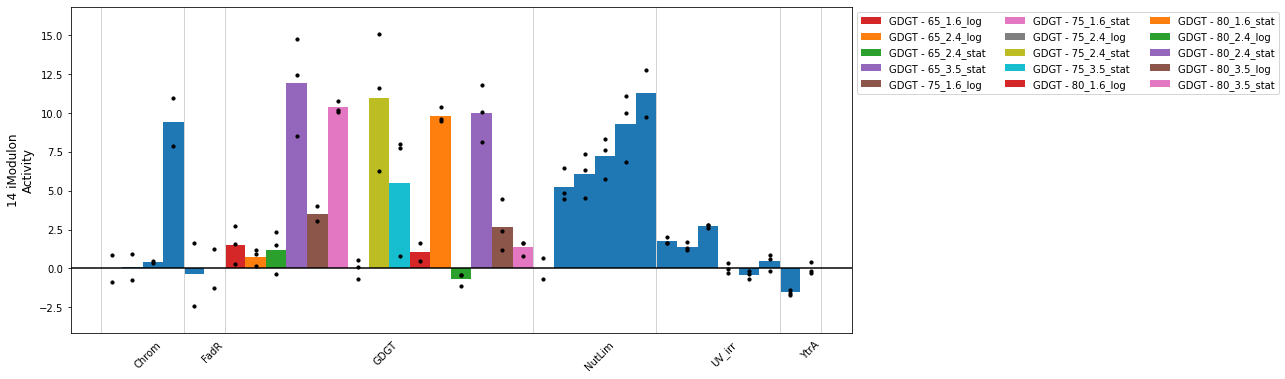

In [150]:
fig, ax = plt.subplots(figsize=(14, 6))

plot_activities(ica_data, 14, highlight='GDGT', ax=ax)

<AxesSubplot:ylabel='14 iModulon\nActivity'>

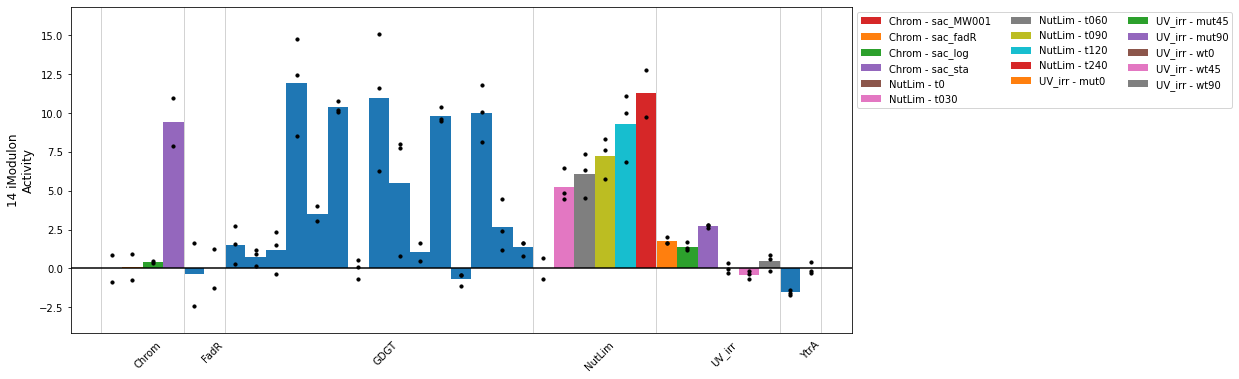

In [151]:
fig, ax = plt.subplots(figsize=(14, 6))

plot_activities(ica_data, 14, highlight=['Chrom', 'NutLim', 'UV_irr'], ax=ax)

### iModulon 8: Putative Sulfur Metabolism iModulon

<AxesSubplot:xlabel='Gene Start', ylabel='8 Gene Weight'>

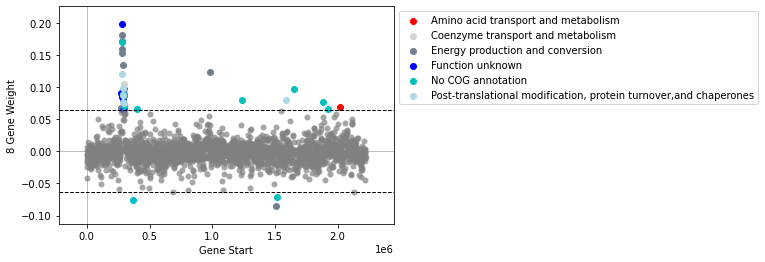

In [152]:
plot_gene_weights(ica_data, 8)

In [153]:
ica_data.view_imodulon(8)

gene_weight     gene_name old_locus_tag prokka_locus_tag  \
SACI_RS01565     0.068132          fdhF     Saci_0320      Sacid_00316   
SACI_RS01570     0.090674     Saci_0321     Saci_0321      Sacid_00317   
SACI_RS01585     0.197796     Saci_0324     Saci_0324      Sacid_00320   
SACI_RS01590     0.153582        sdhE_1     Saci_0325      Sacid_00321   
SACI_RS01595     0.158831     Saci_0326     Saci_0326      Sacid_00322   
SACI_RS01600     0.170436     Saci_0327     Saci_0327      Sacid_00323   
SACI_RS01605     0.180646        thi4_1     Saci_0328      Sacid_00324   
SACI_RS01610     0.172489     Saci_0329     Saci_0329      Sacid_00325   
SACI_RS01615     0.119824     Saci_0330     Saci_0330      Sacid_00326   
SACI_RS01620     0.085121     Saci_0331     Saci_0331      Sacid_00327   
SACI_RS01625     0.087223     Saci_0332     Saci_0332      Sacid_00328   
SACI_RS01630     0.080173     Saci_0333     Saci_0333      Sacid_00329   
SACI_RS01635     0.135252     Saci_0334     Saci_0334      Sacid_00330   
SACI_RS01640     0.076733          tusA     Saci_0335      Sacid_00331   
SACI_RS01645     0.064828         dsrE2     Saci_0336      Sacid_00332   
SACI_RS01650     0.099541     Saci_0337     Saci_0337      Sacid_00333   
SACI_RS01655     0.092581           lpd     Saci_0338      Sacid_00334   
SACI_RS01660     0.089922     Saci_0339     Saci_0339      Sacid_00335   
SACI_RS01665     0.087609          ahpF     Saci_0340      Sacid_00336   
SACI_RS01675     0.087571     Saci_0342     Saci_0342      Sacid_00338   
SACI_RS01680     0.087149        bioB_1     Saci_0343      Sacid_00339   
SACI_RS01685     0.087914        bioB_2     Saci_0344      Sacid_00340   
SACI_RS01690     0.105015        lipM_2     Saci_0345      Sacid_00341   
SACI_RS01700     0.070143     Saci_0348     Saci_0348      Sacid_00343   
SACI_RS01705     0.066473        gcvH_1     Saci_0349      Sacid_00344   
SACI_RS01710     0.097005        gcvH_2     Saci_0350      Sacid_00345   
SACI_RS01715     0.094767        lipM_3     Saci_0351      Sacid_00346   
SACI_RS01720     0.087629     Saci_0352     Saci_0352      Sacid_00347   
SACI_RS01725     0.075022     Saci_0353     Saci_0353      Sacid_00348   
SACI_RS02105    -0.075285     Saci_0433     Saci_0433      Sacid_00427   
SACI_RS02305     0.066497     Saci_0477     Saci_0477      Sacid_00469   
SACI_RS05570     0.123988        trxB_2     Saci_1169      Sacid_01146   
SACI_RS11930     0.080485  SACI_RS11930           NaN              NaN   
SACI_RS08350    -0.084678        soxE_1     Saci_1747      Sacid_01711   
SACI_RS08385    -0.071437     Saci_1754     Saci_1754      Sacid_01719   
SACI_RS08740     0.079821          trxA     Saci_1823      Sacid_01792   
SACI_RS09005     0.097356  SACI_RS09005           NaN              NaN   
SACI_RS09985     0.077129     Saci_2065     Saci_2065      Sacid_02060   
SACI_RS10165     0.066760     Saci_2103     Saci_2103      Sacid_02100   
SACI_RS10540     0.069683          puuP     Saci_2181      Sacid_02179   

             synonyms      start        end strand  \
SACI_RS01565      NaN   272254.0   275184.0      -   
SACI_RS01570      NaN   275396.0   276538.0      -   
SACI_RS01585      NaN   277460.0   278311.0      -   
SACI_RS01590      NaN   278371.0   279282.0      -   
SACI_RS01595      NaN   279279.0   279971.0      -   
SACI_RS01600      NaN   279958.0   280641.0      -   
SACI_RS01605      NaN   280685.0   281782.0      -   
SACI_RS01610      NaN   281837.0   283147.0      -   
SACI_RS01615      NaN   283670.0   283903.0      +   
SACI_RS01620      NaN   283916.0   285073.0      +   
SACI_RS01625      NaN   285075.0   285455.0      +   
SACI_RS01630      NaN   285461.0   286381.0      +   
SACI_RS01635      NaN   286554.0   287396.0      -   
SACI_RS01640      NaN   287471.0   287713.0      -   
SACI_RS01645      NaN   287725.0   288156.0      -   
SACI_RS01650      NaN   288292.0   288693.0      +   
SACI_RS01655      NaN   288700.0   290034.0      +   
SACI_RS

<AxesSubplot:ylabel='8 iModulon\nActivity'>

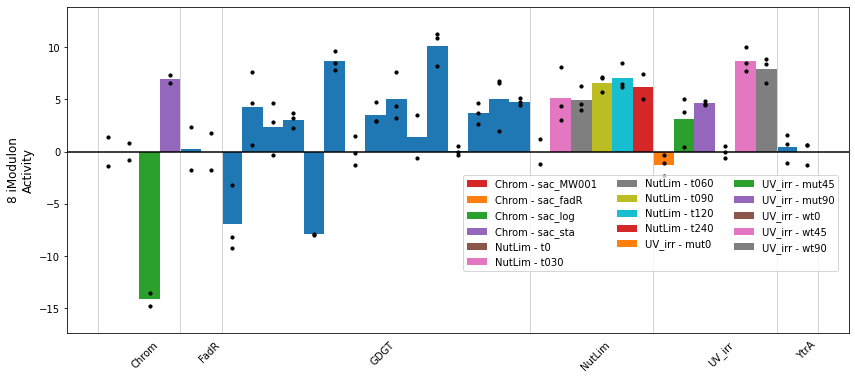

In [154]:
fig, ax = plt.subplots(figsize=(14, 6))

plot_activities(ica_data, 8, highlight=['Chrom', 'NutLim', 'UV_irr'], ax=ax,
                legend_kwargs={'bbox_to_anchor': (0.5, 0.5)})

### iModulon 3: Putative Fatty-Acid-related iModulon

<AxesSubplot:xlabel='Gene Start', ylabel='3 Gene Weight'>

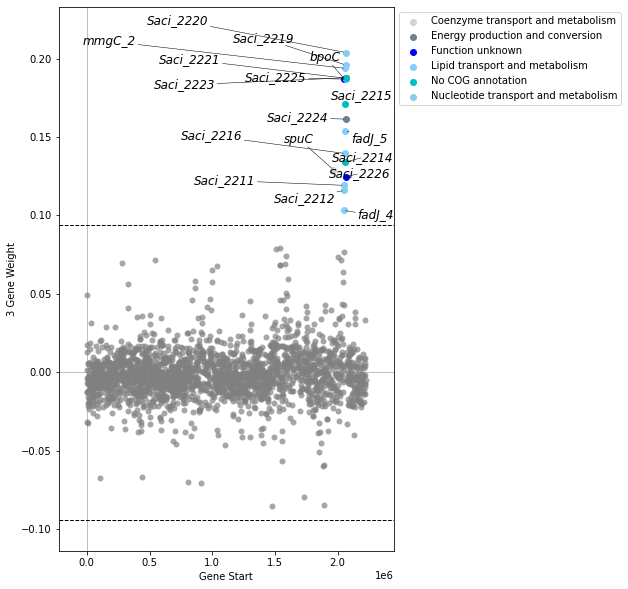

In [155]:
fig, ax = plt.subplots(figsize=(6, 10))

plot_gene_weights(ica_data, 3, ax=ax)

In [156]:
ica_data.view_imodulon(3)

gene_weight  gene_name old_locus_tag prokka_locus_tag synonyms  \
SACI_RS10335     0.129288       spuC     Saci_2137      Sacid_02135      NaN   
SACI_RS10675     0.103259     fadJ_4     Saci_2208      Sacid_02209      NaN   
SACI_RS10690     0.119224  Saci_2211     Saci_2211      Sacid_02212      NaN   
SACI_RS10695     0.116022  Saci_2212     Saci_2212      Sacid_02213      NaN   
SACI_RS10700     0.186997       bpoC     Saci_2213      Sacid_02214      NaN   
SACI_RS10705     0.133943  Saci_2214     Saci_2214      Sacid_02215      NaN   
SACI_RS10710     0.170888  Saci_2215     Saci_2215      Sacid_02216      NaN   
SACI_RS10715     0.139543  Saci_2216     Saci_2216      Sacid_02217      NaN   
SACI_RS10720     0.193837     mmgC_2     Saci_2217      Sacid_02219      NaN   
SACI_RS10725     0.154157     fadJ_5     Saci_2218      Sacid_02220      NaN   
SACI_RS10730     0.196009  Saci_2219     Saci_2219      Sacid_02221      NaN   
SACI_RS10735     0.203950  Saci_2220     Saci_2220      Sacid_02222      NaN   
SACI_RS10740     0.187505  Saci_2221     Saci_2221      Sacid_02223      NaN   
SACI_RS10745     0.187838  Saci_2223     Saci_2223      Sacid_02224      NaN   
SACI_RS10750     0.161442  Saci_2224     Saci_2224      Sacid_02225      NaN   
SACI_RS10755     0.186947  Saci_2225     Saci_2225      Sacid_02226      NaN   
SACI_RS10760     0.124819  Saci_2226     Saci_2226      Sacid_02227      NaN   

                  start        end strand  \
SACI_RS10335  1964516.0  1965850.0      +   
SACI_RS10675  2046825.0  2048798.0      -   
SACI_RS10690  2050681.0  2052348.0      -   
SACI_RS10695  2052558.0  2053550.0      +   
SACI_RS10700  2053621.0  2054565.0      -   
SACI_RS10705  2054663.0  2056171.0      -   
SACI_RS10710  2056355.0  2058994.0      -   
SACI_RS10715  2059230.0  2059847.0      -   
SACI_RS10720  2059997.0  2061196.0      +   
SACI_RS10725  2061332.0  2063251.0      +   
SACI_RS10730  2063298.0  2063792.0      -   
SACI_RS10735  2063999.0  2065036.0      +   
SACI_RS10740  2065138.0  2065809.0      +   
SACI_RS10745  2065820.0  2066245.0      +   
SACI_RS10750  2066295.0  2067353.0      +   
SACI_RS10755  2067743.0  2069371.0      +   
SACI_RS10760  2069481.0  2069891.0      +   

                                                   gene_product  \
SACI_RS10335                      beta-alanine aminotransferase   
SACI_RS10675  3-hydroxyacyl-CoA dehydrogenase/enoyl-CoA hydr...   
SACI_RS10690                  long-chain-fatty-acid--CoA ligase   
SACI_RS10695                     R2-like ligand-binding oxidase   
SACI_RS10700                               alpha/beta hydrolase   
SACI_RS10705                               hypothetical protein   
SACI_RS10710                               hypothetical protein   
SACI_RS10715                               hypothetical protein   
SACI_RS10720              acyl-CoA dehydrogenase family protein   
SACI_RS10725  3-hydroxyacyl-CoA dehydrogenase/enoyl-CoA hydr...   
SACI_RS10730                               hypothetical protein   
SACI_RS10735                     R2-like ligand-binding oxidase   
SACI_RS10740                               hypothetical protein   
SACI_RS10745                               hypothetical protein   
SACI_RS10750  alcohol dehydrogenase catalytic domain-contain...   
SACI_RS10755                  long-chain-fatty-acid--CoA ligase   
SACI_RS10760                               hypothetical protein   

                                     gene_product_prokka  \
SACI_RS10335       Putrescine--pyruvate aminotransferase   
SACI_RS10675  Fatty acid oxidation complex subunit alpha   
SACI_RS10690           Long-chain-fatty-acid--CoA ligase   
SACI_RS10695                        hypothetical protein   
SACI_RS10700      Putative non-heme bromoperoxidase BpoC   
SACI_RS10705                        hypothetical protein   
SACI_RS10710                        hypothetical protein   
SACI_RS10715                        hypothetical protein   
SACI_RS10720   

<AxesSubplot:ylabel='3 iModulon\nActivity'>

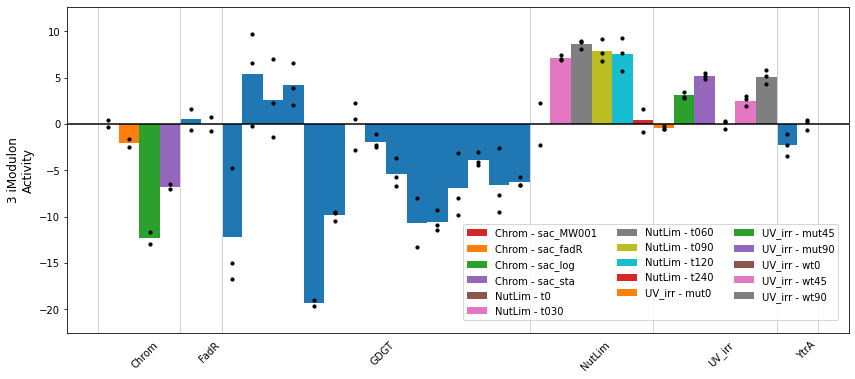

In [157]:
fig, ax = plt.subplots(figsize=(14, 6))

plot_activities(ica_data, 3, highlight=['Chrom', 'NutLim', 'UV_irr'], ax=ax,
                legend_kwargs={'bbox_to_anchor':(0.5, 0.35)})

### iModulon 0: Uncharacterized iModulon

<AxesSubplot:xlabel='Gene Start', ylabel='0 Gene Weight'>

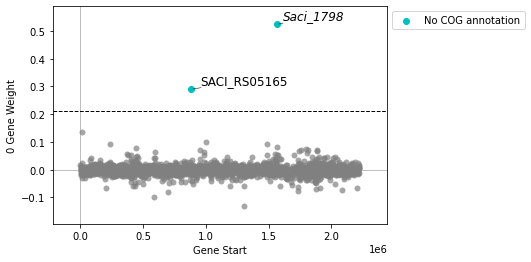

In [158]:
plot_gene_weights(ica_data, 0)

In [159]:
ica_data.view_imodulon(0)

gene_weight     gene_name old_locus_tag  \
SACI_RS05165     0.290069  SACI_RS05165           NaN   
SACI_RS08610     0.523578     Saci_1798     Saci_1798   

                      prokka_locus_tag synonyms      start        end strand  \
SACI_RS05165  Sacid_01058, Sacid_01059      NaN   883177.0   883904.0      -   
SACI_RS08610               Sacid_01767      NaN  1564898.0  1565779.0      +   

                      gene_product   gene_product_prokka                COG  \
SACI_RS05165  hypothetical protein  hypothetical protein  No COG annotation   
SACI_RS08610  hypothetical protein  hypothetical protein  No COG annotation   

                 uniprot       refseq regulator  
SACI_RS05165         NaN  NC_007181.1       NaN  
SACI_RS08610  A0A0U3GKI8  NC_007181.1       NaN

<AxesSubplot:ylabel='0 iModulon\nActivity'>

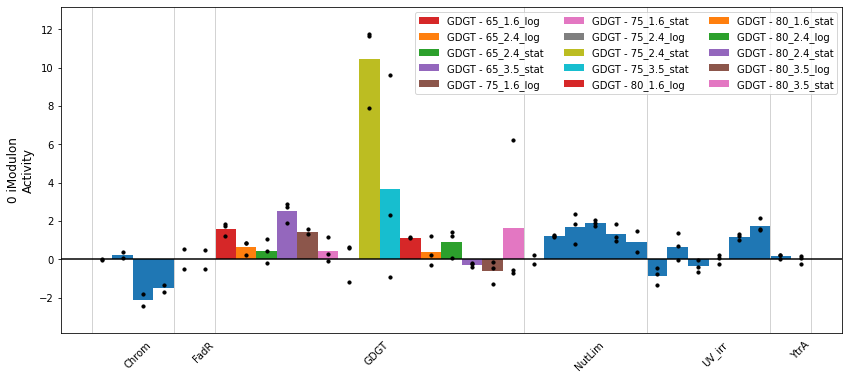

In [160]:
fig, ax = plt.subplots(figsize=(14, 6))

plot_activities(ica_data, 0, highlight='GDGT', ax=ax)

### iModulon 1: Uncharacterized iModulon

<AxesSubplot:xlabel='Gene Start', ylabel='1 Gene Weight'>

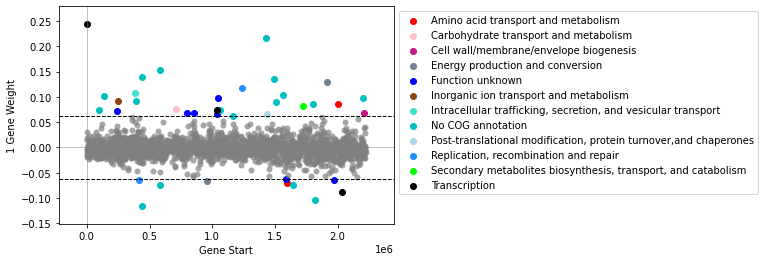

In [161]:
plot_gene_weights(ica_data, 1)

In [162]:
ica_data.view_imodulon(1)

gene_weight     gene_name old_locus_tag prokka_locus_tag  \
SACI_RS00030     0.243027     Saci_0006     Saci_0006      Sacid_00006   
SACI_RS00605     0.074336     Saci_0128     Saci_0128      Sacid_00123   
SACI_RS00795     0.101912     Saci_0167     Saci_0167      Sacid_00161   
SACI_RS01395     0.072524     Saci_0286     Saci_0286      Sacid_00282   
SACI_RS01445     0.092265        moaA_1     Saci_0296      Sacid_00292   
SACI_RS02175     0.108268     Saci_0449     Saci_0449      Sacid_00443   
SACI_RS02250     0.091161     Saci_0464     Saci_0464      Sacid_00458   
SACI_RS02420    -0.064121     Saci_0503     Saci_0503      Sacid_00497   
SACI_RS02570     0.138449     Saci_0538     Saci_0538      Sacid_00528   
SACI_RS11800    -0.114979  SACI_RS11800           NaN              NaN   
SACI_RS03450     0.153133     Saci_0724     Saci_0724      Sacid_00702   
SACI_RS03460    -0.074374  SACI_RS03460           NaN      Sacid_00705   
SACI_RS04230     0.076551          naiP     Saci_0886      Sacid_00863   
SACI_RS11630     0.068106  SACI_RS11630           NaN              NaN   
SACI_RS05040     0.068032     Saci_1055     Saci_1055      Sacid_01029   
SACI_RS05460    -0.065644        cdhA_2           NaN      Sacid_01121   
SACI_RS05800     0.066041     Saci_1217     Saci_1217      Sacid_01194   
SACI_RS05830     0.073231         abfR2     Saci_1223      Sacid_01200   
SACI_RS05870     0.098705     Saci_1231     Saci_1231      Sacid_01208   
SACI_RS05955     0.074410     Saci_1248     Saci_1248      Sacid_01225   
SACI_RS06525     0.063011     Saci_1364     Saci_1364      Sacid_01338   
SACI_RS06900     0.116785  SACI_RS06900           NaN      Sacid_01413   
SACI_RS07960     0.216607     Saci_1668     Saci_1668      Sacid_01631   
SACI_RS08000     0.066677     Saci_1676     Saci_1676      Sacid_01640   
SACI_RS08300     0.134535     Saci_1737     Saci_1737      Sacid_01701   
SACI_RS08380     0.089924     Saci_1753     Saci_1753      Sacid_01717   
SACI_RS08625     0.104247     Saci_1801     Saci_1801      Sacid_01770   
SACI_RS08730    -0.061636     Saci_1821     Saci_1821      Sacid_01790   
SACI_RS08800    -0.070682        abaF_4     Saci_1835      Sacid_01804   
SACI_RS08985    -0.074295     Saci_1868     Saci_1868      Sacid_01841   
SACI_RS09240     0.082260     Saci_1918     Saci_1918      Sacid_01892   
SACI_RS09625     0.086578     Saci_1990     Saci_1990      Sacid_01982   
SACI_RS11740    -0.104716  SACI_RS11740           NaN              NaN   
SACI_RS11760     0.129425  SACI_RS11760           NaN      Sacid_02092   
SACI_RS10345    -0.064424     Saci_2139     Saci_2139      Sacid_02137   
SACI_RS10495     0.086085     Saci_2170     Saci_2170      Sacid_02168   
SACI_RS10600    -0.087302     Saci_2193     Saci_2193      Sacid_02192   
SACI_RS11910     0.098591     Saci_2356     Saci_2356      Sacid_02355   
SACI_RS11435     0.068926          glmS     Saci_2364      Sacid_02363   

             synonyms      start        end strand  \
SACI_RS00030      NaN     3801.0     4052.0      -   
SACI_RS00605      NaN    99663.0   100643.0      +   
SACI_RS00795      NaN   136962.0   137603.0      -   
SACI_RS01395      NaN   241651.0   242223.0      -   
SACI_RS01445      NaN   251845.0   252864.0      -   
SACI_RS02175      NaN   381830.0   382318.0      +   
SACI_RS02250      NaN   392594.0   393088.0      -   
SACI_RS02420      NaN   417681.0   417860.0      +   
SACI_RS02570      NaN   440555.0   440959.0      -   
SACI_RS11800      NaN   442246.0   442317.0      -   
SACI_RS03450      NaN   580124.0   581809.0      +   
SACI_RS03460      NaN   584094.0   584273.0      +   
SACI_RS04230      NaN   712521.0   714002.0      -   
SACI_RS11630      NaN   799347.0   799547.0      -   
SACI_RS05040      NaN   857245.0   858099.0      +   
SACI_RS05460      NaN   955282.0   955806.0      +   
SACI_RS05800      NaN  1036824.0  1037123.0      -   
SACI_RS05830      NaN  1041456.0  1041827.0      +   
SACI_RS05870      NaN  1047

<AxesSubplot:ylabel='1 iModulon\nActivity'>

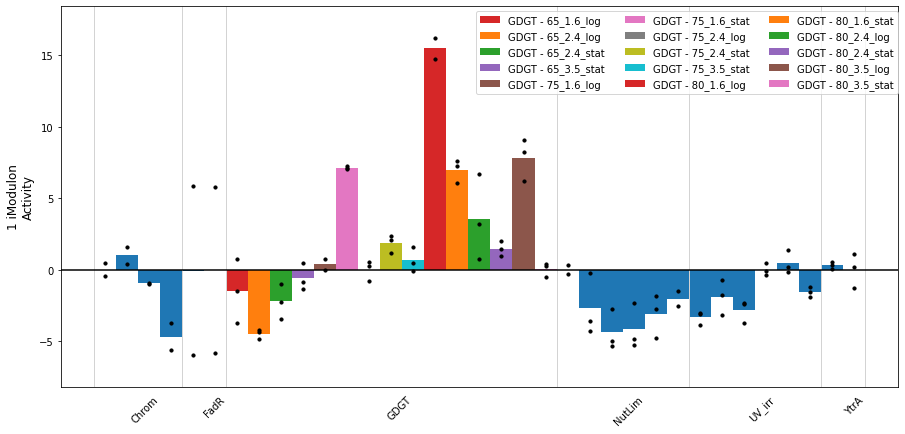

In [163]:
fig, ax = plt.subplots(figsize=(15, 7))

plot_activities(ica_data, 1, highlight='GDGT', ax=ax,
                legend_kwargs={'bbox_to_anchor':(0.49, 1)})

### iModulon 6: Uncharacterized iModulon

<AxesSubplot:xlabel='Gene Start', ylabel='6 Gene Weight'>

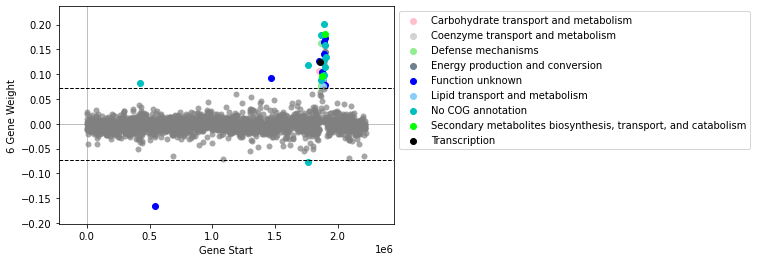

In [164]:
plot_gene_weights(ica_data, 6)

In [165]:
ica_data.view_imodulon(6)

gene_weight     gene_name old_locus_tag  \
SACI_RS02480     0.082701     Saci_0517     Saci_0517   
SACI_RS11570    -0.164900  SACI_RS11570           NaN   
SACI_RS11700     0.092745     Saci_1709     Saci_1709   
SACI_RS09400    -0.076305     Saci_1947     Saci_1947   
SACI_RS11990     0.119218  SACI_RS11990           NaN   
SACI_RS09835     0.106142          glpF     Saci_2034   
SACI_RS09840     0.127140     Saci_2035     Saci_2035   
SACI_RS09865     0.125052     Saci_2040     Saci_2040   
SACI_RS09895     0.074009     Saci_2046     Saci_2046   
SACI_RS09900     0.088281     Saci_2047     Saci_2047   
SACI_RS09905     0.078325     Saci_2048     Saci_2048   
SACI_RS09910     0.078644     Saci_2049     Saci_2049   
SACI_RS09915     0.163242  SACI_RS09915           NaN   
SACI_RS09920     0.179792     Saci_2052     Saci_2052   
SACI_RS09935     0.076488          hudA     Saci_2055   
SACI_RS09940     0.096752     Saci_2056     Saci_2056   
SACI_RS09965     0.103816     Saci_2061     Saci_2061   
SACI_RS09970     0.076468        acsA_4     Saci_2062   
SACI_RS09975     0.091458          caiD     Saci_2063   
SACI_RS09980     0.089123        cdhA_4     Saci_2064   
SACI_RS09990     0.125516     Saci_2066     Saci_2066   
SACI_RS09995     0.094503     Saci_2067     Saci_2067   
SACI_RS10000     0.101167     Saci_2068     Saci_2068   
SACI_RS10005     0.076880     Saci_2069     Saci_2069   
SACI_RS10010     0.097865     Saci_2070     Saci_2070   
SACI_RS10020     0.122189     Saci_2073     Saci_2073   
SACI_RS10025     0.163997     Saci_2074     Saci_2074   
SACI_RS10030     0.200180     Saci_2075     Saci_2075   
SACI_RS10035     0.141525        ydjE_3     Saci_2076   
SACI_RS11960     0.128537  SACI_RS11960           NaN   
SACI_RS10040     0.159516     Saci_2077     Saci_2077   
SACI_RS10045     0.115476     Saci_2078     Saci_2078   
SACI_RS10055     0.077938     Saci_2080     Saci_2080   
SACI_RS10060     0.144051          yjiB     Saci_2081   
SACI_RS10065     0.173133     Saci_2082     Saci_2082   
SACI_RS10070     0.180189          yecD     Saci_2083   
SACI_RS10075     0.156287        ribZ_2     Saci_2084   
SACI_RS11755     0.134203          soxL     Saci_2085   

                      prokka_locus_tag synonyms      start        end strand  \
SACI_RS02480               Sacid_00510      NaN   426068.0   426739.0      -   
SACI_RS11570                       NaN      NaN   542365.0   542577.0      +   
SACI_RS11700                       NaN      NaN  1468477.0  1468635.0      -   
SACI_RS09400               Sacid_01934      NaN  1759516.0  1759740.0      +   
SACI_RS11990                       NaN      NaN  1760019.0  1760123.0      +   
SACI_RS09835               Sacid_02029      NaN  1849204.0  1850085.0      +   
SACI_RS09840               Sacid_02030      NaN  1850246.0  1851289.0      +   
SACI_RS09865               Sacid_02035      NaN  1855837.0  1856316.0      -   
SACI_RS09895               Sacid_02041      NaN  1863675.0  1866395.0      -   
SACI_RS09900               Sacid_02042      NaN  1866379.0  1866594.0      -   
SACI_RS09905               Sacid_02043      NaN  1866597.0  1867352.0      -   
SACI_RS09910               Sacid_02044      NaN  1867402.0  1868238.0      -   
SACI_RS09915  Sacid_02045, Sacid_02046      NaN  1868239.0  1868964.0      -   
SACI_RS09920               Sacid_02047      NaN  1868961.0  1869347.0      -   
SACI_RS09935               Sacid_02050      NaN  1871167.0  1872585.0      -   
SACI_RS09940               Sacid_02051      NaN  1872930.0  1873880.0      +   
SACI_RS09965               Sacid_02056      NaN  1878613.0  1879272.0      +   
SACI_RS09970               Sacid_02057      NaN  1879438.0  1881123.0      +   
SACI_RS09975               Sacid_02058      NaN  1881193.0  1881957.0      +   
SACI_RS09980               Sacid_02059      NaN  1881960.0  1884236.0      +   
SACI_RS09990               Sacid_02061      NaN  1885365.0  1885955.0      +   
SACI_RS09995               Sac

<AxesSubplot:ylabel='6 iModulon\nActivity'>

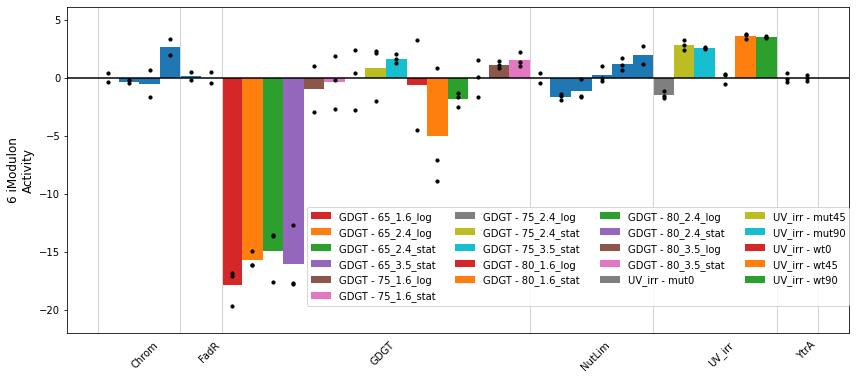

In [166]:
fig, ax = plt.subplots(figsize=(14, 6))

plot_activities(ica_data, 6, highlight=['GDGT', 'UV_irr'], ax=ax,
                legend_kwargs={'bbox_to_anchor':(0.3, 0.4)})

### iModulon 15: single_gene_1 (Uncharacterized iModulon)

<AxesSubplot:xlabel='Gene Start', ylabel='single_gene_1 Gene Weight'>

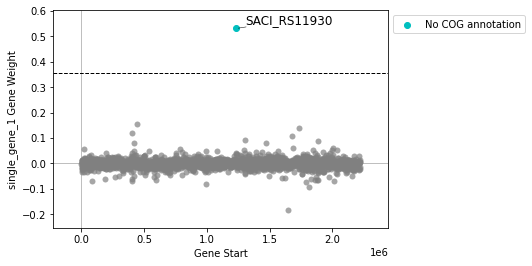

In [167]:
plot_gene_weights(ica_data, 'single_gene_1')

In [168]:
ica_data.view_imodulon('single_gene_1')

gene_weight     gene_name old_locus_tag prokka_locus_tag  \
SACI_RS11930     0.530262  SACI_RS11930           NaN              NaN   

             synonyms      start        end strand          gene_product  \
SACI_RS11930      NaN  1235099.0  1235239.0      -  hypothetical protein   

             gene_product_prokka                COG        uniprot  \
SACI_RS11930                 NaN  No COG annotation  UPI0012D9D522   

                   refseq regulator  
SACI_RS11930  NC_007181.1       NaN

### iModulon 16: single_gene_2 (Uncharacterized iModulon)

<AxesSubplot:xlabel='Gene Start', ylabel='single_gene_2 Gene Weight'>

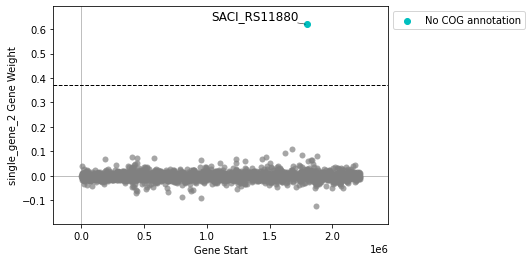

In [169]:
plot_gene_weights(ica_data, 'single_gene_2')

In [170]:
ica_data.view_imodulon('single_gene_2')

gene_weight     gene_name old_locus_tag prokka_locus_tag  \
SACI_RS11880      0.61887  SACI_RS11880           NaN              NaN   

             synonyms      start        end strand         gene_product  \
SACI_RS11880      NaN  1802184.0  1802258.0      +  PIN domain nuclease   

             gene_product_prokka                COG uniprot       refseq  \
SACI_RS11880                 NaN  No COG annotation     NaN  NC_007181.1   

             regulator  
SACI_RS11880       NaN

### iModulon 20: Uncharacterized iModulon

- Putative Nitrogen Starvation / Aromatic degradation / Antibiotic production iModulon

- Operon from Saci_2036 to Saci_2042 (excluding Saci_2040)

- Saci_2040 is a predicted TF [uniprot] and is missing from this operon (potential regulator of this operon?)

<AxesSubplot:xlabel='Gene Start', ylabel='20 Gene Weight'>

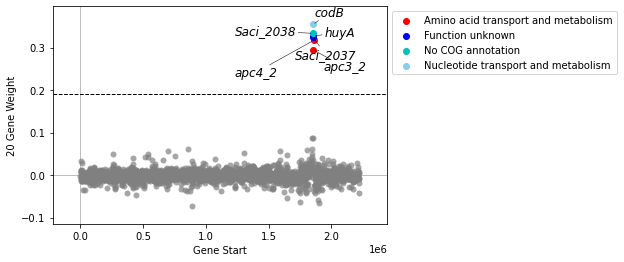

In [171]:
plot_gene_weights(ica_data, 20)

In [172]:
ica_data.view_imodulon(20)

gene_weight  gene_name old_locus_tag prokka_locus_tag synonyms  \
SACI_RS09845     0.295548     apc3_2     Saci_2036      Sacid_02031      NaN   
SACI_RS09850     0.325206  Saci_2037     Saci_2037      Sacid_02032      NaN   
SACI_RS09855     0.333669  Saci_2038     Saci_2038      Sacid_02033      NaN   
SACI_RS09860     0.354428       codB     Saci_2039      Sacid_02034      NaN   
SACI_RS09870     0.327592       huyA     Saci_2041      Sacid_02036   apc3_3   
SACI_RS09875     0.316897     apc4_2     Saci_2042      Sacid_02037      NaN   

                  start        end strand  \
SACI_RS09845  1851278.0  1852822.0      -   
SACI_RS09850  1852813.0  1853889.0      -   
SACI_RS09855  1853894.0  1854283.0      -   
SACI_RS09860  1854280.0  1855647.0      -   
SACI_RS09870  1856455.0  1858497.0      +   
SACI_RS09875  1858503.0  1860227.0      +   

                                            gene_product  \
SACI_RS09845                   hydantoinase subunit beta   
SACI_RS09850            DUF917 domain-containing protein   
SACI_RS09855                        hypothetical protein   
SACI_RS09860                           cytosine permease   
SACI_RS09870    hydantoinase/oxoprolinase family protein   
SACI_RS09875  hydantoinase B/oxoprolinase family protein   

                                 gene_product_prokka  \
SACI_RS09845  Acetophenone carboxylase gamma subunit   
SACI_RS09850                    hypothetical protein   
SACI_RS09855                    hypothetical protein   
SACI_RS09860                       Cytosine permease   
SACI_RS09870  Acetophenone carboxylase gamma subunit   
SACI_RS09875  Acetophenone carboxylase delta subunit   

                                              COG     uniprot       refseq  \
SACI_RS09845  Amino acid transport and metabolism  A0A0U3HGC9  NC_007181.1   
SACI_RS09850                     Function unknown  A0A0U3FHU3  NC_007181.1   
SACI_RS09855                    No COG annotation  A0A0U3F9L6  NC_007181.1   
SACI_RS09860  Nucleotide transport and metabolism  A0A0U2NH29  NC_007181.1   
SACI_RS09870  Amino acid transport and metabolism  A0A0U3FQD2  NC_007181.1   
SACI_RS09875  Amino acid transport and metabolism  A0A0U3FHA6  NC_007181.1   

             regulator  
SACI_RS09845       NaN  
SACI_RS09850       NaN  
SACI_RS09855       NaN  
SACI_RS09860       NaN  
SACI_RS09870       NaN  
SACI_RS09875       NaN

<AxesSubplot:ylabel='20 iModulon\nActivity'>

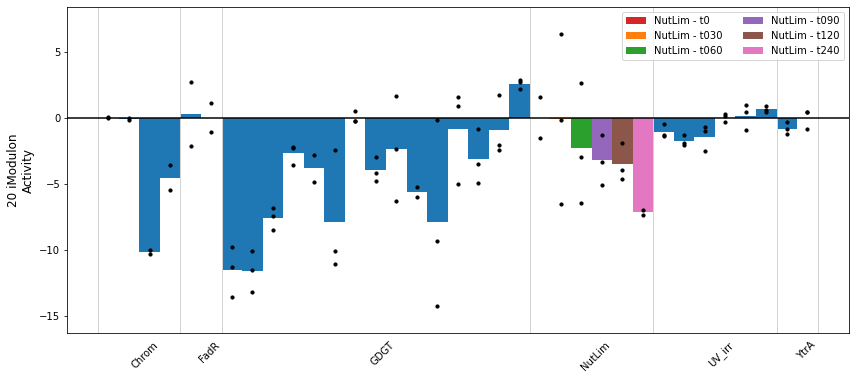

In [173]:
fig, ax = plt.subplots(figsize=(14, 6))

plot_activities(ica_data, 20, highlight=['NutLim'], ax=ax)

### iModulon 22: Uncharacterized iModulon

- 3 integrases and 1 PIN domain endonuclease
- Potentially from a virus?

<AxesSubplot:xlabel='Gene Start', ylabel='22 Gene Weight'>

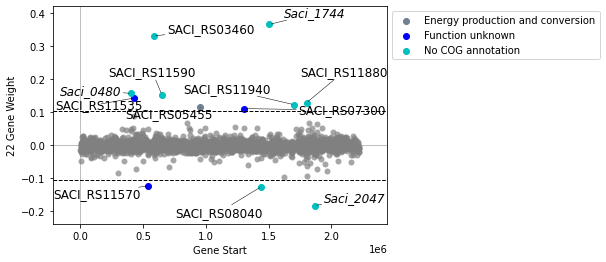

In [174]:
plot_gene_weights(ica_data, 22)

In [175]:
ica_data.view_imodulon(22)

gene_weight     gene_name old_locus_tag prokka_locus_tag  \
SACI_RS02320     0.157630     Saci_0480     Saci_0480      Sacid_00473   
SACI_RS11535     0.143340  SACI_RS11535           NaN      Sacid_00511   
SACI_RS11570    -0.121978  SACI_RS11570           NaN              NaN   
SACI_RS03460     0.331180  SACI_RS03460           NaN      Sacid_00705   
SACI_RS11590     0.153685  SACI_RS11590           NaN              NaN   
SACI_RS05455     0.115709  SACI_RS05455           NaN      Sacid_01120   
SACI_RS07300     0.111402  SACI_RS07300           NaN      Sacid_01497   
SACI_RS08040    -0.124633  SACI_RS08040           NaN      Sacid_01648   
SACI_RS08335     0.366300     Saci_1744     Saci_1744      Sacid_01708   
SACI_RS11940     0.123354  SACI_RS11940           NaN              NaN   
SACI_RS11880     0.129206  SACI_RS11880           NaN              NaN   
SACI_RS09900    -0.182711     Saci_2047     Saci_2047      Sacid_02042   

             synonyms      start        end strand  \
SACI_RS02320      NaN   402468.0   402758.0      +   
SACI_RS11535      NaN   426819.0   427622.0      -   
SACI_RS11570      NaN   542365.0   542577.0      +   
SACI_RS03460      NaN   584094.0   584273.0      +   
SACI_RS11590      NaN   648575.0   648803.0      +   
SACI_RS05455      NaN   954960.0   955145.0      +   
SACI_RS07300      NaN  1305203.0  1306027.0      -   
SACI_RS08040      NaN  1443061.0  1443315.0      -   
SACI_RS08335      NaN  1504455.0  1504646.0      +   
SACI_RS11940      NaN  1701777.0  1702049.0      +   
SACI_RS11880      NaN  1802184.0  1802258.0      +   
SACI_RS09900      NaN  1866379.0  1866594.0      -   

                                   gene_product   gene_product_prokka  \
SACI_RS02320               hypothetical protein  hypothetical protein   
SACI_RS11535                          integrase  hypothetical protein   
SACI_RS11570                 putative integrase                   NaN   
SACI_RS03460               hypothetical protein  hypothetical protein   
SACI_RS11590               hypothetical protein                   NaN   
SACI_RS05455               hypothetical protein  hypothetical protein   
SACI_RS07300                          integrase  hypothetical protein   
SACI_RS08040               hypothetical protein  hypothetical protein   
SACI_RS08335  DUF3311 domain-containing protein  hypothetical protein   
SACI_RS11940               hypothetical protein                   NaN   
SACI_RS11880                PIN domain nuclease                   NaN   
SACI_RS09900               hypothetical protein  hypothetical protein   

                                           COG        uniprot       refseq  \
SACI_RS02320                 No COG annotation     A0A0U2NCG0  NC_007181.1   
SACI_RS11535                  Function unknown  UPI0002B29D24  NC_007181.1   
SACI_RS11570                  Function unknown  UPI000AE9D732  NC_007181.1   
SACI_RS03460                 No COG annotation     A0A0U3FV95  NC_007181.1   
SACI_RS11590                 No COG annotation            NaN  NC_007181.1   
SACI_RS05455  Energy production and conversion     A0A0U3H132  NC_007181.1   
SACI_RS07300                  Function unknown  UPI000B5A97B4  NC_007181.1   
SACI_RS08040                 No COG annotation     A0A0U3GYK6  NC_007181.1   
SACI_RS08335                 No COG annotation     A0A0U3H881  NC_007181.1   
SACI_RS11940                 No COG annotation  UPI0002B260AD  NC_007181.1   
SACI_RS11880                 No COG annotation            NaN  NC_007181.1   
SACI_RS09900                 No COG annotation     A0A0U3GQM3  NC_007181.1   

             regulator  
SACI_RS02320       NaN  
SACI_RS11535       NaN  
SACI_RS11570       NaN  
SACI_RS03460       NaN  
SACI_RS11590       NaN  
SACI_RS05455       NaN  
SACI_RS07300       NaN  
SACI_RS08040       NaN  
SACI_RS08335       NaN  
SACI_RS11940       NaN  
SACI_RS11880       NaN  
SACI_RS09900       NaN

### iModulon 28: single_gene_4 (Uncharacterized iModulon)

<AxesSubplot:xlabel='Gene Start', ylabel='single_gene_4 Gene Weight'>

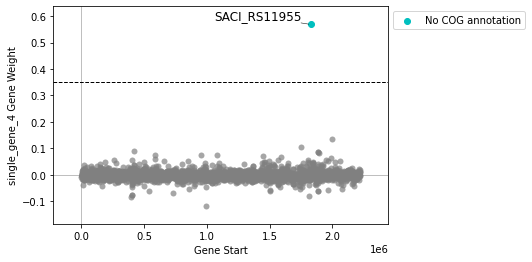

In [176]:
plot_gene_weights(ica_data, 'single_gene_4')

In [177]:
ica_data.view_imodulon('single_gene_4')

gene_weight     gene_name old_locus_tag prokka_locus_tag  \
SACI_RS11955     0.568018  SACI_RS11955           NaN              NaN   

             synonyms      start        end strand          gene_product  \
SACI_RS11955      NaN  1829337.0  1829474.0      +  hypothetical protein   

             gene_product_prokka                COG        uniprot  \
SACI_RS11955                 NaN  No COG annotation  UPI000AA94FC4   

                   refseq regulator  
SACI_RS11955  NC_007181.1       NaN

### iModulon 30: Sox iModulon

<AxesSubplot:xlabel='Gene Start', ylabel='30 Gene Weight'>

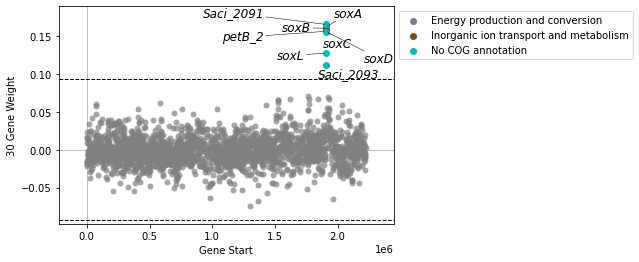

In [178]:
plot_gene_weights(ica_data, 30)

In [179]:
ica_data.view_imodulon(30)

gene_weight  gene_name old_locus_tag prokka_locus_tag synonyms  \
SACI_RS11755     0.127410       soxL     Saci_2085      Sacid_02081      NaN   
SACI_RS10080     0.156381     petB_2     Saci_2087      Sacid_02083      NaN   
SACI_RS10085     0.160649       soxB     Saci_2088      Sacid_02084      NaN   
SACI_RS10090     0.161909       soxA     Saci_2089      Sacid_02085      NaN   
SACI_RS10095     0.158420       soxC     Saci_2090      Sacid_02086      NaN   
SACI_RS10100     0.165432  Saci_2091     Saci_2091      Sacid_02087      NaN   
SACI_RS10105     0.155867       soxD     Saci_2092      Sacid_02088      NaN   
SACI_RS10110     0.111692  Saci_2093     Saci_2093      Sacid_02089      NaN   

                  start        end strand  \
SACI_RS11755  1903637.0  1903837.0      -   
SACI_RS10080  1903968.0  1905659.0      -   
SACI_RS10085  1905649.0  1907202.0      -   
SACI_RS10090  1907202.0  1907708.0      -   
SACI_RS10095  1908235.0  1909221.0      +   
SACI_RS10100  1909218.0  1909664.0      +   
SACI_RS10105  1909666.0  1910067.0      +   
SACI_RS10110  1910243.0  1910773.0      +   

                                            gene_product  \
SACI_RS11755                        hypothetical protein   
SACI_RS10080  cytochrome bc complex cytochrome b subunit   
SACI_RS10085    cbb3-type cytochrome c oxidase subunit I   
SACI_RS10090                    quinol oxidase subunit 2   
SACI_RS10095     Rieske 2Fe-2S domain-containing protein   
SACI_RS10100                        hypothetical protein   
SACI_RS10105                        hypothetical protein   
SACI_RS10110                        hypothetical protein   

               gene_product_prokka                                     COG  \
SACI_RS11755  hypothetical protein                       No COG annotation   
SACI_RS10080         Cytochrome b6        Energy production and conversion   
SACI_RS10085  hypothetical protein        Energy production and conversion   
SACI_RS10090  hypothetical protein        Energy production and conversion   
SACI_RS10095  hypothetical protein  Inorganic ion transport and metabolism   
SACI_RS10100  hypothetical protein                       No COG annotation   
SACI_RS10105  hypothetical protein                       No COG annotation   
SACI_RS10110  hypothetical protein                       No COG annotation   

                    uniprot       refseq regulator  
SACI_RS11755  UPI0002B27972  NC_007181.1       NaN  
SACI_RS10080     A0A0U3FZ60  NC_007181.1       NaN  
SACI_RS10085     A0A0U3H4H8  NC_007181.1       NaN  
SACI_RS10090     A0A0U2NHU3  NC_007181.1       NaN  
SACI_RS10095     A0A0U3FPX6  NC_007181.1       NaN  
SACI_RS10100     A0A0U2NAW8  NC_007181.1       NaN  
SACI_RS10105     A0A0U3HC57  NC_007181.1       NaN  
SACI_RS10110  UPI0002B28B76  NC_007181.1       NaN

<AxesSubplot:ylabel='30 iModulon\nActivity'>

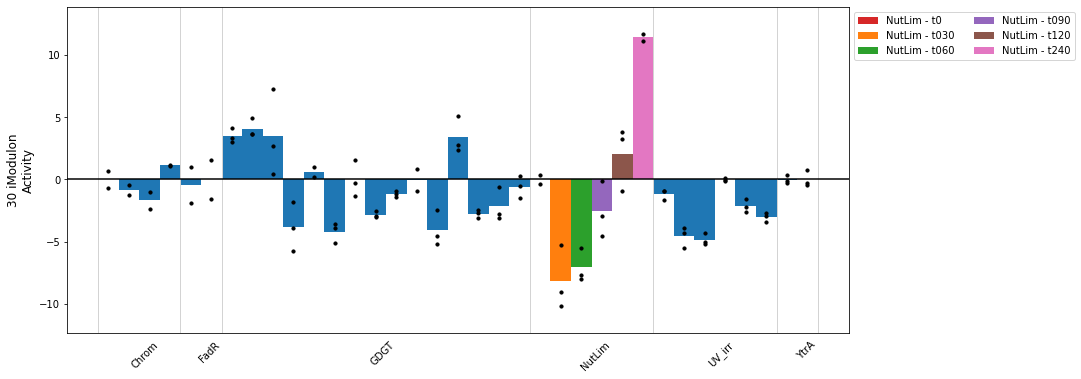

In [180]:
fig, ax = plt.subplots(figsize=(14, 6))

plot_activities(ica_data, 30, highlight=['NutLim'], ax=ax)

### Imodulon 36: Uncharacterized iModulon

- Putative Nicotine biosynthesis iModulon
- Putative Pyrmidine degradation iModulon

<AxesSubplot:xlabel='Gene Start', ylabel='36 Gene Weight'>

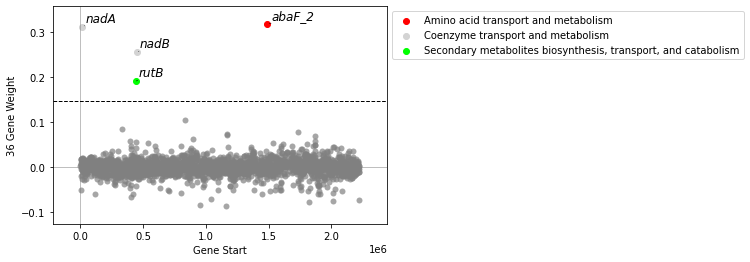

In [181]:
plot_gene_weights(ica_data, 36)

In [182]:
ica_data.view_imodulon(36)

gene_weight gene_name old_locus_tag prokka_locus_tag synonyms  \
SACI_RS00105     0.311939      nadA     Saci_0023      Sacid_00022      NaN   
SACI_RS02590     0.191013      rutB     Saci_0543      Sacid_00533      NaN   
SACI_RS02620     0.254860      nadB     Saci_0549      Sacid_00539      NaN   
SACI_RS08270     0.317011    abaF_2     Saci_1731      Sacid_01695      NaN   

                  start        end strand               gene_product  \
SACI_RS00105    14685.0    15683.0      +  quinolinate synthase NadA   
SACI_RS02590   443595.0   444197.0      -         cysteine hydrolase   
SACI_RS02620   447582.0   449033.0      +        FAD-binding protein   
SACI_RS08270  1489298.0  1490629.0      -            MFS transporter   

                                            gene_product_prokka  \
SACI_RS00105                             Quinolinate synthase A   
SACI_RS02590  Peroxyureidoacrylate/ureidoacrylate amidohydro...   
SACI_RS02620                                L-aspartate oxidase   
SACI_RS08270                 Fosfomycin resistance protein AbaF   

                                                            COG  \
SACI_RS00105                  Coenzyme transport and metabolism   
SACI_RS02590  Secondary metabolites biosynthesis, transport,...   
SACI_RS02620                  Coenzyme transport and metabolism   
SACI_RS08270                Amino acid transport and metabolism   

                    uniprot       refseq regulator  
SACI_RS00105  UPI0000552108  NC_007181.1       NaN  
SACI_RS02590     A0A0U2NF55  NC_007181.1       NaN  
SACI_RS02620     A0A0U3HB63  NC_007181.1       NaN  
SACI_RS08270     A0A0U2W175  NC_007181.1       NaN

<AxesSubplot:ylabel='36 iModulon\nActivity'>

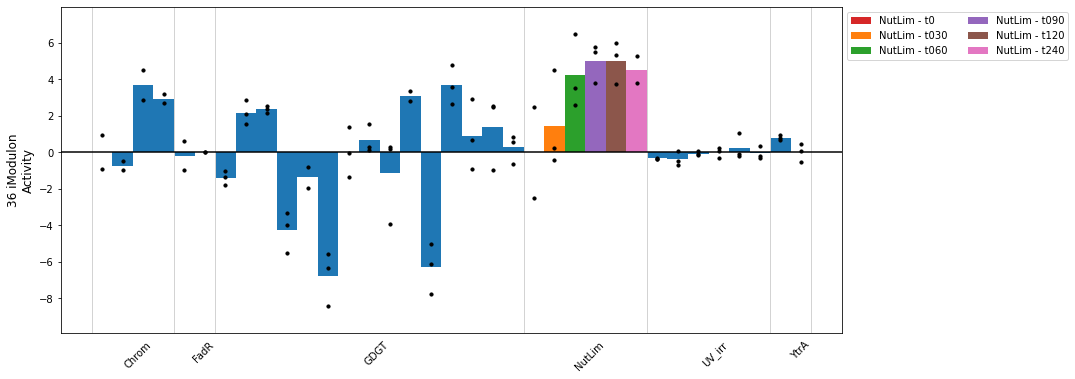

In [183]:
fig, ax = plt.subplots(figsize=(14, 6))

plot_activities(ica_data, 36, highlight=['NutLim'], ax=ax)

### iModulon 37: Uncharacterized iModulon

- Putative BarR / Lrp-like iModulon?

<AxesSubplot:xlabel='Gene Start', ylabel='37 Gene Weight'>

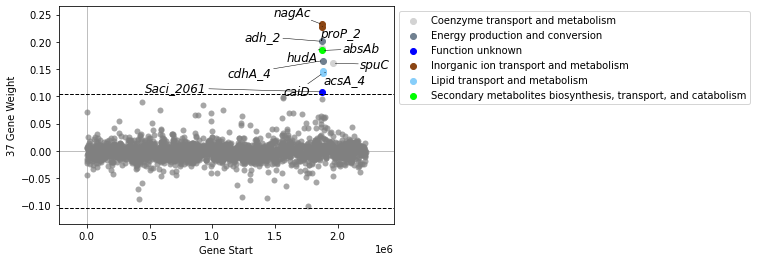

In [184]:
plot_gene_weights(ica_data, 37)

In [185]:
ica_data.view_imodulon(37)

gene_weight  gene_name old_locus_tag prokka_locus_tag synonyms  \
SACI_RS09935     0.187770       hudA     Saci_2055      Sacid_02050      NaN   
SACI_RS09945     0.200823      adh_2     Saci_2057      Sacid_02052      NaN   
SACI_RS09950     0.227832     proP_2     Saci_2058      Sacid_02053      NaN   
SACI_RS09955     0.231724      nagAc     Saci_2059      Sacid_02054      NaN   
SACI_RS09960     0.184133      absAb     Saci_2060      Sacid_02055      NaN   
SACI_RS09965     0.108108  Saci_2061     Saci_2061      Sacid_02056      NaN   
SACI_RS09970     0.145584     acsA_4     Saci_2062      Sacid_02057      NaN   
SACI_RS09975     0.142399       caiD     Saci_2063      Sacid_02058      NaN   
SACI_RS09980     0.165472     cdhA_4     Saci_2064      Sacid_02059      NaN   
SACI_RS10335     0.160738       spuC     Saci_2137      Sacid_02135      NaN   

                  start        end strand  \
SACI_RS09935  1871167.0  1872585.0      -   
SACI_RS09945  1873919.0  1874953.0      -   
SACI_RS09950  1875156.0  1876487.0      -   
SACI_RS09955  1876682.0  1878025.0      +   
SACI_RS09960  1878019.0  1878531.0      +   
SACI_RS09965  1878613.0  1879272.0      +   
SACI_RS09970  1879438.0  1881123.0      +   
SACI_RS09975  1881193.0  1881957.0      +   
SACI_RS09980  1881960.0  1884236.0      +   
SACI_RS10335  1964516.0  1965850.0      +   

                                                   gene_product  \
SACI_RS09935                          UbiD family decarboxylase   
SACI_RS09945             NAD(P)-dependent alcohol dehydrogenase   
SACI_RS09950                                    MFS transporter   
SACI_RS09955  aromatic ring-hydroxylating dioxygenase subuni...   
SACI_RS09960                aromatic ring dioxygenase subunit B   
SACI_RS09965         helix-turn-helix domain-containing protein   
SACI_RS09970                              acetyl-CoA synthetase   
SACI_RS09975       enoyl-CoA hydratase/isomerase family protein   
SACI_RS09980  xanthine dehydrogenase family protein molybdop...   
SACI_RS10335                      beta-alanine aminotransferase   

                                            gene_product_prokka  \
SACI_RS09935                            UbiD-like decarboxylase   
SACI_RS09945                              Alcohol dehydrogenase   
SACI_RS09950                        Proline/betaine transporter   
SACI_RS09955  Naphthalene 1,2-dioxygenase system, large oxyg...   
SACI_RS09960  2-aminobenzenesulfonate 2,3-dioxygenase subuni...   
SACI_RS09965                               hypothetical protein   
SACI_RS09970                       Acetyl-coenzyme A synthetase   
SACI_RS09975                         Carnitinyl-CoA dehydratase   
SACI_RS09980               Caffeine dehydrogenase subunit alpha   
SACI_RS10335              Putrescine--pyruvate aminotransferase   

                                                            COG     uniprot  \
SACI_RS09935                  Coenzyme transport and metabolism  A0A0U3HGB3   
SACI_RS09945                   Energy production and conversion  A0A0U2NH16   
SACI_RS09950             Inorganic ion transport and metabolism  A0A0U3GPF6   
SACI_RS09955             Inorganic ion transport and metabolism  A0A0U3HNQ5   
SACI_RS09960  Secondary metabolites biosynthesis, transport,...  A0A0U3FQB8   
SACI_RS09965                                   Function unknown  A0A0U3H5B5   
SACI_RS09970                     Lipid transport and metabolism  A0A0U3GV35   
SACI_RS09975                     Lipid transport and metabolism  A0A0U3GW81   
SACI_RS09980                   Energy production and conversion  A0A0U2VXW5   
SACI_RS10335                  Coenzyme transport and metabolism  A0A0U3HCW1   

                   refseq regulator  
SACI_RS09935  NC_007181.1       NaN  
SACI_RS09945  NC_007181.1   YtrA-OE  
SACI_RS09950  NC_007181.1       NaN  
SACI_RS09955  NC_007181.1       NaN  
SACI_RS09960  NC_007181.1       NaN  
SACI_RS09965  NC_007181.1       NaN  
SACI_RS09970  NC_007181.1

### iModulon 39: Uncharacterized iModulon

- Putative stress iModulon?


<AxesSubplot:xlabel='Gene Start', ylabel='39 Gene Weight'>

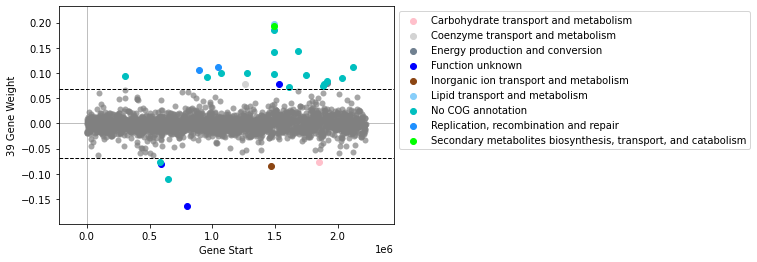

In [186]:
plot_gene_weights(ica_data, 39)

In [187]:
ica_data.view_imodulon(39)

gene_weight     gene_name old_locus_tag prokka_locus_tag  \
SACI_RS01760     0.094320     Saci_0360     Saci_0360      Sacid_00355   
SACI_RS03460    -0.077127  SACI_RS03460           NaN      Sacid_00705   
SACI_RS11580    -0.079621  SACI_RS11580           NaN              NaN   
SACI_RS11590    -0.109446  SACI_RS11590           NaN              NaN   
SACI_RS11630    -0.163157  SACI_RS11630           NaN              NaN   
SACI_RS05225     0.105964          uvsE     Saci_1096      Sacid_01072   
SACI_RS11845     0.092509  SACI_RS11845           NaN              NaN   
SACI_RS05850     0.111645          phrA     Saci_1227      Sacid_01204   
SACI_RS06010     0.100907  SACI_RS06010           NaN      Sacid_01236   
SACI_RS07065     0.078118          folE     Saci_1481      Sacid_01448   
SACI_RS07140     0.100223          upsA     Saci_1496      Sacid_01463   
SACI_RS08155    -0.084948     Saci_1707     Saci_1707      Sacid_01671   
SACI_RS08275     0.193054         carA2     Saci_1732      Sacid_01696   
SACI_RS08280     0.186133     Saci_1733     Saci_1733      Sacid_01697   
SACI_RS08285     0.196145          crtB     Saci_1734      Sacid_01698   
SACI_RS08290     0.142070     Saci_1735     Saci_1735      Sacid_01699   
SACI_RS08295     0.098816     Saci_1736     Saci_1736      Sacid_01700   
SACI_RS08455     0.077273        COQ5_4     Saci_1768      Sacid_01734   
SACI_RS08850     0.072436     Saci_1845     Saci_1845      Sacid_01814   
SACI_RS09075     0.144157  SACI_RS09075           NaN      Sacid_01859   
SACI_RS09325     0.095041     Saci_1933     Saci_1933      Sacid_01917   
SACI_RS09835    -0.076955          glpF     Saci_2034      Sacid_02029   
SACI_RS09985     0.073222     Saci_2065     Saci_2065      Sacid_02060   
SACI_RS10010     0.078542     Saci_2070     Saci_2070      Sacid_02065   
SACI_RS11760     0.080401  SACI_RS11760           NaN      Sacid_02092   
SACI_RS10145     0.083675     Saci_2099     Saci_2099      Sacid_02096   
SACI_RS10605     0.090631     Saci_2194     Saci_2194      Sacid_02193   
SACI_RS11030     0.111114     Saci_2280     Saci_2280      Sacid_02282   

             synonyms      start        end strand  \
SACI_RS01760      NaN   303121.0   304209.0      +   
SACI_RS03460      NaN   584094.0   584273.0      +   
SACI_RS11580      NaN   594292.0   594510.0      +   
SACI_RS11590      NaN   648575.0   648803.0      +   
SACI_RS11630      NaN   799347.0   799547.0      -   
SACI_RS05225      NaN   894785.0   895654.0      +   
SACI_RS11845      NaN   955170.0   955289.0      +   
SACI_RS05850      NaN  1043234.0  1044526.0      +   
SACI_RS06010      NaN  1071231.0  1071434.0      +   
SACI_RS07065      NaN  1259620.0  1260249.0      +   
SACI_RS07140      NaN  1275200.0  1275631.0      +   
SACI_RS08155      NaN  1465796.0  1466929.0      +   
SACI_RS08275      NaN  1490703.0  1492091.0      -   
SACI_RS08280      NaN  1492088.0  1492552.0      -   
SACI_RS08285      NaN  1492674.0  1493501.0      +   
SACI_RS08290      NaN  1493516.0  1494178.0      +   
SACI_RS08295      NaN  1494163.0  1495041.0      +   
SACI_RS08455      NaN  1528633.0  1529169.0      +   
SACI_RS08850      NaN  1612674.0  1613114.0      +   
SACI_RS09075      NaN  1680334.0  1680588.0      -   
SACI_RS09325      NaN  1743815.0  1744156.0      -   
SACI_RS09835      NaN  1849204.0  1850085.0      +   
SACI_RS09985      NaN  1884454.0  1885188.0      -   
SACI_RS10010      NaN  1887403.0  1888473.0      +   
SACI_RS11760      NaN  1914003.0  1914761.0      -   
SACI_RS10145      NaN  1917809.0  1918819.0      -   
SACI_RS10605      NaN  2033304.0  2034104.0      +   
SACI_RS11030      NaN  2124445.0  2124966.0      +   

                                            gene_product  \
SACI_RS01760                        hypothetical protein   
SACI_RS03460                        hypothetical protein   
SACI_RS11580                                   integrase   
SACI_RS11590                        hypothetical protein   


<AxesSubplot:ylabel='39 iModulon\nActivity'>

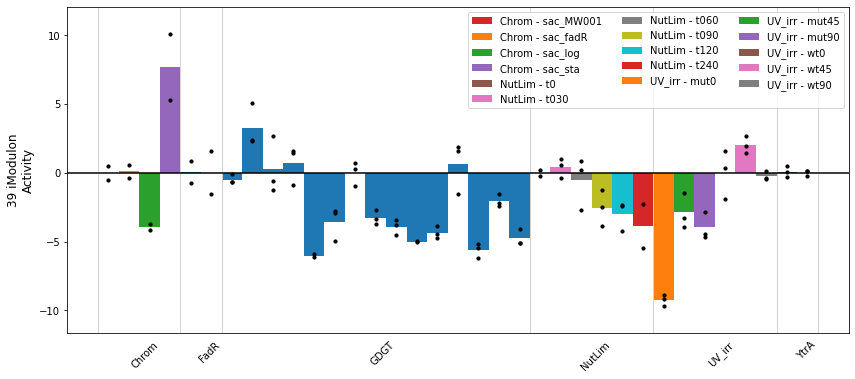

In [188]:
fig, ax = plt.subplots(figsize=(14, 6))

plot_activities(ica_data, 39, highlight=['Chrom','NutLim','UV_irr'], ax=ax)

### iModulon 40: single_gene_5 (Uncharacterized iModulon)

<AxesSubplot:xlabel='Gene Start', ylabel='single_gene_5 Gene Weight'>

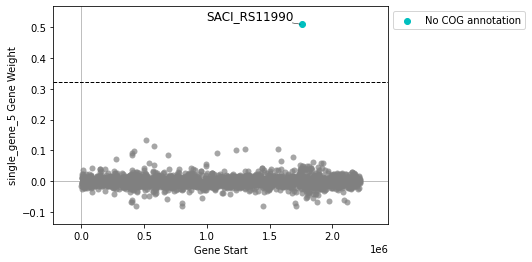

In [189]:
plot_gene_weights(ica_data, 'single_gene_5')

In [190]:
ica_data.view_imodulon('single_gene_5')

gene_weight     gene_name old_locus_tag prokka_locus_tag  \
SACI_RS11990     0.508807  SACI_RS11990           NaN              NaN   

             synonyms      start        end strand  \
SACI_RS11990      NaN  1760019.0  1760123.0      +   

                                                  gene_product  \
SACI_RS11990  type II toxin-antitoxin system VapC family toxin   

             gene_product_prokka                COG        uniprot  \
SACI_RS11990                 NaN  No COG annotation  UPI0011BDD67A   

                   refseq regulator  
SACI_RS11990  NC_007181.1       NaN

<AxesSubplot:ylabel='single_gene_5 iModulon\nActivity'>

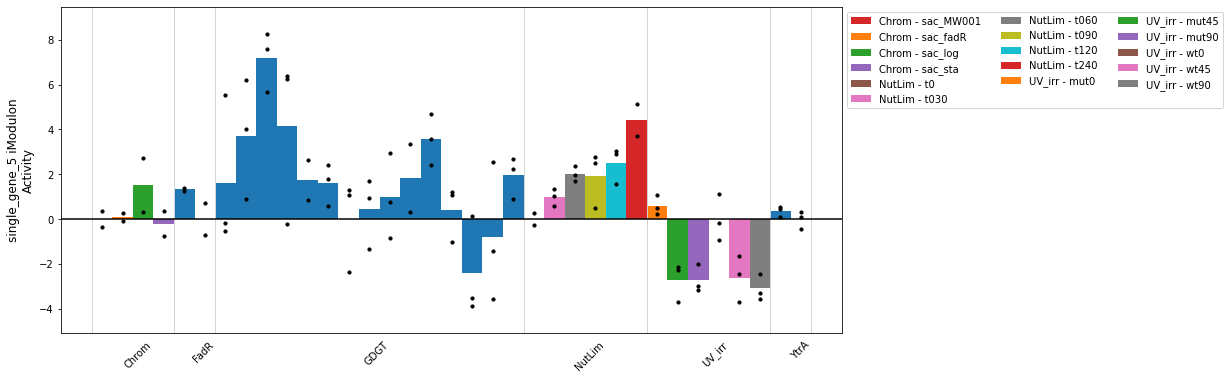

In [191]:
fig, ax = plt.subplots(figsize=(14, 6))

plot_activities(ica_data, 'single_gene_5', highlight=['Chrom','NutLim','UV_irr'], ax=ax)

### iModulon 42: Uncharacterized iModulon

<AxesSubplot:xlabel='Gene Start', ylabel='42 Gene Weight'>

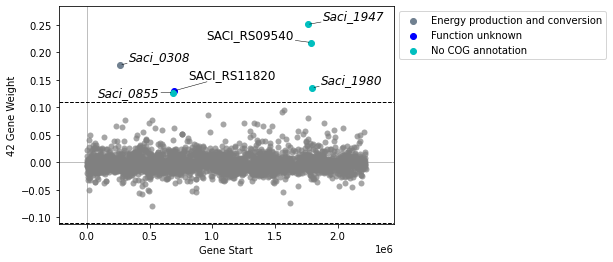

In [192]:
plot_gene_weights(ica_data, 42)

In [193]:
ica_data.view_imodulon(42)

gene_weight     gene_name old_locus_tag prokka_locus_tag  \
SACI_RS01505     0.177318     Saci_0308     Saci_0308      Sacid_00304   
SACI_RS11600     0.126978     Saci_0855     Saci_0855              NaN   
SACI_RS11820     0.130100  SACI_RS11820           NaN              NaN   
SACI_RS09400     0.250978     Saci_1947     Saci_1947      Sacid_01934   
SACI_RS09540     0.218173  SACI_RS09540           NaN      Sacid_01963   
SACI_RS09575     0.135677     Saci_1980     Saci_1980      Sacid_01970   

             synonyms      start        end strand  \
SACI_RS01505      NaN   263557.0   263805.0      +   
SACI_RS11600      NaN   686222.0   686431.0      +   
SACI_RS11820      NaN   694196.0   694357.0      -   
SACI_RS09400      NaN  1759516.0  1759740.0      +   
SACI_RS09540      NaN  1787219.0  1787317.0      +   
SACI_RS09575      NaN  1795356.0  1795592.0      +   

                                 gene_product   gene_product_prokka  \
SACI_RS01505        biotin attachment protein  hypothetical protein   
SACI_RS11600  TRASH domain-containing protein                   NaN   
SACI_RS11820                        integrase                   NaN   
SACI_RS09400             hypothetical protein  hypothetical protein   
SACI_RS09540             hypothetical protein  hypothetical protein   
SACI_RS09575             hypothetical protein  hypothetical protein   

                                           COG        uniprot       refseq  \
SACI_RS01505  Energy production and conversion     A0A0U2VW51  NC_007181.1   
SACI_RS11600                 No COG annotation  UPI00005523E6  NC_007181.1   
SACI_RS11820                  Function unknown            NaN  NC_007181.1   
SACI_RS09400                 No COG annotation     A0A0U3GMH0  NC_007181.1   
SACI_RS09540                 No COG annotation     A0A0U2X333  NC_007181.1   
SACI_RS09575                 No COG annotation     A0A0U3HCG5  NC_007181.1   

             regulator  
SACI_RS01505       NaN  
SACI_RS11600       NaN  
SACI_RS11820       NaN  
SACI_RS09400       NaN  
SACI_RS09540       NaN  
SACI_RS09575       NaN

### iModulon 43: single_gene_6 (Uncharacterized iModulon)

<AxesSubplot:xlabel='Gene Start', ylabel='single_gene_6 Gene Weight'>

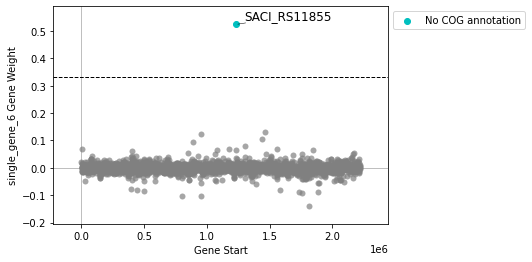

In [194]:
plot_gene_weights(ica_data, 'single_gene_6')

In [195]:
ica_data.view_imodulon('single_gene_6')

gene_weight     gene_name old_locus_tag prokka_locus_tag  \
SACI_RS11855     0.523488  SACI_RS11855           NaN              NaN   

             synonyms      start        end strand        gene_product  \
SACI_RS11855      NaN  1231584.0  1231667.0      +  putative integrase   

             gene_product_prokka                COG        uniprot  \
SACI_RS11855                 NaN  No COG annotation  UPI0011BFB8E2   

                   refseq regulator  
SACI_RS11855  NC_007181.1       NaN

<AxesSubplot:ylabel='single_gene_6 iModulon\nActivity'>

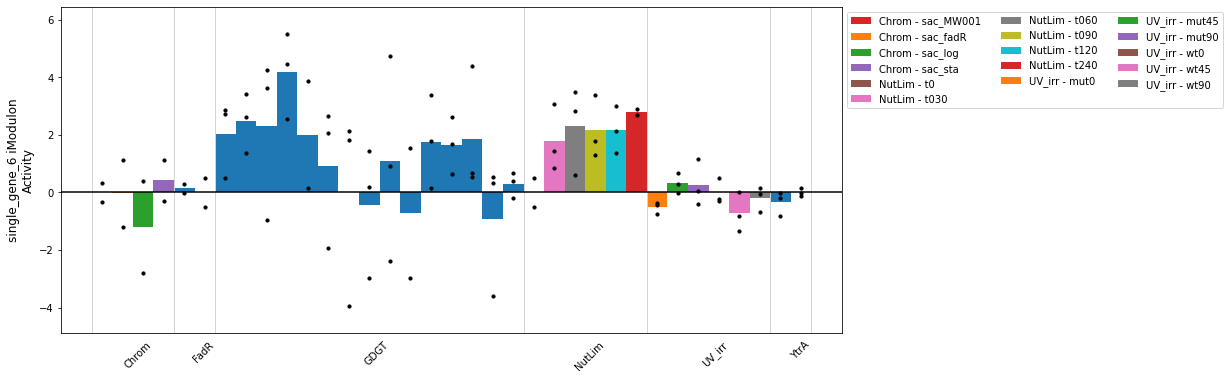

In [196]:
fig, ax = plt.subplots(figsize=(14, 6))

plot_activities(ica_data, 'single_gene_6', highlight=['Chrom','NutLim','UV_irr'], ax=ax)

### iModulon 44: Uncharacterized iModulon

<AxesSubplot:xlabel='Gene Start', ylabel='44 Gene Weight'>

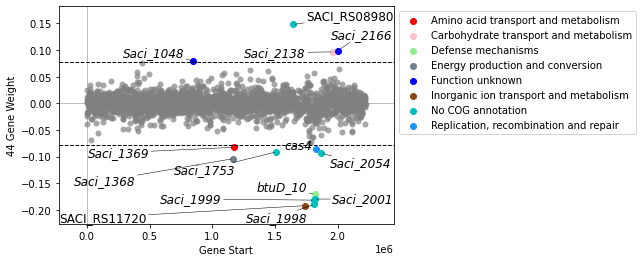

In [197]:
plot_gene_weights(ica_data, 44)

In [198]:
ica_data.view_imodulon(44)

gene_weight     gene_name old_locus_tag  \
SACI_RS05005     0.079997     Saci_1048     Saci_1048   
SACI_RS06545    -0.103753     Saci_1368     Saci_1368   
SACI_RS06550    -0.082509     Saci_1369     Saci_1369   
SACI_RS08380    -0.091023     Saci_1753     Saci_1753   
SACI_RS08980     0.148148  SACI_RS08980           NaN   
SACI_RS11720    -0.192109  SACI_RS11720           NaN   
SACI_RS09655    -0.189657     Saci_1998     Saci_1998   
SACI_RS09660    -0.181669     Saci_1999     Saci_1999   
SACI_RS09665    -0.170774       btuD_10     Saci_2000   
SACI_RS09670    -0.179644     Saci_2001     Saci_2001   
SACI_RS09730    -0.086304          cas4           NaN   
SACI_RS09930    -0.093822     Saci_2054     Saci_2054   
SACI_RS10340     0.096714     Saci_2138     Saci_2138   
SACI_RS10475     0.098851     Saci_2166     Saci_2166   

                      prokka_locus_tag synonyms      start        end strand  \
SACI_RS05005               Sacid_01022      NaN   848599.0   848853.0      +   
SACI_RS06545               Sacid_01341      NaN  1168374.0  1169306.0      +   
SACI_RS06550               Sacid_01342      NaN  1169308.0  1170423.0      +   
SACI_RS08380               Sacid_01717      NaN  1511477.0  1511761.0      +   
SACI_RS08980                       NaN      NaN  1644920.0  1645132.0      -   
SACI_RS11720               Sacid_01905      NaN  1735450.0  1735659.0      -   
SACI_RS09655               Sacid_01991      NaN  1813650.0  1814243.0      +   
SACI_RS09660               Sacid_01992      NaN  1814254.0  1815237.0      +   
SACI_RS09665               Sacid_01993      NaN  1815241.0  1816053.0      +   
SACI_RS09670               Sacid_01994      NaN  1816157.0  1816741.0      +   
SACI_RS09730  Sacid_02005, Sacid_02006      NaN  1827072.0  1827638.0      -   
SACI_RS09930               Sacid_02049      NaN  1869981.0  1870271.0      +   
SACI_RS10340               Sacid_02136      NaN  1965928.0  1966755.0      -   
SACI_RS10475               Sacid_02164      NaN  2000353.0  2000703.0      +   

                                                   gene_product  \
SACI_RS05005                   DUF504 domain-containing protein   
SACI_RS06545                   3-phosphoglycerate dehydrogenase   
SACI_RS06550  alanine--glyoxylate aminotransferase family pr...   
SACI_RS08380                               hypothetical protein   
SACI_RS08980                               hypothetical protein   
SACI_RS11720                alkaline phosphatase family protein   
SACI_RS09655                               hypothetical protein   
SACI_RS09660                               hypothetical protein   
SACI_RS09665                ABC transporter ATP-binding protein   
SACI_RS09670                               hypothetical protein   
SACI_RS09730                     CRISPR-associated protein Cas4   
SACI_RS09930                               hypothetical protein   
SACI_RS10340                             DMT family transporter   
SACI_RS10475  Uroporphyrin-III methyltransferase, DUF488 fam...   

                                      gene_product_prokka  \
SACI_RS05005                         hypothetical protein   
SACI_RS06545                    Hydroxypyruvate reductase   
SACI_RS06550           Soluble hydrogenase 42 kDa subunit   
SACI_RS08380                         hypothetical protein   
SACI_RS08980                                          NaN   
SACI_RS11720                         hypothetical protein   
SACI_RS09655                         hypothetical protein   
SACI_RS09660                         hypothetical protein   
SACI_RS09665  Vitamin B12 import ATP-binding protein BtuD   
SACI_RS09670                         hypothetical protein   
SACI_RS09730                         hypothetical protein   
SACI_RS09930                         hypothetical protein   
SACI_RS10340                         hypothetical protein   
SACI_RS10475                         hypothetical protein   

                                   

In [199]:
unchar_imods = [5, 33, 32, 0, 1, 6, 20, 22, 36, 37, 39, 42, 44,
                'single_gene_1', 'single_gene_2', 'single_gene_4',
                'single_gene_5', 'single_gene_6']

In [200]:
char_imods = set(ica_data.imodulon_names) - set(unchar_imods)

In [201]:
explained_variance(ica_data, imodulons=char_imods)

46.632118140321964

In [202]:
explained_variance(ica_data, imodulons=ica_data.imodulon_names)

71.71952203817116

In [203]:
explained_variance(ica_data, imodulons=unchar_imods)

25.112265338535146

# Save iModulon object

This will save your iModulon table, your thresholds, and any other information stored in the ica_data object.

In [204]:
save_to_json(ica_data,'../data/saci_ica_data.json')

If you prefer to view and edit your iModulon table in excel, save it as a CSV and reload the iModulon as before

In [205]:
ica_data.imodulon_table.to_csv('../data/iModulon_table.csv')